## Key Takeaways

### For NNs using Images
- Convolutions are helpful
- SGD isn't as good as newer optimizers like Adam and NesterovAdam - https://towardsdatascience.com/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f
- normalization is helpful (both of the features and the output) and helps prevent divergence
- batch normalization works well after the activation https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md


### Generally
- Never trust the data blindly

## Setup

### Imports

In [1]:
%matplotlib inline
from pandas.io.parsers import read_csv
from sklearn.model_selection import train_test_split

import os
import pickle

import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping, Callback, History
from keras.applications.inception_v3  import InceptionV3

from tensorflow.python.client import device_lib

from augmentdata.CustImageDataGenerator import CustImageDataGenerator,CustNumpyArrayIterator

print(device_lib.list_local_devices()) # confirm using GPU

D:\Anaconda2\envs\tf\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14608513978877403906
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4964850073
locality {
  bus_id: 1
}
incarnation: 3894686145967391259
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


### Constants

In [2]:
TRAIN_DATA = '../data/training.csv'
TEST_DATA = '../data/test.csv'
IMAGE_ROWS = 96
IMAGE_COLS = 96
INPUT_SHAPE = (IMAGE_ROWS, IMAGE_COLS, 1)
RETRAIN = False

### Load the Data

In [3]:
def loader(test=False, seed=None, keeplabels=None):
    if seed:
        np.random.seed(seed)
    fileloc = TEST_DATA if test else TRAIN_DATA
    
    df = read_csv(fileloc)
    
    df['Image'] = df['Image'].apply(lambda x: np.fromstring(x, sep=' '))
    
    if keeplabels:
        df = df[list(keeplabels) + ['Image']]
        
    df = df.dropna() # drop rows with missing labels
    
    X = np.vstack(df['Image'])
    # by pixel across the whole dataset subtract mean and divide by stdev
    X = X - np.tile(np.mean(X,axis=0),(X.shape[0],1))
    X = X / np.tile(np.std(X,axis=0),(X.shape[0],1))
    X = X.astype(np.float32)
    
    if not test:
        y = df[df.columns.difference(['Image'])].values
        y = y.astype(np.float32)
        y = (y - 48) / 48 # this helps, but tanh on output doesnt
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, y = X[shuffle], y[shuffle]
    else:
        y = None
    
    X = X.reshape(-1, 96, 96, 1)

    return X, y, df.columns.difference(['Image'])


In [4]:
X, y, labels = loader(seed=42)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=42)
data=[X_train, X_test, y_train, y_test]

### Plot an Example Image

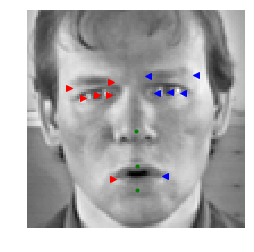

In [5]:
def plot_image(image, points, labels=list(labels), title=None):
    """Helper function to plot images"""
    plt.figure(figsize=(4,4))
    plt.imshow(np.reshape(image,(96,96)), cmap = 'gray')
    x = 0
    for i, label in enumerate(labels):
        if label[-1]=='x':
            x = points[i]
        else:
            if label in ['left_eye_center_y',
                         'left_eye_inner_corner_y', 
                         'left_eye_outer_corner_y', 
                         'left_eyebrow_inner_end_y', 
                         'left_eyebrow_outer_end_y',
                         'mouth_left_corner_y'
                        ]:
                plt.plot(x, points[i], 'b<')
            elif label in ['right_eye_center_y',
                         'right_eye_inner_corner_y', 
                         'right_eye_outer_corner_y', 
                         'right_eyebrow_inner_end_y', 
                         'right_eyebrow_outer_end_y',
                          'mouth_right_corner_y']:
                plt.plot(x, points[i], 'r>')
            else:
                plt.plot(x, points[i],'g.')
    plt.axis('off')
    if title:
        plt.title(title)



plot_image(X_train[0], 48*y_train[0]+48, labels)


### Model Fitting Function

In [14]:
def fit_model(model, data, modelname,
              generator=None,retrain=RETRAIN,
              epochs=10000, patience=1000):
    if retrain or not os.path.exists('../saved-models/' + modelname + '.h5'):
        X_train = data[0]
        y_train = data[2]
        if len(data) == 4:
            valid_dat = (data[1], data[3])
        else:
            valid_dat = None
        
        
        model.compile(loss='mse', optimizer=Nadam())
        earlystop = EarlyStopping(monitor='val_loss',
                                 patience=patience,
                                 verbose=1,
                                 mode="auto")
        callbacks = [earlystop]
        
        if generator:
            history = model.fit_generator(generator,
                        epochs=epochs,
                        steps_per_epoch=data[0].shape[0]//32,
                        callbacks=callbacks,
                        validation_data=valid_dat
             )
        else:
            history = model.fit(X_train, y_train,
                                epochs=epochs,
                                batch_size=32,
                                callbacks=callbacks,
                                validation_data=valid_dat
                     )
        model.save('../saved-models/'+ modelname + '.h5')
        with open('../saved-models/histories/'+modelname+'_hist',
                  'wb') as file_pi:
            pickle.dump(history.history, file_pi)
        history = history.history
    else:
        model = load_model('../saved-models/'+modelname+'.h5')
        history = pickle.load(open( "../saved-models/histories/" + modelname + '_hist',
                                   "rb" ))
        
    return history, model

### Helper function to plot the loss

In [15]:
def plot_loss(hists, names):
    colordict = {
        0 : 'b',
        1 : 'g',
        2 : 'r',
        3 : 'o',
        4 : 'p'
    }
    
    for i, hist in enumerate(hists):
        plt.plot([np.sqrt(x) * 48 for x in hist['loss']],
                 color=colordict[i],
                 label="train " + names[i])
        plt.plot([np.sqrt(x) * 48 for x in hist['val_loss']],
                 color=colordict[i],
                 linestyle=':',
                 label="valid " + names[i])
        plt.grid()
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel("RMSE")
        plt.yscale("log")
    plt.show()

## Models 
### 1 Dense Hidden Layer with 100 units

In [16]:
model1 = Sequential()
model1.add(Flatten(input_shape=INPUT_SHAPE))
model1.add(Dense(100, activation='relu'))
model1.add(Dense(30))
print(model1.summary())
model1_hist, model1 = fit_model(model1, data, '1dense100neuronlayer')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               921700    
_________________________________________________________________
dense_6 (Dense)              (None, 30)                3030      
Total params: 924,730
Trainable params: 924,730
Non-trainable params: 0
_________________________________________________________________
None
Train on 1712 samples, validate on 428 samples
Epoch 1/10000
1712/1712 [==============================] - 1s 404us/step - loss: 19.4671 - val_loss: 3.8749
Epoch 2/10000
1712/1712 [==============================] - 0s 203us/step - loss: 6.6743 - val_loss: 11.6523
Epoch 3/10000
1712/1712 [==============================] - 0s 212us/step - loss: 11.1521 - val_loss: 1.1724
Epoch 4/10000
1712/1712 

1712/1712 [==============================] - 0s 195us/step - loss: 0.0319 - val_loss: 0.2015
Epoch 70/10000
1712/1712 [==============================] - 0s 205us/step - loss: 0.0463 - val_loss: 0.1514
Epoch 71/10000
1712/1712 [==============================] - 0s 195us/step - loss: 0.0589 - val_loss: 0.1010
Epoch 72/10000
1712/1712 [==============================] - 0s 206us/step - loss: 0.0680 - val_loss: 0.1043
Epoch 73/10000
1712/1712 [==============================] - 0s 234us/step - loss: 0.0688 - val_loss: 0.2681
Epoch 74/10000
1712/1712 [==============================] - 0s 226us/step - loss: 0.0893 - val_loss: 0.1756
Epoch 75/10000
1712/1712 [==============================] - 0s 229us/step - loss: 0.0621 - val_loss: 0.0816
Epoch 76/10000
1712/1712 [==============================] - 0s 223us/step - loss: 0.0926 - val_loss: 0.3586
Epoch 77/10000
1712/1712 [==============================] - 0s 209us/step - loss: 0.0781 - val_loss: 0.1101
Epoch 78/10000
1712/1712 [=================

1712/1712 [==============================] - 0s 203us/step - loss: 0.2327 - val_loss: 0.3001
Epoch 145/10000
1712/1712 [==============================] - 0s 214us/step - loss: 0.1917 - val_loss: 0.2911
Epoch 146/10000
1712/1712 [==============================] - 0s 215us/step - loss: 0.1622 - val_loss: 0.2397
Epoch 147/10000
1712/1712 [==============================] - 0s 222us/step - loss: 0.1390 - val_loss: 0.2122
Epoch 148/10000
1712/1712 [==============================] - 0s 227us/step - loss: 0.1220 - val_loss: 0.1934
Epoch 149/10000
1712/1712 [==============================] - 0s 228us/step - loss: 0.1072 - val_loss: 0.1848
Epoch 150/10000
1712/1712 [==============================] - 0s 219us/step - loss: 0.0958 - val_loss: 0.1692
Epoch 151/10000
1712/1712 [==============================] - 0s 201us/step - loss: 0.0857 - val_loss: 0.1587
Epoch 152/10000
1712/1712 [==============================] - 0s 249us/step - loss: 0.0781 - val_loss: 0.1533
Epoch 153/10000
1712/1712 [========

1712/1712 [==============================] - 0s 199us/step - loss: 0.0280 - val_loss: 0.0606
Epoch 220/10000
1712/1712 [==============================] - 0s 201us/step - loss: 0.0212 - val_loss: 0.0363
Epoch 221/10000
1712/1712 [==============================] - 0s 217us/step - loss: 0.0213 - val_loss: 0.0489
Epoch 222/10000
1712/1712 [==============================] - 0s 212us/step - loss: 0.0200 - val_loss: 0.0402
Epoch 223/10000
1712/1712 [==============================] - 0s 236us/step - loss: 0.0184 - val_loss: 0.1439
Epoch 224/10000
1712/1712 [==============================] - 0s 210us/step - loss: 0.2054 - val_loss: 0.0596
Epoch 225/10000
1712/1712 [==============================] - 0s 211us/step - loss: 0.0354 - val_loss: 0.0652
Epoch 226/10000
1712/1712 [==============================] - 0s 209us/step - loss: 0.0202 - val_loss: 0.0348
Epoch 227/10000
1712/1712 [==============================] - 0s 203us/step - loss: 0.0140 - val_loss: 0.0553
Epoch 228/10000
1712/1712 [========

1712/1712 [==============================] - 0s 223us/step - loss: 0.0071 - val_loss: 0.0098
Epoch 295/10000
1712/1712 [==============================] - 0s 216us/step - loss: 0.0050 - val_loss: 0.0204
Epoch 296/10000
1712/1712 [==============================] - 0s 238us/step - loss: 0.0052 - val_loss: 0.0114
Epoch 297/10000
1712/1712 [==============================] - 0s 192us/step - loss: 0.0076 - val_loss: 0.0129
Epoch 298/10000
1712/1712 [==============================] - 0s 225us/step - loss: 0.0055 - val_loss: 0.0092
Epoch 299/10000
1712/1712 [==============================] - 0s 194us/step - loss: 0.0032 - val_loss: 0.0078
Epoch 300/10000
1712/1712 [==============================] - 0s 212us/step - loss: 0.0030 - val_loss: 0.0089
Epoch 301/10000
1712/1712 [==============================] - 0s 213us/step - loss: 0.0107 - val_loss: 0.0092
Epoch 302/10000
1712/1712 [==============================] - 0s 193us/step - loss: 0.0036 - val_loss: 0.0095
Epoch 303/10000
1712/1712 [========

1712/1712 [==============================] - 0s 210us/step - loss: 6.3170e-04 - val_loss: 0.0031
Epoch 369/10000
1712/1712 [==============================] - 0s 216us/step - loss: 6.6769e-04 - val_loss: 0.0032
Epoch 370/10000
1712/1712 [==============================] - 0s 222us/step - loss: 7.5702e-04 - val_loss: 0.0032
Epoch 371/10000
1712/1712 [==============================] - 0s 225us/step - loss: 6.5038e-04 - val_loss: 0.0029
Epoch 372/10000
1712/1712 [==============================] - 0s 195us/step - loss: 5.6486e-04 - val_loss: 0.0029
Epoch 373/10000
1712/1712 [==============================] - 0s 226us/step - loss: 6.2224e-04 - val_loss: 0.0031
Epoch 374/10000
1712/1712 [==============================] - 0s 203us/step - loss: 6.3515e-04 - val_loss: 0.0027
Epoch 375/10000
1712/1712 [==============================] - 0s 206us/step - loss: 5.2263e-04 - val_loss: 0.0026
Epoch 376/10000
1712/1712 [==============================] - 0s 203us/step - loss: 6.9248e-04 - val_loss: 0.0031

1712/1712 [==============================] - 0s 191us/step - loss: 0.0073 - val_loss: 0.0249
Epoch 442/10000
1712/1712 [==============================] - 0s 194us/step - loss: 0.0079 - val_loss: 0.0115
Epoch 443/10000
1712/1712 [==============================] - 0s 249us/step - loss: 0.0099 - val_loss: 0.0119
Epoch 444/10000
1712/1712 [==============================] - 0s 184us/step - loss: 0.0164 - val_loss: 0.0225
Epoch 445/10000
1712/1712 [==============================] - 0s 234us/step - loss: 0.0186 - val_loss: 0.0055
Epoch 446/10000
1712/1712 [==============================] - 0s 198us/step - loss: 0.0158 - val_loss: 0.1121
Epoch 447/10000
1712/1712 [==============================] - 0s 204us/step - loss: 0.0129 - val_loss: 0.0057
Epoch 448/10000
1712/1712 [==============================] - 0s 241us/step - loss: 0.0078 - val_loss: 0.0150
Epoch 449/10000
1712/1712 [==============================] - 0s 231us/step - loss: 0.0110 - val_loss: 0.0055
Epoch 450/10000
1712/1712 [========

1712/1712 [==============================] - 0s 203us/step - loss: 0.0023 - val_loss: 0.0035
Epoch 517/10000
1712/1712 [==============================] - 0s 186us/step - loss: 0.0047 - val_loss: 0.0052
Epoch 518/10000
1712/1712 [==============================] - 0s 263us/step - loss: 0.0023 - val_loss: 0.0030
Epoch 519/10000
1712/1712 [==============================] - 0s 219us/step - loss: 0.0024 - val_loss: 0.0031
Epoch 520/10000
1712/1712 [==============================] - 0s 230us/step - loss: 0.0020 - val_loss: 0.0038
Epoch 521/10000
1712/1712 [==============================] - 0s 216us/step - loss: 0.0034 - val_loss: 0.0033
Epoch 522/10000
1712/1712 [==============================] - 0s 227us/step - loss: 0.0017 - val_loss: 0.0034
Epoch 523/10000
1712/1712 [==============================] - 0s 234us/step - loss: 0.0028 - val_loss: 0.0036
Epoch 524/10000
1712/1712 [==============================] - 0s 221us/step - loss: 0.0020 - val_loss: 0.0031
Epoch 525/10000
1712/1712 [========

1712/1712 [==============================] - 0s 222us/step - loss: 7.7527e-04 - val_loss: 0.0028
Epoch 591/10000
1712/1712 [==============================] - 0s 216us/step - loss: 7.9256e-04 - val_loss: 0.0025
Epoch 592/10000
1712/1712 [==============================] - 0s 244us/step - loss: 6.9411e-04 - val_loss: 0.0027
Epoch 593/10000
1712/1712 [==============================] - 0s 233us/step - loss: 6.2065e-04 - val_loss: 0.0024
Epoch 594/10000
1712/1712 [==============================] - 0s 225us/step - loss: 6.2252e-04 - val_loss: 0.0027
Epoch 595/10000
1712/1712 [==============================] - 0s 219us/step - loss: 6.8194e-04 - val_loss: 0.0025
Epoch 596/10000
1712/1712 [==============================] - 0s 218us/step - loss: 6.1660e-04 - val_loss: 0.0026
Epoch 597/10000
1712/1712 [==============================] - 0s 212us/step - loss: 6.1266e-04 - val_loss: 0.0024
Epoch 598/10000
1712/1712 [==============================] - 0s 216us/step - loss: 5.7283e-04 - val_loss: 0.0026

1712/1712 [==============================] - 0s 188us/step - loss: 6.5881e-04 - val_loss: 0.0024
Epoch 663/10000
1712/1712 [==============================] - 0s 207us/step - loss: 6.0952e-04 - val_loss: 0.0024
Epoch 664/10000
1712/1712 [==============================] - 0s 189us/step - loss: 6.2739e-04 - val_loss: 0.0024
Epoch 665/10000
1712/1712 [==============================] - 0s 242us/step - loss: 6.0082e-04 - val_loss: 0.0024
Epoch 666/10000
1712/1712 [==============================] - 0s 227us/step - loss: 7.7738e-04 - val_loss: 0.0029
Epoch 667/10000
1712/1712 [==============================] - 0s 203us/step - loss: 18.1050 - val_loss: 11.1251
Epoch 668/10000
1712/1712 [==============================] - 0s 225us/step - loss: 6.2456 - val_loss: 0.1470
Epoch 669/10000
1712/1712 [==============================] - 0s 211us/step - loss: 0.0935 - val_loss: 0.0637
Epoch 670/10000
1712/1712 [==============================] - 0s 197us/step - loss: 0.0437 - val_loss: 0.0401
Epoch 671/100

1712/1712 [==============================] - 0s 196us/step - loss: 0.0018 - val_loss: 0.0026
Epoch 738/10000
1712/1712 [==============================] - 0s 198us/step - loss: 0.0017 - val_loss: 0.0026
Epoch 739/10000
1712/1712 [==============================] - 0s 192us/step - loss: 0.0019 - val_loss: 0.0026
Epoch 740/10000
1712/1712 [==============================] - 0s 204us/step - loss: 0.0018 - val_loss: 0.0062
Epoch 741/10000
1712/1712 [==============================] - 0s 203us/step - loss: 0.0018 - val_loss: 0.0025
Epoch 742/10000
1712/1712 [==============================] - 0s 196us/step - loss: 0.0018 - val_loss: 0.0084
Epoch 743/10000
1712/1712 [==============================] - 0s 254us/step - loss: 0.0019 - val_loss: 0.0027
Epoch 744/10000
1712/1712 [==============================] - 0s 206us/step - loss: 0.0017 - val_loss: 0.0026
Epoch 745/10000
1712/1712 [==============================] - 0s 245us/step - loss: 0.0017 - val_loss: 0.0027
Epoch 746/10000
1712/1712 [========

Epoch 812/10000
1712/1712 [==============================] - 0s 210us/step - loss: 8.1815e-04 - val_loss: 0.0025
Epoch 813/10000
1712/1712 [==============================] - 0s 228us/step - loss: 8.4417e-04 - val_loss: 0.0024
Epoch 814/10000
1712/1712 [==============================] - 0s 224us/step - loss: 7.9284e-04 - val_loss: 0.0025
Epoch 815/10000
1712/1712 [==============================] - 0s 257us/step - loss: 9.0391e-04 - val_loss: 0.0024
Epoch 816/10000
1712/1712 [==============================] - 0s 240us/step - loss: 8.1227e-04 - val_loss: 0.0027
Epoch 817/10000
1712/1712 [==============================] - 0s 241us/step - loss: 9.9758e-04 - val_loss: 0.0026
Epoch 818/10000
1712/1712 [==============================] - 0s 201us/step - loss: 7.8161e-04 - val_loss: 0.0029
Epoch 819/10000
1712/1712 [==============================] - 0s 233us/step - loss: 7.4489e-04 - val_loss: 0.0025
Epoch 820/10000
1712/1712 [==============================] - 0s 282us/step - loss: 8.4355e-04 - 

1712/1712 [==============================] - 0s 241us/step - loss: 4.2110e-04 - val_loss: 0.0024
Epoch 885/10000
1712/1712 [==============================] - 0s 219us/step - loss: 4.5137e-04 - val_loss: 0.0026
Epoch 886/10000
1712/1712 [==============================] - 0s 198us/step - loss: 4.2255e-04 - val_loss: 0.0024
Epoch 887/10000
1712/1712 [==============================] - 0s 206us/step - loss: 4.5263e-04 - val_loss: 0.0023
Epoch 888/10000
1712/1712 [==============================] - 0s 203us/step - loss: 4.2414e-04 - val_loss: 0.0024
Epoch 889/10000
1712/1712 [==============================] - 0s 202us/step - loss: 4.0725e-04 - val_loss: 0.0025
Epoch 890/10000
1712/1712 [==============================] - 0s 200us/step - loss: 4.7743e-04 - val_loss: 0.0024
Epoch 891/10000
1712/1712 [==============================] - 0s 192us/step - loss: 4.7073e-04 - val_loss: 0.0023
Epoch 892/10000
1712/1712 [==============================] - 0s 220us/step - loss: 4.2890e-04 - val_loss: 0.0024

1712/1712 [==============================] - 0s 205us/step - loss: 0.0021 - val_loss: 0.0030
Epoch 959/10000
1712/1712 [==============================] - 0s 216us/step - loss: 0.0021 - val_loss: 0.0029
Epoch 960/10000
1712/1712 [==============================] - 0s 205us/step - loss: 0.0021 - val_loss: 0.0028
Epoch 961/10000
1712/1712 [==============================] - 0s 212us/step - loss: 0.0020 - val_loss: 0.0029
Epoch 962/10000
1712/1712 [==============================] - 0s 217us/step - loss: 0.0020 - val_loss: 0.0028
Epoch 963/10000
1712/1712 [==============================] - 0s 210us/step - loss: 0.0020 - val_loss: 0.0028
Epoch 964/10000
1712/1712 [==============================] - 0s 220us/step - loss: 0.0019 - val_loss: 0.0030
Epoch 965/10000
1712/1712 [==============================] - 0s 223us/step - loss: 0.0019 - val_loss: 0.0028
Epoch 966/10000
1712/1712 [==============================] - 0s 203us/step - loss: 0.0019 - val_loss: 0.0026
Epoch 967/10000
1712/1712 [========

1712/1712 [==============================] - 0s 226us/step - loss: 0.0019 - val_loss: 0.0067
Epoch 1034/10000
1712/1712 [==============================] - 0s 198us/step - loss: 0.0016 - val_loss: 0.0042
Epoch 1035/10000
1712/1712 [==============================] - 0s 219us/step - loss: 0.0017 - val_loss: 0.0038
Epoch 1036/10000
1712/1712 [==============================] - 0s 213us/step - loss: 0.0018 - val_loss: 0.0031
Epoch 1037/10000
1712/1712 [==============================] - 0s 220us/step - loss: 0.0017 - val_loss: 0.0025
Epoch 1038/10000
1712/1712 [==============================] - 0s 198us/step - loss: 0.0014 - val_loss: 0.0030
Epoch 1039/10000
1712/1712 [==============================] - 0s 202us/step - loss: 0.0016 - val_loss: 0.0032
Epoch 1040/10000
1712/1712 [==============================] - 0s 227us/step - loss: 0.0014 - val_loss: 0.0027
Epoch 1041/10000
1712/1712 [==============================] - 0s 266us/step - loss: 0.0014 - val_loss: 0.0037
Epoch 1042/10000
1712/1712 

Epoch 1106/10000
1712/1712 [==============================] - 0s 221us/step - loss: 4.4175e-04 - val_loss: 0.0024
Epoch 1107/10000
1712/1712 [==============================] - 0s 218us/step - loss: 4.4968e-04 - val_loss: 0.0024
Epoch 1108/10000
1712/1712 [==============================] - 0s 202us/step - loss: 4.6235e-04 - val_loss: 0.0025
Epoch 1109/10000
1712/1712 [==============================] - 0s 234us/step - loss: 4.2475e-04 - val_loss: 0.0024
Epoch 1110/10000
1712/1712 [==============================] - 0s 193us/step - loss: 4.3124e-04 - val_loss: 0.0026
Epoch 1111/10000
1712/1712 [==============================] - 0s 227us/step - loss: 4.1191e-04 - val_loss: 0.0025
Epoch 1112/10000
1712/1712 [==============================] - 0s 223us/step - loss: 4.0778e-04 - val_loss: 0.0026
Epoch 1113/10000
1712/1712 [==============================] - 0s 232us/step - loss: 4.1478e-04 - val_loss: 0.0025
Epoch 1114/10000
1712/1712 [==============================] - 0s 202us/step - loss: 4.18

1712/1712 [==============================] - 0s 213us/step - loss: 0.0260 - val_loss: 0.0642
Epoch 1179/10000
1712/1712 [==============================] - 0s 226us/step - loss: 0.0675 - val_loss: 0.4352
Epoch 1180/10000
1712/1712 [==============================] - 0s 196us/step - loss: 0.0724 - val_loss: 0.0501
Epoch 1181/10000
1712/1712 [==============================] - 0s 195us/step - loss: 0.3985 - val_loss: 0.1233
Epoch 1182/10000
1712/1712 [==============================] - 0s 213us/step - loss: 0.3747 - val_loss: 0.0543
Epoch 1183/10000
1712/1712 [==============================] - ETA: 0s - loss: 0.025 - 0s 208us/step - loss: 0.0245 - val_loss: 0.0457
Epoch 1184/10000
1712/1712 [==============================] - 0s 216us/step - loss: 0.0253 - val_loss: 0.0352
Epoch 1185/10000
1712/1712 [==============================] - 0s 201us/step - loss: 0.0340 - val_loss: 0.0357
Epoch 1186/10000
1712/1712 [==============================] - 0s 217us/step - loss: 0.0334 - val_loss: 0.4333
Epo

1712/1712 [==============================] - 0s 198us/step - loss: 0.0131 - val_loss: 0.0209
Epoch 1253/10000
1712/1712 [==============================] - 0s 239us/step - loss: 0.0124 - val_loss: 0.0100
Epoch 1254/10000
1712/1712 [==============================] - 0s 199us/step - loss: 0.0039 - val_loss: 0.0120
Epoch 1255/10000
1712/1712 [==============================] - 0s 211us/step - loss: 0.0068 - val_loss: 0.0074
Epoch 1256/10000
1712/1712 [==============================] - 0s 205us/step - loss: 0.0075 - val_loss: 0.0085
Epoch 1257/10000
1712/1712 [==============================] - 0s 213us/step - loss: 0.0073 - val_loss: 0.0189
Epoch 1258/10000
1712/1712 [==============================] - 0s 204us/step - loss: 0.1107 - val_loss: 0.0090
Epoch 1259/10000
1712/1712 [==============================] - 0s 216us/step - loss: 0.0040 - val_loss: 0.0056
Epoch 1260/10000
1712/1712 [==============================] - 0s 202us/step - loss: 0.0033 - val_loss: 0.0114
Epoch 1261/10000
1712/1712 

1712/1712 [==============================] - 0s 230us/step - loss: 0.0015 - val_loss: 0.0034
Epoch 1327/10000
1712/1712 [==============================] - 0s 216us/step - loss: 0.0017 - val_loss: 0.0030
Epoch 1328/10000
1712/1712 [==============================] - 0s 208us/step - loss: 0.0018 - val_loss: 0.0035
Epoch 1329/10000
1712/1712 [==============================] - 0s 201us/step - loss: 0.0018 - val_loss: 0.0042
Epoch 1330/10000
1712/1712 [==============================] - 0s 199us/step - loss: 0.0014 - val_loss: 0.0052
Epoch 1331/10000
1712/1712 [==============================] - 0s 211us/step - loss: 0.0021 - val_loss: 0.0030
Epoch 1332/10000
1712/1712 [==============================] - 0s 195us/step - loss: 0.0017 - val_loss: 0.0036
Epoch 1333/10000
1712/1712 [==============================] - 0s 189us/step - loss: 0.0014 - val_loss: 0.0037
Epoch 1334/10000
1712/1712 [==============================] - 0s 193us/step - loss: 0.0015 - val_loss: 0.0031
Epoch 1335/10000
1712/1712 

Epoch 1399/10000
1712/1712 [==============================] - 0s 192us/step - loss: 5.4915e-04 - val_loss: 0.0028
Epoch 01399: early stopping


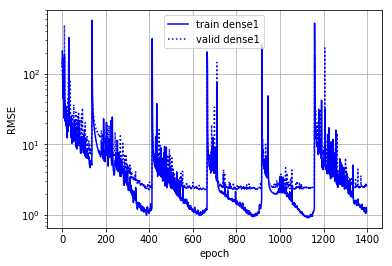

In [17]:
plot_loss([model1_hist],['dense1'])

In [18]:
model1BN = Sequential()
model1BN.add(Flatten(input_shape=INPUT_SHAPE))
model1BN.add(Dense(100, activation='relu'))
model1BN.add(BatchNormalization())
model1BN.add(Dense(30))
print(model1BN.summary())
model1BN_hist, model1BN = fit_model(model1BN,data,
                                    '1dense100neuronlayer_wbatchnormalization')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               921700    
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_8 (Dense)              (None, 30)                3030      
Total params: 925,130
Trainable params: 924,930
Non-trainable params: 200
_________________________________________________________________
None
Train on 1712 samples, validate on 428 samples
Epoch 1/10000
1712/1712 [==============================] - 1s 400us/step - loss: 0.3694 - val_loss: 0.0674
Epoch 2/10000
1712/1712 [==============================] - 0s 244us/step - loss: 0.0256 - val_loss: 0.0199


1712/1712 [==============================] - 0s 264us/step - loss: 0.0017 - val_loss: 0.0035
Epoch 69/10000
1712/1712 [==============================] - 0s 241us/step - loss: 0.0020 - val_loss: 0.0028
Epoch 70/10000
1712/1712 [==============================] - 0s 236us/step - loss: 0.0018 - val_loss: 0.0036
Epoch 71/10000
1712/1712 [==============================] - 0s 235us/step - loss: 0.0019 - val_loss: 0.0040
Epoch 72/10000
1712/1712 [==============================] - 0s 228us/step - loss: 0.0016 - val_loss: 0.0048
Epoch 73/10000
1712/1712 [==============================] - 0s 276us/step - loss: 0.0019 - val_loss: 0.0030
Epoch 74/10000
1712/1712 [==============================] - 0s 267us/step - loss: 0.0016 - val_loss: 0.0033
Epoch 75/10000
1712/1712 [==============================] - 0s 274us/step - loss: 0.0016 - val_loss: 0.0029
Epoch 76/10000
1712/1712 [==============================] - 0s 270us/step - loss: 0.0020 - val_loss: 0.0039
Epoch 77/10000
1712/1712 [=================

1712/1712 [==============================] - 0s 243us/step - loss: 0.0010 - val_loss: 0.0033
Epoch 144/10000
1712/1712 [==============================] - 0s 283us/step - loss: 0.0012 - val_loss: 0.0032
Epoch 145/10000
1712/1712 [==============================] - 0s 272us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 146/10000
1712/1712 [==============================] - 0s 234us/step - loss: 0.0010 - val_loss: 0.0025
Epoch 147/10000
1712/1712 [==============================] - 0s 263us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 148/10000
1712/1712 [==============================] - 0s 249us/step - loss: 0.0012 - val_loss: 0.0037
Epoch 149/10000
1712/1712 [==============================] - 0s 282us/step - loss: 0.0011 - val_loss: 0.0025
Epoch 150/10000
1712/1712 [==============================] - 0s 280us/step - loss: 0.0013 - val_loss: 0.0034
Epoch 151/10000
1712/1712 [==============================] - 0s 270us/step - loss: 0.0012 - val_loss: 0.0026
Epoch 152/10000
1712/1712 [========

1712/1712 [==============================] - 0s 257us/step - loss: 8.5641e-04 - val_loss: 0.0025
Epoch 218/10000
1712/1712 [==============================] - 0s 232us/step - loss: 8.9939e-04 - val_loss: 0.0029
Epoch 219/10000
1712/1712 [==============================] - 0s 250us/step - loss: 8.3581e-04 - val_loss: 0.0027
Epoch 220/10000
1712/1712 [==============================] - 0s 257us/step - loss: 8.1541e-04 - val_loss: 0.0036
Epoch 221/10000
1712/1712 [==============================] - 1s 294us/step - loss: 0.0013 - val_loss: 0.0037
Epoch 222/10000
1712/1712 [==============================] - 0s 257us/step - loss: 9.0175e-04 - val_loss: 0.0026
Epoch 223/10000
1712/1712 [==============================] - 0s 238us/step - loss: 9.2723e-04 - val_loss: 0.0027
Epoch 224/10000
1712/1712 [==============================] - 0s 250us/step - loss: 9.9570e-04 - val_loss: 0.0026
Epoch 225/10000
1712/1712 [==============================] - 0s 229us/step - loss: 8.6741e-04 - val_loss: 0.0027
Epo

1712/1712 [==============================] - 3s 2ms/step - loss: 7.2443e-04 - val_loss: 0.0024
Epoch 291/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 7.1955e-04 - val_loss: 0.0023
Epoch 292/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 6.9378e-04 - val_loss: 0.0027
Epoch 293/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 6.7849e-04 - val_loss: 0.0026: 0s - loss: 6.85
Epoch 294/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 6.9366e-04 - val_loss: 0.0022
Epoch 295/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 6.6917e-04 - val_loss: 0.0022
Epoch 296/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 8.2977e-04 - val_loss: 0.0025
Epoch 297/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 7.7136e-04 - val_loss: 0.0026
Epoch 298/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 6.7361e-04 - val_loss: 0.0027


Epoch 364/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 6.7762e-04 - val_loss: 0.0023
Epoch 365/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 6.1210e-04 - val_loss: 0.0023
Epoch 366/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 6.4657e-04 - val_loss: 0.0023
Epoch 367/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 6.1322e-04 - val_loss: 0.0025
Epoch 368/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 7.0400e-04 - val_loss: 0.0023
Epoch 369/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 5.8542e-04 - val_loss: 0.0022
Epoch 370/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 6.2204e-04 - val_loss: 0.0023
Epoch 371/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 6.4126e-04 - val_loss: 0.0026
Epoch 372/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 6.4583e-04 - val_loss: 0.0022
E

Epoch 438/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 5.1250e-04 - val_loss: 0.0021
Epoch 439/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 5.0369e-04 - val_loss: 0.0023
Epoch 440/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 5.1411e-04 - val_loss: 0.0022
Epoch 441/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 5.1459e-04 - val_loss: 0.0023
Epoch 442/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 5.1559e-04 - val_loss: 0.0022
Epoch 443/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 5.2158e-04 - val_loss: 0.0025
Epoch 444/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 5.3693e-04 - val_loss: 0.0023
Epoch 445/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 5.0082e-04 - val_loss: 0.0023
Epoch 446/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 4.7416e-04 - val_loss: 0.0022
E

Epoch 512/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 4.7934e-04 - val_loss: 0.0024
Epoch 513/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 5.3554e-04 - val_loss: 0.0022
Epoch 514/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 4.6605e-04 - val_loss: 0.0022
Epoch 515/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 4.0575e-04 - val_loss: 0.0022
Epoch 516/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 4.4241e-04 - val_loss: 0.0023
Epoch 517/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 4.5628e-04 - val_loss: 0.0021
Epoch 518/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 4.5407e-04 - val_loss: 0.0022
Epoch 519/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 4.3854e-04 - val_loss: 0.0023
Epoch 520/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 4.1290e-04 - val_loss: 0.0022
E

1712/1712 [==============================] - 3s 2ms/step - loss: 3.8639e-04 - val_loss: 0.0022
Epoch 586/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.5466e-04 - val_loss: 0.0022
Epoch 587/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 4.0693e-04 - val_loss: 0.0022
Epoch 588/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.8421e-04 - val_loss: 0.0022
Epoch 589/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.8401e-04 - val_loss: 0.0022
Epoch 590/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.8972e-04 - val_loss: 0.0022
Epoch 591/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.8514e-04 - val_loss: 0.0022
Epoch 592/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 4.0322e-04 - val_loss: 0.0021
Epoch 593/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.7635e-04 - val_loss: 0.0021
Epoch 594/10000
1

Epoch 659/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.5107e-04 - val_loss: 0.0021
Epoch 660/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.4173e-04 - val_loss: 0.0021
Epoch 661/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.2886e-04 - val_loss: 0.0021
Epoch 662/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.4239e-04 - val_loss: 0.0021
Epoch 663/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.6593e-04 - val_loss: 0.0021
Epoch 664/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.5121e-04 - val_loss: 0.0021
Epoch 665/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.5152e-04 - val_loss: 0.0021
Epoch 666/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.3739e-04 - val_loss: 0.0021
Epoch 667/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.4792e-04 - val_loss: 0.0021
E

1712/1712 [==============================] - 3s 2ms/step - loss: 3.1622e-04 - val_loss: 0.0021
Epoch 733/10000
1712/1712 [==============================] - 4s 2ms/step - loss: 2.9599e-04 - val_loss: 0.0021
Epoch 734/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.3161e-04 - val_loss: 0.0021
Epoch 735/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.4641e-04 - val_loss: 0.0020
Epoch 736/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.1979e-04 - val_loss: 0.0020
Epoch 737/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.3987e-04 - val_loss: 0.0021
Epoch 738/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.9746e-04 - val_loss: 0.0021
Epoch 739/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.8632e-04 - val_loss: 0.0021
Epoch 740/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.9060e-04 - val_loss: 0.0022
Epoch 741/10000
1

Epoch 806/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.7578e-04 - val_loss: 0.0021
Epoch 807/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.0763e-04 - val_loss: 0.0021
Epoch 808/10000
1712/1712 [==============================] - 4s 2ms/step - loss: 2.6994e-04 - val_loss: 0.0021
Epoch 809/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.7671e-04 - val_loss: 0.0021
Epoch 810/10000
1712/1712 [==============================] - 4s 2ms/step - loss: 2.9232e-04 - val_loss: 0.0020
Epoch 811/10000
1712/1712 [==============================] - 4s 2ms/step - loss: 2.9094e-04 - val_loss: 0.0021
Epoch 812/10000
1712/1712 [==============================] - 4s 2ms/step - loss: 2.8125e-04 - val_loss: 0.0021
Epoch 813/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.0029e-04 - val_loss: 0.0020
Epoch 814/10000
1712/1712 [==============================] - 4s 2ms/step - loss: 2.7311e-04 - val_loss: 0.0020
E

1712/1712 [==============================] - 0s 271us/step - loss: 2.6805e-04 - val_loss: 0.0021
Epoch 879/10000
1712/1712 [==============================] - 0s 261us/step - loss: 2.9013e-04 - val_loss: 0.0021
Epoch 880/10000
1712/1712 [==============================] - 0s 266us/step - loss: 2.7535e-04 - val_loss: 0.0021
Epoch 881/10000
1712/1712 [==============================] - 0s 279us/step - loss: 2.9062e-04 - val_loss: 0.0021
Epoch 882/10000
1712/1712 [==============================] - 0s 256us/step - loss: 2.7847e-04 - val_loss: 0.0021
Epoch 883/10000
1712/1712 [==============================] - 1s 317us/step - loss: 2.5311e-04 - val_loss: 0.0021
Epoch 884/10000
1712/1712 [==============================] - 0s 285us/step - loss: 2.5858e-04 - val_loss: 0.0021
Epoch 885/10000
1712/1712 [==============================] - 0s 267us/step - loss: 2.7878e-04 - val_loss: 0.0021
Epoch 886/10000
1712/1712 [==============================] - 0s 266us/step - loss: 2.7457e-04 - val_loss: 0.0020

1712/1712 [==============================] - 0s 254us/step - loss: 2.6028e-04 - val_loss: 0.0021
Epoch 951/10000
1712/1712 [==============================] - 0s 259us/step - loss: 2.7731e-04 - val_loss: 0.0021
Epoch 952/10000
1712/1712 [==============================] - 0s 261us/step - loss: 2.3304e-04 - val_loss: 0.0021
Epoch 953/10000
1712/1712 [==============================] - 0s 248us/step - loss: 2.5253e-04 - val_loss: 0.0021
Epoch 954/10000
1712/1712 [==============================] - 0s 255us/step - loss: 2.7133e-04 - val_loss: 0.0021
Epoch 955/10000
1712/1712 [==============================] - 0s 260us/step - loss: 2.7166e-04 - val_loss: 0.0021
Epoch 956/10000
1712/1712 [==============================] - 0s 256us/step - loss: 2.8496e-04 - val_loss: 0.0021
Epoch 957/10000
1712/1712 [==============================] - 0s 268us/step - loss: 2.7390e-04 - val_loss: 0.0021
Epoch 958/10000
1712/1712 [==============================] - 0s 257us/step - loss: 2.6876e-04 - val_loss: 0.0021

1712/1712 [==============================] - 0s 254us/step - loss: 2.6155e-04 - val_loss: 0.0021
Epoch 1023/10000
1712/1712 [==============================] - 0s 251us/step - loss: 2.6046e-04 - val_loss: 0.0021
Epoch 1024/10000
1712/1712 [==============================] - 0s 250us/step - loss: 2.8161e-04 - val_loss: 0.0021
Epoch 1025/10000
1712/1712 [==============================] - 0s 253us/step - loss: 2.4850e-04 - val_loss: 0.0021
Epoch 1026/10000
1712/1712 [==============================] - 0s 257us/step - loss: 2.5968e-04 - val_loss: 0.0021
Epoch 1027/10000
1712/1712 [==============================] - 0s 263us/step - loss: 2.4971e-04 - val_loss: 0.0021
Epoch 1028/10000
1712/1712 [==============================] - 0s 275us/step - loss: 2.3341e-04 - val_loss: 0.0021
Epoch 1029/10000
1712/1712 [==============================] - 0s 253us/step - loss: 2.6931e-04 - val_loss: 0.0021
Epoch 1030/10000
1712/1712 [==============================] - 0s 263us/step - loss: 2.5576e-04 - val_loss

1712/1712 [==============================] - 0s 237us/step - loss: 2.3617e-04 - val_loss: 0.0021
Epoch 1095/10000
1712/1712 [==============================] - 0s 234us/step - loss: 2.4805e-04 - val_loss: 0.0021
Epoch 1096/10000
1712/1712 [==============================] - 0s 241us/step - loss: 2.6104e-04 - val_loss: 0.0021
Epoch 1097/10000
1712/1712 [==============================] - 0s 264us/step - loss: 2.4775e-04 - val_loss: 0.0021
Epoch 1098/10000
1712/1712 [==============================] - 0s 280us/step - loss: 2.3609e-04 - val_loss: 0.0021
Epoch 1099/10000
1712/1712 [==============================] - 0s 264us/step - loss: 2.4262e-04 - val_loss: 0.0021
Epoch 1100/10000
1712/1712 [==============================] - 0s 284us/step - loss: 2.4162e-04 - val_loss: 0.0021
Epoch 1101/10000
1712/1712 [==============================] - 0s 281us/step - loss: 2.3564e-04 - val_loss: 0.0021
Epoch 1102/10000
1712/1712 [==============================] - 0s 282us/step - loss: 2.3579e-04 - val_loss

1712/1712 [==============================] - 0s 261us/step - loss: 2.4823e-04 - val_loss: 0.0021
Epoch 1167/10000
1712/1712 [==============================] - 0s 272us/step - loss: 2.5464e-04 - val_loss: 0.0021
Epoch 1168/10000
1712/1712 [==============================] - 0s 253us/step - loss: 2.3932e-04 - val_loss: 0.0021
Epoch 1169/10000
1712/1712 [==============================] - 0s 258us/step - loss: 2.3068e-04 - val_loss: 0.0021
Epoch 1170/10000
1712/1712 [==============================] - 0s 254us/step - loss: 2.4776e-04 - val_loss: 0.0021
Epoch 1171/10000
1712/1712 [==============================] - 0s 246us/step - loss: 2.5250e-04 - val_loss: 0.0021
Epoch 1172/10000
1712/1712 [==============================] - 0s 249us/step - loss: 2.1110e-04 - val_loss: 0.0021
Epoch 1173/10000
1712/1712 [==============================] - 0s 255us/step - loss: 2.4241e-04 - val_loss: 0.0021
Epoch 1174/10000
1712/1712 [==============================] - 0s 243us/step - loss: 2.4423e-04 - val_loss

1712/1712 [==============================] - 0s 256us/step - loss: 2.4098e-04 - val_loss: 0.0020
Epoch 1239/10000
1712/1712 [==============================] - 0s 257us/step - loss: 2.3399e-04 - val_loss: 0.0021
Epoch 1240/10000
1712/1712 [==============================] - 0s 266us/step - loss: 2.2082e-04 - val_loss: 0.0021
Epoch 1241/10000
1712/1712 [==============================] - 0s 285us/step - loss: 2.3300e-04 - val_loss: 0.0020
Epoch 1242/10000
1712/1712 [==============================] - 0s 291us/step - loss: 2.4629e-04 - val_loss: 0.0021
Epoch 1243/10000
1712/1712 [==============================] - 0s 253us/step - loss: 2.3411e-04 - val_loss: 0.0021
Epoch 1244/10000
1712/1712 [==============================] - 0s 257us/step - loss: 2.6037e-04 - val_loss: 0.0021
Epoch 1245/10000
1712/1712 [==============================] - 0s 261us/step - loss: 2.3813e-04 - val_loss: 0.0021
Epoch 1246/10000
1712/1712 [==============================] - 0s 258us/step - loss: 2.5358e-04 - val_loss

1712/1712 [==============================] - 0s 273us/step - loss: 2.3082e-04 - val_loss: 0.0021
Epoch 1311/10000
1712/1712 [==============================] - 0s 254us/step - loss: 2.4871e-04 - val_loss: 0.0021
Epoch 1312/10000
1712/1712 [==============================] - 0s 253us/step - loss: 2.3208e-04 - val_loss: 0.0020
Epoch 1313/10000
1712/1712 [==============================] - 0s 261us/step - loss: 2.4561e-04 - val_loss: 0.0021
Epoch 1314/10000
1712/1712 [==============================] - 0s 262us/step - loss: 2.4354e-04 - val_loss: 0.0021
Epoch 1315/10000
1712/1712 [==============================] - 0s 268us/step - loss: 2.4767e-04 - val_loss: 0.0021
Epoch 1316/10000
1712/1712 [==============================] - 0s 265us/step - loss: 2.3229e-04 - val_loss: 0.0021
Epoch 1317/10000
1712/1712 [==============================] - 0s 265us/step - loss: 2.4130e-04 - val_loss: 0.0021
Epoch 1318/10000
1712/1712 [==============================] - 0s 264us/step - loss: 2.8060e-04 - val_loss

1712/1712 [==============================] - 0s 256us/step - loss: 2.7039e-04 - val_loss: 0.0021
Epoch 1383/10000
1712/1712 [==============================] - 0s 266us/step - loss: 2.3731e-04 - val_loss: 0.0021
Epoch 1384/10000
1712/1712 [==============================] - 0s 240us/step - loss: 2.3321e-04 - val_loss: 0.0021
Epoch 1385/10000
1712/1712 [==============================] - 0s 255us/step - loss: 2.2043e-04 - val_loss: 0.0020
Epoch 1386/10000
1712/1712 [==============================] - 1s 293us/step - loss: 2.3220e-04 - val_loss: 0.0021
Epoch 1387/10000
1712/1712 [==============================] - 0s 254us/step - loss: 2.1752e-04 - val_loss: 0.0021
Epoch 1388/10000
1712/1712 [==============================] - 0s 245us/step - loss: 2.2673e-04 - val_loss: 0.0020
Epoch 1389/10000
1712/1712 [==============================] - 0s 231us/step - loss: 2.4772e-04 - val_loss: 0.0020
Epoch 1390/10000
1712/1712 [==============================] - 0s 270us/step - loss: 2.1152e-04 - val_loss

1712/1712 [==============================] - 0s 264us/step - loss: 2.2101e-04 - val_loss: 0.0021
Epoch 1455/10000
1712/1712 [==============================] - 0s 270us/step - loss: 2.2478e-04 - val_loss: 0.0021
Epoch 1456/10000
1712/1712 [==============================] - 0s 256us/step - loss: 2.5355e-04 - val_loss: 0.0021
Epoch 1457/10000
1712/1712 [==============================] - 0s 268us/step - loss: 2.3051e-04 - val_loss: 0.0020
Epoch 1458/10000
1712/1712 [==============================] - 0s 264us/step - loss: 2.2427e-04 - val_loss: 0.0020
Epoch 1459/10000
1712/1712 [==============================] - 0s 273us/step - loss: 2.4937e-04 - val_loss: 0.0021
Epoch 1460/10000
1712/1712 [==============================] - 0s 269us/step - loss: 2.1318e-04 - val_loss: 0.0020
Epoch 1461/10000
1712/1712 [==============================] - 0s 254us/step - loss: 2.3822e-04 - val_loss: 0.0021
Epoch 1462/10000
1712/1712 [==============================] - 0s 245us/step - loss: 2.5089e-04 - val_loss

1712/1712 [==============================] - 0s 252us/step - loss: 2.3250e-04 - val_loss: 0.0021
Epoch 1527/10000
1712/1712 [==============================] - 0s 258us/step - loss: 2.5072e-04 - val_loss: 0.0020
Epoch 1528/10000
1712/1712 [==============================] - 0s 260us/step - loss: 2.3086e-04 - val_loss: 0.0021
Epoch 1529/10000
1712/1712 [==============================] - 0s 222us/step - loss: 2.3176e-04 - val_loss: 0.0021
Epoch 1530/10000
1712/1712 [==============================] - 0s 254us/step - loss: 2.2670e-04 - val_loss: 0.0021
Epoch 1531/10000
1712/1712 [==============================] - 0s 234us/step - loss: 2.0912e-04 - val_loss: 0.0021
Epoch 1532/10000
1712/1712 [==============================] - 0s 261us/step - loss: 2.2509e-04 - val_loss: 0.0021
Epoch 1533/10000
1712/1712 [==============================] - 0s 247us/step - loss: 2.3602e-04 - val_loss: 0.0021
Epoch 1534/10000
1712/1712 [==============================] - 0s 261us/step - loss: 2.3752e-04 - val_loss

1712/1712 [==============================] - 0s 258us/step - loss: 2.1928e-04 - val_loss: 0.0021
Epoch 1598/10000
1712/1712 [==============================] - 0s 226us/step - loss: 2.3797e-04 - val_loss: 0.0021
Epoch 1599/10000
1712/1712 [==============================] - 0s 244us/step - loss: 2.3166e-04 - val_loss: 0.0021
Epoch 1600/10000
1712/1712 [==============================] - 0s 243us/step - loss: 2.1785e-04 - val_loss: 0.0021
Epoch 1601/10000
1712/1712 [==============================] - 0s 282us/step - loss: 2.1636e-04 - val_loss: 0.0021
Epoch 1602/10000
1712/1712 [==============================] - 0s 284us/step - loss: 2.3199e-04 - val_loss: 0.0020
Epoch 1603/10000
1712/1712 [==============================] - 1s 298us/step - loss: 2.4548e-04 - val_loss: 0.0021
Epoch 1604/10000
1712/1712 [==============================] - 0s 245us/step - loss: 2.0924e-04 - val_loss: 0.0021
Epoch 1605/10000
1712/1712 [==============================] - 0s 253us/step - loss: 2.5221e-04 - val_loss

1712/1712 [==============================] - 0s 262us/step - loss: 2.2271e-04 - val_loss: 0.0021
Epoch 1670/10000
1712/1712 [==============================] - 0s 243us/step - loss: 2.0303e-04 - val_loss: 0.0021
Epoch 1671/10000
1712/1712 [==============================] - 0s 256us/step - loss: 2.3838e-04 - val_loss: 0.0021
Epoch 1672/10000
1712/1712 [==============================] - 0s 283us/step - loss: 2.6402e-04 - val_loss: 0.0021
Epoch 1673/10000
1712/1712 [==============================] - 0s 242us/step - loss: 2.1653e-04 - val_loss: 0.0021
Epoch 1674/10000
1712/1712 [==============================] - 0s 261us/step - loss: 2.3626e-04 - val_loss: 0.0021
Epoch 1675/10000
1712/1712 [==============================] - 0s 263us/step - loss: 2.2654e-04 - val_loss: 0.0021
Epoch 1676/10000
1712/1712 [==============================] - 0s 245us/step - loss: 2.2121e-04 - val_loss: 0.0021
Epoch 1677/10000
1712/1712 [==============================] - 0s 233us/step - loss: 2.3415e-04 - val_loss

1712/1712 [==============================] - 0s 269us/step - loss: 2.2166e-04 - val_loss: 0.0021
Epoch 1742/10000
1712/1712 [==============================] - 0s 266us/step - loss: 2.2216e-04 - val_loss: 0.0021
Epoch 1743/10000
1712/1712 [==============================] - 0s 252us/step - loss: 2.0585e-04 - val_loss: 0.0021
Epoch 1744/10000
1712/1712 [==============================] - 0s 284us/step - loss: 2.3257e-04 - val_loss: 0.0021
Epoch 1745/10000
1712/1712 [==============================] - 0s 251us/step - loss: 2.3296e-04 - val_loss: 0.0021
Epoch 1746/10000
1712/1712 [==============================] - 0s 256us/step - loss: 2.0122e-04 - val_loss: 0.0021
Epoch 1747/10000
1712/1712 [==============================] - 0s 260us/step - loss: 2.3394e-04 - val_loss: 0.0021
Epoch 1748/10000
1712/1712 [==============================] - 0s 268us/step - loss: 2.3704e-04 - val_loss: 0.0021
Epoch 1749/10000
1712/1712 [==============================] - 0s 267us/step - loss: 2.2679e-04 - val_loss

1712/1712 [==============================] - 0s 248us/step - loss: 2.4254e-04 - val_loss: 0.0021
Epoch 1814/10000
1712/1712 [==============================] - 0s 254us/step - loss: 2.3196e-04 - val_loss: 0.0021
Epoch 1815/10000
1712/1712 [==============================] - 0s 286us/step - loss: 2.0998e-04 - val_loss: 0.0021
Epoch 1816/10000
1712/1712 [==============================] - 0s 280us/step - loss: 2.3485e-04 - val_loss: 0.0021
Epoch 1817/10000
1712/1712 [==============================] - 0s 260us/step - loss: 2.2238e-04 - val_loss: 0.0021
Epoch 1818/10000
1712/1712 [==============================] - 0s 258us/step - loss: 2.2545e-04 - val_loss: 0.0021
Epoch 1819/10000
1712/1712 [==============================] - 0s 253us/step - loss: 2.2444e-04 - val_loss: 0.0021
Epoch 1820/10000
1712/1712 [==============================] - 1s 292us/step - loss: 2.0128e-04 - val_loss: 0.0021
Epoch 1821/10000
1712/1712 [==============================] - 0s 250us/step - loss: 2.3816e-04 - val_loss

1712/1712 [==============================] - 0s 242us/step - loss: 2.1676e-04 - val_loss: 0.0021
Epoch 1886/10000
1712/1712 [==============================] - 0s 234us/step - loss: 2.1828e-04 - val_loss: 0.0021
Epoch 1887/10000
1712/1712 [==============================] - 0s 275us/step - loss: 2.0175e-04 - val_loss: 0.0021
Epoch 1888/10000
1712/1712 [==============================] - 0s 241us/step - loss: 2.1505e-04 - val_loss: 0.0021
Epoch 1889/10000
1712/1712 [==============================] - 0s 284us/step - loss: 2.0778e-04 - val_loss: 0.0021
Epoch 1890/10000
1712/1712 [==============================] - 0s 266us/step - loss: 2.1111e-04 - val_loss: 0.0021
Epoch 1891/10000
1712/1712 [==============================] - 0s 244us/step - loss: 2.2370e-04 - val_loss: 0.0021
Epoch 1892/10000
1712/1712 [==============================] - 0s 254us/step - loss: 2.1769e-04 - val_loss: 0.0021
Epoch 1893/10000
1712/1712 [==============================] - 0s 267us/step - loss: 2.2872e-04 - val_loss

1712/1712 [==============================] - 0s 275us/step - loss: 2.1932e-04 - val_loss: 0.0021
Epoch 1958/10000
1712/1712 [==============================] - 0s 251us/step - loss: 2.3164e-04 - val_loss: 0.0021
Epoch 1959/10000
1712/1712 [==============================] - 0s 249us/step - loss: 2.1761e-04 - val_loss: 0.0021
Epoch 1960/10000
1712/1712 [==============================] - 0s 248us/step - loss: 2.3008e-04 - val_loss: 0.0021
Epoch 1961/10000
1712/1712 [==============================] - 0s 253us/step - loss: 2.1733e-04 - val_loss: 0.0021
Epoch 1962/10000
1712/1712 [==============================] - 0s 287us/step - loss: 2.3323e-04 - val_loss: 0.0021
Epoch 1963/10000
1712/1712 [==============================] - 0s 238us/step - loss: 2.2242e-04 - val_loss: 0.0021
Epoch 1964/10000
1712/1712 [==============================] - 0s 275us/step - loss: 2.2633e-04 - val_loss: 0.0021
Epoch 1965/10000
1712/1712 [==============================] - 0s 252us/step - loss: 2.4318e-04 - val_loss

1712/1712 [==============================] - 0s 263us/step - loss: 2.1614e-04 - val_loss: 0.0021
Epoch 2029/10000
1712/1712 [==============================] - 0s 254us/step - loss: 2.1261e-04 - val_loss: 0.0021
Epoch 2030/10000
1712/1712 [==============================] - 1s 295us/step - loss: 2.2147e-04 - val_loss: 0.0021
Epoch 2031/10000
1712/1712 [==============================] - 0s 267us/step - loss: 2.3711e-04 - val_loss: 0.0021
Epoch 2032/10000
1712/1712 [==============================] - 0s 283us/step - loss: 2.1808e-04 - val_loss: 0.0021
Epoch 2033/10000
1712/1712 [==============================] - 0s 243us/step - loss: 2.0366e-04 - val_loss: 0.0021
Epoch 2034/10000
1712/1712 [==============================] - 0s 255us/step - loss: 2.0992e-04 - val_loss: 0.0020
Epoch 2035/10000
1712/1712 [==============================] - 0s 240us/step - loss: 2.0929e-04 - val_loss: 0.0021
Epoch 2036/10000
1712/1712 [==============================] - 0s 272us/step - loss: 2.0749e-04 - val_loss

1712/1712 [==============================] - 0s 272us/step - loss: 2.0352e-04 - val_loss: 0.0021
Epoch 2101/10000
1712/1712 [==============================] - 0s 241us/step - loss: 2.0284e-04 - val_loss: 0.0021
Epoch 2102/10000
1712/1712 [==============================] - 0s 261us/step - loss: 2.1207e-04 - val_loss: 0.0021
Epoch 2103/10000
1712/1712 [==============================] - 0s 276us/step - loss: 2.1629e-04 - val_loss: 0.0021
Epoch 2104/10000
1712/1712 [==============================] - 0s 252us/step - loss: 2.0929e-04 - val_loss: 0.0021
Epoch 2105/10000
1712/1712 [==============================] - 0s 274us/step - loss: 2.1885e-04 - val_loss: 0.0021
Epoch 2106/10000
1712/1712 [==============================] - 0s 280us/step - loss: 2.2394e-04 - val_loss: 0.0021
Epoch 2107/10000
1712/1712 [==============================] - 0s 274us/step - loss: 2.2022e-04 - val_loss: 0.0021
Epoch 2108/10000
1712/1712 [==============================] - 0s 235us/step - loss: 2.0404e-04 - val_loss

1712/1712 [==============================] - 0s 254us/step - loss: 2.0201e-04 - val_loss: 0.0021
Epoch 2173/10000
1712/1712 [==============================] - 0s 243us/step - loss: 2.0725e-04 - val_loss: 0.0021
Epoch 2174/10000
1712/1712 [==============================] - 0s 251us/step - loss: 2.0765e-04 - val_loss: 0.0021
Epoch 2175/10000
1712/1712 [==============================] - 0s 254us/step - loss: 2.2533e-04 - val_loss: 0.0021
Epoch 2176/10000
1712/1712 [==============================] - 0s 244us/step - loss: 2.1402e-04 - val_loss: 0.0021
Epoch 2177/10000
1712/1712 [==============================] - 0s 272us/step - loss: 2.2276e-04 - val_loss: 0.0021
Epoch 2178/10000
1712/1712 [==============================] - 0s 254us/step - loss: 2.0324e-04 - val_loss: 0.0021
Epoch 2179/10000
1712/1712 [==============================] - 0s 244us/step - loss: 2.1386e-04 - val_loss: 0.0021
Epoch 2180/10000
1712/1712 [==============================] - 0s 242us/step - loss: 1.9405e-04 - val_loss

1712/1712 [==============================] - 0s 266us/step - loss: 2.0982e-04 - val_loss: 0.0020
Epoch 2245/10000
1712/1712 [==============================] - 0s 271us/step - loss: 2.4103e-04 - val_loss: 0.0021
Epoch 2246/10000
1712/1712 [==============================] - 0s 263us/step - loss: 2.3233e-04 - val_loss: 0.0021
Epoch 2247/10000
1712/1712 [==============================] - 0s 282us/step - loss: 2.1619e-04 - val_loss: 0.0021
Epoch 2248/10000
1712/1712 [==============================] - 0s 243us/step - loss: 2.0835e-04 - val_loss: 0.0021
Epoch 2249/10000
1712/1712 [==============================] - 0s 242us/step - loss: 2.0466e-04 - val_loss: 0.0021
Epoch 2250/10000
1712/1712 [==============================] - 0s 261us/step - loss: 2.2253e-04 - val_loss: 0.0021
Epoch 2251/10000
1712/1712 [==============================] - 0s 274us/step - loss: 2.1504e-04 - val_loss: 0.0021
Epoch 2252/10000
1712/1712 [==============================] - 0s 264us/step - loss: 2.1429e-04 - val_loss

1712/1712 [==============================] - 0s 234us/step - loss: 2.2242e-04 - val_loss: 0.0021
Epoch 2317/10000
1712/1712 [==============================] - 0s 242us/step - loss: 2.1840e-04 - val_loss: 0.0021
Epoch 2318/10000
1712/1712 [==============================] - 0s 263us/step - loss: 2.3362e-04 - val_loss: 0.0021
Epoch 2319/10000
1712/1712 [==============================] - 0s 244us/step - loss: 2.2609e-04 - val_loss: 0.0021
Epoch 2320/10000
1712/1712 [==============================] - 0s 270us/step - loss: 2.1256e-04 - val_loss: 0.0021
Epoch 2321/10000
1712/1712 [==============================] - 0s 266us/step - loss: 2.1582e-04 - val_loss: 0.0021
Epoch 2322/10000
1712/1712 [==============================] - 0s 275us/step - loss: 2.2851e-04 - val_loss: 0.0021
Epoch 2323/10000
1712/1712 [==============================] - 0s 237us/step - loss: 2.1992e-04 - val_loss: 0.0021
Epoch 2324/10000
1712/1712 [==============================] - 0s 257us/step - loss: 1.9085e-04 - val_loss

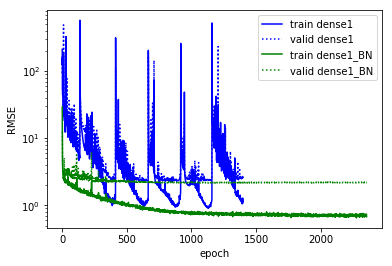

In [19]:
plot_loss([model1_hist,model1BN_hist],['dense1','dense1_BN'])

### Model with convolutions

In [20]:
model2 = Sequential()
model2.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(500, activation = "relu"))
model2.add(BatchNormalization())
model2.add(Dense(100, activation = "relu"))
model2.add(BatchNormalization())
model2.add(Dense(30))
print(model2.summary())

model2_hist, model2 = fit_model(model2,data,
                                    'CNN')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        8256      
_________________________________________________________________
batch_normalization_3 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 128)       32896     
__________

Epoch 56/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 57/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 58/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 59/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 60/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 61/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 62/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 63/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 64/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 65/10000
1712/1712 [====================

1712/1712 [==============================] - 3s 2ms/step - loss: 8.4312e-04 - val_loss: 0.0014
Epoch 132/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 7.4667e-04 - val_loss: 0.0026
Epoch 133/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 8.4242e-04 - val_loss: 0.0019
Epoch 134/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 8.7205e-04 - val_loss: 0.0016
Epoch 135/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 8.3147e-04 - val_loss: 0.0023
Epoch 136/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 8.1466e-04 - val_loss: 0.0014
Epoch 137/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 7.3407e-04 - val_loss: 0.0015
Epoch 138/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 7.2249e-04 - val_loss: 0.0017
Epoch 139/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 7.7616e-04 - val_loss: 0.0018
Epoch 140/10000
1

Epoch 205/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 5.9722e-04 - val_loss: 0.0014
Epoch 206/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 5.7043e-04 - val_loss: 0.0012
Epoch 207/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 5.3122e-04 - val_loss: 0.0011
Epoch 208/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 5.2451e-04 - val_loss: 0.0014
Epoch 209/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 4.8376e-04 - val_loss: 0.0014
Epoch 210/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 5.2154e-04 - val_loss: 0.0014
Epoch 211/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 4.9841e-04 - val_loss: 0.0012
Epoch 212/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 5.3026e-04 - val_loss: 0.0012
Epoch 213/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 5.2164e-04 - val_loss: 0.0013
E

Epoch 279/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.9781e-04 - val_loss: 0.0011
Epoch 280/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 4.1051e-04 - val_loss: 0.0011
Epoch 281/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.9378e-04 - val_loss: 0.0011
Epoch 282/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 4.1715e-04 - val_loss: 0.0011
Epoch 283/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 4.4176e-04 - val_loss: 0.0113
Epoch 284/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 4.9481e-04 - val_loss: 0.0013
Epoch 285/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 4.6161e-04 - val_loss: 0.0011
Epoch 286/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 4.2058e-04 - val_loss: 0.0013
Epoch 287/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 4.3491e-04 - val_loss: 0.0011
E

1712/1712 [==============================] - 3s 1ms/step - loss: 3.1322e-04 - val_loss: 0.0011
Epoch 353/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.3754e-04 - val_loss: 0.0011
Epoch 354/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.3407e-04 - val_loss: 0.0010
Epoch 355/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.5842e-04 - val_loss: 0.0012
Epoch 356/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.6238e-04 - val_loss: 0.0011
Epoch 357/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.4335e-04 - val_loss: 0.0011
Epoch 358/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.4681e-04 - val_loss: 0.0013
Epoch 359/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.7726e-04 - val_loss: 9.8417e-04
Epoch 360/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 4.4001e-04 - val_loss: 0.0018
Epoch 361/100

1712/1712 [==============================] - 3s 2ms/step - loss: 3.2677e-04 - val_loss: 0.0011
Epoch 426/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.1470e-04 - val_loss: 0.0011
Epoch 427/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.9963e-04 - val_loss: 9.6585e-04
Epoch 428/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.1215e-04 - val_loss: 9.5411e-04
Epoch 429/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.9518e-04 - val_loss: 9.6762e-04
Epoch 430/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.0348e-04 - val_loss: 0.0011
Epoch 431/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.3494e-04 - val_loss: 0.0010
Epoch 432/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.9694e-04 - val_loss: 9.8081e-04
Epoch 433/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.8054e-04 - val_loss: 9.6173e-

1712/1712 [==============================] - 3s 2ms/step - loss: 2.9671e-04 - val_loss: 9.2860e-04
Epoch 498/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.7381e-04 - val_loss: 9.4972e-04
Epoch 499/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.7672e-04 - val_loss: 0.0010
Epoch 500/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.5514e-04 - val_loss: 9.5044e-04
Epoch 501/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.7213e-04 - val_loss: 9.4590e-04
Epoch 502/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.5868e-04 - val_loss: 0.0010
Epoch 503/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.9558e-04 - val_loss: 0.0013
Epoch 504/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.8978e-04 - val_loss: 9.9729e-04
Epoch 505/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.6534e-04 - val_loss: 9.23

Epoch 569/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.8142e-04 - val_loss: 9.1654e-04
Epoch 570/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.7848e-04 - val_loss: 9.0267e-04
Epoch 571/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.6083e-04 - val_loss: 9.4862e-04
Epoch 572/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.5252e-04 - val_loss: 9.2654e-04
Epoch 573/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.4299e-04 - val_loss: 9.4149e-04
Epoch 574/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.5861e-04 - val_loss: 0.0010
Epoch 575/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.6137e-04 - val_loss: 9.1319e-04
Epoch 576/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.4033e-04 - val_loss: 9.3264e-04
Epoch 577/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.5

1712/1712 [==============================] - 3s 2ms/step - loss: 2.7452e-04 - val_loss: 9.7890e-04
Epoch 641/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.5895e-04 - val_loss: 9.1463e-04
Epoch 642/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.4364e-04 - val_loss: 9.2416e-04
Epoch 643/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.4260e-04 - val_loss: 9.2898e-04
Epoch 644/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.7436e-04 - val_loss: 9.3157e-04
Epoch 645/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.6144e-04 - val_loss: 9.2010e-04
Epoch 646/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.4857e-04 - val_loss: 9.0738e-04
Epoch 647/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.4833e-04 - val_loss: 9.2966e-04
Epoch 648/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.4402e-04 - va

1712/1712 [==============================] - 3s 2ms/step - loss: 2.0712e-04 - val_loss: 8.9449e-04
Epoch 712/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.2162e-04 - val_loss: 8.8704e-04
Epoch 713/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.1884e-04 - val_loss: 9.5918e-04
Epoch 714/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.0908e-04 - val_loss: 9.4060e-04
Epoch 715/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.2039e-04 - val_loss: 9.0800e-04
Epoch 716/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.3600e-04 - val_loss: 9.4438e-04
Epoch 717/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.2561e-04 - val_loss: 9.0570e-04
Epoch 718/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.9946e-04 - val_loss: 8.8682e-04
Epoch 719/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.2345e-04 - va

1712/1712 [==============================] - 3s 2ms/step - loss: 2.6932e-04 - val_loss: 9.4065e-04
Epoch 783/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.4579e-04 - val_loss: 9.1845e-04
Epoch 784/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.2966e-04 - val_loss: 9.3621e-04
Epoch 785/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.2228e-04 - val_loss: 8.8542e-04
Epoch 786/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.4091e-04 - val_loss: 9.0663e-04
Epoch 787/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.2281e-04 - val_loss: 9.5253e-04
Epoch 788/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.3621e-04 - val_loss: 9.2479e-04
Epoch 789/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.1544e-04 - val_loss: 8.9872e-04
Epoch 790/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.2933e-04 - va

1712/1712 [==============================] - 3s 2ms/step - loss: 2.2712e-04 - val_loss: 8.9111e-04
Epoch 854/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.1218e-04 - val_loss: 8.9528e-04
Epoch 855/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.4356e-04 - val_loss: 8.7759e-04
Epoch 856/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.1692e-04 - val_loss: 8.9271e-04
Epoch 857/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.3062e-04 - val_loss: 8.6126e-04
Epoch 858/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.0732e-04 - val_loss: 8.9418e-04
Epoch 859/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.2889e-04 - val_loss: 9.3460e-04
Epoch 860/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.2780e-04 - val_loss: 8.7742e-04
Epoch 861/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.2033e-04 - va

1712/1712 [==============================] - 3s 2ms/step - loss: 2.1092e-04 - val_loss: 8.7937e-04
Epoch 925/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.3517e-04 - val_loss: 9.0692e-04
Epoch 926/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.1604e-04 - val_loss: 8.9099e-04
Epoch 927/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.2089e-04 - val_loss: 8.7622e-04
Epoch 928/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.2035e-04 - val_loss: 8.9858e-04
Epoch 929/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.3486e-04 - val_loss: 8.7656e-04
Epoch 930/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.9570e-04 - val_loss: 8.8528e-04
Epoch 931/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.9196e-04 - val_loss: 9.2159e-04
Epoch 932/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.1773e-04 - va

1712/1712 [==============================] - 3s 2ms/step - loss: 2.2043e-04 - val_loss: 8.8337e-04
Epoch 996/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.9626e-04 - val_loss: 8.6675e-04
Epoch 997/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.1579e-04 - val_loss: 8.5602e-04
Epoch 998/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.0077e-04 - val_loss: 8.7417e-04
Epoch 999/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8472e-04 - val_loss: 8.7409e-04
Epoch 1000/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.0464e-04 - val_loss: 8.9706e-04
Epoch 1001/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8721e-04 - val_loss: 9.2036e-04
Epoch 1002/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.0515e-04 - val_loss: 9.1778e-04
Epoch 1003/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.0908e-04 

Epoch 1066/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.1481e-04 - val_loss: 8.7551e-04
Epoch 1067/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.9715e-04 - val_loss: 8.5782e-04
Epoch 1068/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.1804e-04 - val_loss: 9.0515e-04
Epoch 1069/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8709e-04 - val_loss: 8.6292e-04
Epoch 1070/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.0831e-04 - val_loss: 8.7053e-04
Epoch 1071/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.9111e-04 - val_loss: 8.6400e-04
Epoch 1072/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.0584e-04 - val_loss: 8.5833e-04
Epoch 1073/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.9143e-04 - val_loss: 8.7478e-04
Epoch 1074/10000
1712/1712 [==============================] - 3s 1ms/ste

1712/1712 [==============================] - 3s 1ms/step - loss: 2.0198e-04 - val_loss: 8.7891e-04
Epoch 1137/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.1644e-04 - val_loss: 8.8062e-04
Epoch 1138/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8230e-04 - val_loss: 8.7295e-04
Epoch 1139/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.0377e-04 - val_loss: 8.6679e-04
Epoch 1140/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.1555e-04 - val_loss: 8.7127e-04
Epoch 1141/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8903e-04 - val_loss: 8.8116e-04
Epoch 1142/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.1332e-04 - val_loss: 8.6981e-04
Epoch 1143/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.0683e-04 - val_loss: 9.1585e-04
Epoch 1144/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.0972e

Epoch 1207/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7636e-04 - val_loss: 8.5239e-04
Epoch 1208/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8667e-04 - val_loss: 8.5020e-04
Epoch 1209/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.1768e-04 - val_loss: 8.7023e-04
Epoch 1210/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8328e-04 - val_loss: 8.7044e-04
Epoch 1211/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.1423e-04 - val_loss: 8.6979e-04
Epoch 1212/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.9998e-04 - val_loss: 8.7697e-04
Epoch 1213/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8275e-04 - val_loss: 8.5134e-04
Epoch 1214/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8298e-04 - val_loss: 8.4421e-04
Epoch 1215/10000
1712/1712 [==============================] - 3s 2ms/ste

1712/1712 [==============================] - 3s 1ms/step - loss: 2.0930e-04 - val_loss: 8.7118e-04
Epoch 1278/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8105e-04 - val_loss: 8.9413e-04
Epoch 1279/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.9963e-04 - val_loss: 8.7239e-04
Epoch 1280/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.9891e-04 - val_loss: 8.6710e-04
Epoch 1281/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.1289e-04 - val_loss: 8.7149e-04
Epoch 1282/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.9099e-04 - val_loss: 8.5446e-04
Epoch 1283/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.0510e-04 - val_loss: 8.6761e-04
Epoch 1284/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8559e-04 - val_loss: 8.8577e-04
Epoch 1285/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8723e

Epoch 1348/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6451e-04 - val_loss: 8.5519e-04
Epoch 1349/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.2199e-04 - val_loss: 8.5635e-04
Epoch 1350/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8830e-04 - val_loss: 9.1280e-04
Epoch 1351/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8677e-04 - val_loss: 8.6209e-04
Epoch 1352/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.9187e-04 - val_loss: 8.4216e-04
Epoch 1353/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.9487e-04 - val_loss: 8.7752e-04
Epoch 1354/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7395e-04 - val_loss: 8.6919e-04
Epoch 1355/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7852e-04 - val_loss: 8.4310e-04
Epoch 1356/10000
1712/1712 [==============================] - 3s 1ms/ste

1712/1712 [==============================] - 3s 1ms/step - loss: 1.9141e-04 - val_loss: 8.6663e-04
Epoch 1419/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8039e-04 - val_loss: 8.5568e-04
Epoch 1420/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.0221e-04 - val_loss: 8.7377e-04
Epoch 1421/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.9401e-04 - val_loss: 8.6493e-04
Epoch 1422/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8457e-04 - val_loss: 8.7997e-04
Epoch 1423/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8626e-04 - val_loss: 8.5622e-04
Epoch 1424/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.1238e-04 - val_loss: 8.6276e-04
Epoch 1425/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.9592e-04 - val_loss: 8.5587e-04
Epoch 1426/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8908e

Epoch 1489/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8891e-04 - val_loss: 8.4407e-04
Epoch 1490/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8033e-04 - val_loss: 8.6115e-04
Epoch 1491/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7447e-04 - val_loss: 8.5575e-04
Epoch 1492/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.0415e-04 - val_loss: 8.6572e-04
Epoch 1493/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.9654e-04 - val_loss: 8.5421e-04
Epoch 1494/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7711e-04 - val_loss: 8.4732e-04
Epoch 1495/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8329e-04 - val_loss: 8.7856e-04
Epoch 1496/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.9093e-04 - val_loss: 8.5672e-04
Epoch 1497/10000
1712/1712 [==============================] - 3s 1ms/ste

1712/1712 [==============================] - 3s 2ms/step - loss: 1.8546e-04 - val_loss: 8.4384e-04
Epoch 1560/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8574e-04 - val_loss: 8.5570e-04
Epoch 1561/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7706e-04 - val_loss: 8.5029e-04
Epoch 1562/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7848e-04 - val_loss: 8.5746e-04
Epoch 1563/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.9506e-04 - val_loss: 8.9246e-04
Epoch 1564/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.9427e-04 - val_loss: 8.6054e-04
Epoch 1565/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.9151e-04 - val_loss: 8.5351e-04
Epoch 1566/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8960e-04 - val_loss: 8.8112e-04
Epoch 1567/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8428e

Epoch 1630/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8806e-04 - val_loss: 8.6541e-04
Epoch 1631/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.9156e-04 - val_loss: 8.7442e-04
Epoch 1632/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8688e-04 - val_loss: 8.4641e-04
Epoch 1633/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.9595e-04 - val_loss: 8.7744e-04
Epoch 1634/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.9135e-04 - val_loss: 8.5090e-04
Epoch 1635/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7606e-04 - val_loss: 8.5435e-04
Epoch 1636/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.0180e-04 - val_loss: 8.6660e-04
Epoch 1637/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8556e-04 - val_loss: 8.4281e-04
Epoch 1638/10000
1712/1712 [==============================] - 3s 1ms/ste

1712/1712 [==============================] - 3s 2ms/step - loss: 1.7563e-04 - val_loss: 8.7468e-04
Epoch 1701/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.1023e-04 - val_loss: 8.5519e-04
Epoch 1702/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.9435e-04 - val_loss: 8.4719e-04
Epoch 1703/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7207e-04 - val_loss: 8.4118e-04
Epoch 1704/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.9229e-04 - val_loss: 8.4863e-04
Epoch 1705/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6358e-04 - val_loss: 8.4420e-04
Epoch 1706/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8009e-04 - val_loss: 8.4549e-04
Epoch 1707/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8483e-04 - val_loss: 8.3962e-04
Epoch 1708/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.0251e

Epoch 1771/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.9449e-04 - val_loss: 8.5026e-04
Epoch 1772/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6511e-04 - val_loss: 8.4176e-04
Epoch 1773/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6794e-04 - val_loss: 8.4920e-04
Epoch 1774/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7569e-04 - val_loss: 8.3869e-04
Epoch 1775/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7247e-04 - val_loss: 8.5145e-04
Epoch 1776/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7074e-04 - val_loss: 8.5017e-04
Epoch 1777/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6851e-04 - val_loss: 8.4349e-04
Epoch 1778/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8824e-04 - val_loss: 8.6262e-04
Epoch 1779/10000
1712/1712 [==============================] - 3s 1ms/ste

1712/1712 [==============================] - 3s 2ms/step - loss: 2.1361e-04 - val_loss: 8.6168e-04
Epoch 1842/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8326e-04 - val_loss: 8.6251e-04
Epoch 1843/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7724e-04 - val_loss: 8.6823e-04
Epoch 1844/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8664e-04 - val_loss: 8.5163e-04
Epoch 1845/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7405e-04 - val_loss: 8.5306e-04
Epoch 1846/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6503e-04 - val_loss: 8.5297e-04
Epoch 1847/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6670e-04 - val_loss: 8.6447e-04
Epoch 1848/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.9115e-04 - val_loss: 8.5051e-04
Epoch 1849/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8293e

Epoch 1912/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8802e-04 - val_loss: 8.6161e-04
Epoch 1913/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.5510e-04 - val_loss: 8.4684e-04
Epoch 1914/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.9143e-04 - val_loss: 8.3961e-04
Epoch 1915/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7210e-04 - val_loss: 8.4463e-04
Epoch 1916/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7795e-04 - val_loss: 8.5336e-04
Epoch 1917/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7983e-04 - val_loss: 8.5396e-04
Epoch 1918/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7418e-04 - val_loss: 8.5436e-04
Epoch 1919/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8804e-04 - val_loss: 8.4634e-04
Epoch 1920/10000
1712/1712 [==============================] - 3s 1ms/ste

1712/1712 [==============================] - 3s 1ms/step - loss: 1.8093e-04 - val_loss: 8.5834e-04
Epoch 1983/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7811e-04 - val_loss: 8.3602e-04
Epoch 1984/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8638e-04 - val_loss: 8.6961e-04
Epoch 1985/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.9713e-04 - val_loss: 8.5474e-04
Epoch 1986/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8362e-04 - val_loss: 8.5346e-04
Epoch 1987/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7960e-04 - val_loss: 8.4978e-04
Epoch 1988/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8022e-04 - val_loss: 8.5150e-04
Epoch 1989/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6220e-04 - val_loss: 8.5487e-04
Epoch 1990/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8435e

Epoch 2053/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8312e-04 - val_loss: 8.6474e-04
Epoch 2054/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8036e-04 - val_loss: 8.4541e-04
Epoch 2055/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8073e-04 - val_loss: 8.7249e-04
Epoch 2056/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8030e-04 - val_loss: 8.5749e-04
Epoch 2057/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6309e-04 - val_loss: 8.5614e-04
Epoch 2058/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6845e-04 - val_loss: 8.4297e-04
Epoch 2059/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6347e-04 - val_loss: 8.5196e-04
Epoch 2060/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6461e-04 - val_loss: 8.3701e-04
Epoch 2061/10000
1712/1712 [==============================] - 3s 2ms/ste

1712/1712 [==============================] - 3s 2ms/step - loss: 2.1236e-04 - val_loss: 8.5228e-04
Epoch 2124/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.0118e-04 - val_loss: 8.3888e-04
Epoch 2125/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7457e-04 - val_loss: 8.5587e-04
Epoch 2126/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6897e-04 - val_loss: 8.4442e-04
Epoch 2127/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7582e-04 - val_loss: 8.5298e-04
Epoch 2128/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6630e-04 - val_loss: 8.4891e-04
Epoch 2129/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8269e-04 - val_loss: 8.7153e-04
Epoch 2130/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.1756e-04 - val_loss: 8.5133e-04
Epoch 2131/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.1174e

Epoch 2194/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8226e-04 - val_loss: 8.7984e-04
Epoch 2195/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6705e-04 - val_loss: 8.5266e-04
Epoch 2196/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7899e-04 - val_loss: 8.4359e-04
Epoch 2197/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8140e-04 - val_loss: 8.5841e-04
Epoch 2198/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8754e-04 - val_loss: 8.5167e-04
Epoch 2199/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7183e-04 - val_loss: 8.5039e-04
Epoch 2200/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8686e-04 - val_loss: 8.5438e-04
Epoch 2201/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7875e-04 - val_loss: 8.5475e-04
Epoch 2202/10000
1712/1712 [==============================] - 3s 1ms/ste

1712/1712 [==============================] - 3s 2ms/step - loss: 1.6504e-04 - val_loss: 8.6192e-04
Epoch 2265/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6697e-04 - val_loss: 8.5869e-04
Epoch 2266/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7130e-04 - val_loss: 8.4453e-04
Epoch 2267/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6244e-04 - val_loss: 8.5510e-04
Epoch 2268/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8730e-04 - val_loss: 8.4472e-04
Epoch 2269/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.5828e-04 - val_loss: 8.5946e-04
Epoch 2270/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7067e-04 - val_loss: 8.5602e-04
Epoch 2271/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8837e-04 - val_loss: 8.4090e-04
Epoch 2272/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7978e

Epoch 2335/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7873e-04 - val_loss: 8.4021e-04
Epoch 2336/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8572e-04 - val_loss: 8.4013e-04
Epoch 2337/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.5789e-04 - val_loss: 8.4493e-04
Epoch 2338/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7439e-04 - val_loss: 8.4030e-04
Epoch 2339/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.5887e-04 - val_loss: 8.4520e-04
Epoch 2340/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7077e-04 - val_loss: 8.4204e-04
Epoch 2341/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7997e-04 - val_loss: 8.3586e-04
Epoch 2342/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7964e-04 - val_loss: 8.3953e-04
Epoch 2343/10000
1712/1712 [==============================] - 3s 2ms/ste

1712/1712 [==============================] - 3s 2ms/step - loss: 1.7635e-04 - val_loss: 8.5865e-04
Epoch 2406/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.5654e-04 - val_loss: 8.4275e-04
Epoch 2407/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6707e-04 - val_loss: 8.4598e-04
Epoch 2408/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7694e-04 - val_loss: 8.4293e-04
Epoch 2409/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7289e-04 - val_loss: 8.5294e-04
Epoch 2410/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.9332e-04 - val_loss: 8.6402e-04
Epoch 2411/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.5757e-04 - val_loss: 8.5380e-04
Epoch 2412/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7209e-04 - val_loss: 8.9233e-04
Epoch 2413/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6102e

Epoch 2476/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.9021e-04 - val_loss: 8.4028e-04
Epoch 2477/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6995e-04 - val_loss: 8.5238e-04
Epoch 2478/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6728e-04 - val_loss: 8.4214e-04
Epoch 2479/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7263e-04 - val_loss: 8.4519e-04
Epoch 2480/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7657e-04 - val_loss: 8.4947e-04
Epoch 2481/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7213e-04 - val_loss: 8.3577e-04
Epoch 2482/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7529e-04 - val_loss: 8.4630e-04
Epoch 2483/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8761e-04 - val_loss: 8.4667e-04
Epoch 2484/10000
1712/1712 [==============================] - 3s 2ms/ste

1712/1712 [==============================] - 3s 2ms/step - loss: 1.5607e-04 - val_loss: 8.5864e-04
Epoch 2547/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8506e-04 - val_loss: 8.5583e-04
Epoch 2548/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7302e-04 - val_loss: 8.4165e-04
Epoch 2549/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7005e-04 - val_loss: 8.4140e-04
Epoch 2550/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7901e-04 - val_loss: 8.5024e-04
Epoch 2551/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8382e-04 - val_loss: 8.5994e-04
Epoch 2552/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.4482e-04 - val_loss: 8.5332e-04
Epoch 2553/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6688e-04 - val_loss: 8.4795e-04
Epoch 2554/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6164e

1712/1712 [==============================] - 3s 2ms/step - loss: 2.0124e-04 - val_loss: 8.4311e-04
Epoch 2617/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6542e-04 - val_loss: 8.5290e-04
Epoch 2618/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8232e-04 - val_loss: 8.5169e-04
Epoch 2619/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8213e-04 - val_loss: 8.6168e-04
Epoch 2620/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.0734e-04 - val_loss: 8.4399e-04
Epoch 2621/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7348e-04 - val_loss: 8.5291e-04
Epoch 2622/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6196e-04 - val_loss: 8.4513e-04
Epoch 2623/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7661e-04 - val_loss: 8.4938e-04
Epoch 2624/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.9177e

1712/1712 [==============================] - 3s 1ms/step - loss: 1.7529e-04 - val_loss: 8.3457e-04
Epoch 2687/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8328e-04 - val_loss: 8.3894e-04
Epoch 2688/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6706e-04 - val_loss: 8.3683e-04
Epoch 2689/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6784e-04 - val_loss: 8.3213e-04
Epoch 2690/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6756e-04 - val_loss: 8.5400e-04
Epoch 2691/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7201e-04 - val_loss: 8.4535e-04
Epoch 2692/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.9173e-04 - val_loss: 8.3902e-04
Epoch 2693/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6786e-04 - val_loss: 8.5746e-04
Epoch 2694/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.0001e

Epoch 2757/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.5569e-04 - val_loss: 8.3918e-04
Epoch 2758/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6372e-04 - val_loss: 8.5157e-04
Epoch 2759/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.5211e-04 - val_loss: 8.5397e-04
Epoch 2760/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7667e-04 - val_loss: 8.3844e-04
Epoch 2761/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7016e-04 - val_loss: 8.2777e-04
Epoch 2762/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7206e-04 - val_loss: 8.4323e-04
Epoch 2763/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7385e-04 - val_loss: 8.4217e-04
Epoch 2764/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7980e-04 - val_loss: 8.3745e-04
Epoch 2765/10000
1712/1712 [==============================] - 3s 2ms/ste

1712/1712 [==============================] - 3s 1ms/step - loss: 1.8502e-04 - val_loss: 8.3432e-04
Epoch 2828/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8476e-04 - val_loss: 8.3020e-04
Epoch 2829/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7917e-04 - val_loss: 8.4278e-04
Epoch 2830/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7541e-04 - val_loss: 8.2640e-04
Epoch 2831/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7347e-04 - val_loss: 8.4436e-04
Epoch 2832/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7528e-04 - val_loss: 8.2955e-04
Epoch 2833/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7658e-04 - val_loss: 8.3449e-04
Epoch 2834/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6087e-04 - val_loss: 8.3354e-04
Epoch 2835/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.9770e

Epoch 2898/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.5751e-04 - val_loss: 8.3733e-04
Epoch 2899/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8306e-04 - val_loss: 8.6544e-04
Epoch 2900/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8738e-04 - val_loss: 8.4305e-04
Epoch 2901/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.9390e-04 - val_loss: 8.5000e-04
Epoch 2902/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6778e-04 - val_loss: 8.4872e-04
Epoch 2903/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.9674e-04 - val_loss: 8.4291e-04
Epoch 2904/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7575e-04 - val_loss: 8.4155e-04
Epoch 2905/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6539e-04 - val_loss: 8.2392e-04
Epoch 2906/10000
1712/1712 [==============================] - 3s 1ms/ste

1712/1712 [==============================] - 3s 1ms/step - loss: 1.7363e-04 - val_loss: 8.3241e-04
Epoch 2969/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6783e-04 - val_loss: 8.5006e-04
Epoch 2970/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.9703e-04 - val_loss: 8.3419e-04
Epoch 2971/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6658e-04 - val_loss: 8.3926e-04
Epoch 2972/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8255e-04 - val_loss: 8.3382e-04
Epoch 2973/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6315e-04 - val_loss: 8.3889e-04
Epoch 2974/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.9183e-04 - val_loss: 8.3741e-04
Epoch 2975/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7488e-04 - val_loss: 8.4120e-04
Epoch 2976/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7526e

Epoch 3039/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6456e-04 - val_loss: 8.4177e-04
Epoch 3040/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.0165e-04 - val_loss: 8.3201e-04
Epoch 3041/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6852e-04 - val_loss: 8.3842e-04
Epoch 3042/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7913e-04 - val_loss: 8.3289e-04
Epoch 3043/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6847e-04 - val_loss: 8.3734e-04
Epoch 3044/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6959e-04 - val_loss: 8.4053e-04
Epoch 3045/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7378e-04 - val_loss: 8.5286e-04
Epoch 3046/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6915e-04 - val_loss: 8.3544e-04
Epoch 3047/10000
1712/1712 [==============================] - 3s 1ms/ste

1712/1712 [==============================] - 3s 1ms/step - loss: 1.8324e-04 - val_loss: 8.2975e-04
Epoch 3110/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7577e-04 - val_loss: 8.3893e-04
Epoch 3111/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8412e-04 - val_loss: 8.3294e-04
Epoch 3112/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6509e-04 - val_loss: 8.5305e-04
Epoch 3113/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.5147e-04 - val_loss: 8.3935e-04
Epoch 3114/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7665e-04 - val_loss: 8.2854e-04
Epoch 3115/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.5332e-04 - val_loss: 8.3485e-04
Epoch 3116/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.5166e-04 - val_loss: 8.3122e-04
Epoch 3117/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8226e

Epoch 3180/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6436e-04 - val_loss: 8.5572e-04
Epoch 3181/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7614e-04 - val_loss: 8.4887e-04
Epoch 3182/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7217e-04 - val_loss: 8.4471e-04
Epoch 3183/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.4858e-04 - val_loss: 8.2187e-04
Epoch 3184/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6595e-04 - val_loss: 8.3631e-04
Epoch 3185/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.5843e-04 - val_loss: 8.6359e-04
Epoch 3186/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6255e-04 - val_loss: 8.3700e-04
Epoch 3187/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7439e-04 - val_loss: 8.3458e-04
Epoch 3188/10000
1712/1712 [==============================] - 3s 1ms/ste

1712/1712 [==============================] - 3s 2ms/step - loss: 1.8111e-04 - val_loss: 8.3318e-04
Epoch 3251/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7885e-04 - val_loss: 8.4826e-04
Epoch 3252/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.5279e-04 - val_loss: 8.3743e-04
Epoch 3253/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.5144e-04 - val_loss: 8.3747e-04
Epoch 3254/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6374e-04 - val_loss: 8.3684e-04
Epoch 3255/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6155e-04 - val_loss: 8.4133e-04
Epoch 3256/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8508e-04 - val_loss: 8.4125e-04
Epoch 3257/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6237e-04 - val_loss: 8.3500e-04
Epoch 3258/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8298e

Epoch 3321/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.9434e-04 - val_loss: 8.4865e-04
Epoch 3322/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.5355e-04 - val_loss: 8.3807e-04
Epoch 3323/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7031e-04 - val_loss: 8.5304e-04
Epoch 3324/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8743e-04 - val_loss: 8.3223e-04
Epoch 3325/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6982e-04 - val_loss: 8.2728e-04
Epoch 3326/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6532e-04 - val_loss: 8.4995e-04
Epoch 3327/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8216e-04 - val_loss: 8.4889e-04
Epoch 3328/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.5674e-04 - val_loss: 8.4450e-04
Epoch 3329/10000
1712/1712 [==============================] - 3s 1ms/ste

1712/1712 [==============================] - 3s 2ms/step - loss: 1.7321e-04 - val_loss: 8.3640e-04
Epoch 3392/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.5717e-04 - val_loss: 8.3908e-04
Epoch 3393/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8876e-04 - val_loss: 8.2984e-04
Epoch 3394/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8488e-04 - val_loss: 8.4971e-04
Epoch 3395/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7203e-04 - val_loss: 8.3546e-04
Epoch 3396/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7909e-04 - val_loss: 8.3263e-04
Epoch 3397/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6795e-04 - val_loss: 8.5786e-04
Epoch 3398/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.5826e-04 - val_loss: 8.6647e-04
Epoch 3399/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7588e

1712/1712 [==============================] - 3s 2ms/step - loss: 1.9060e-04 - val_loss: 8.3272e-04
Epoch 3462/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6270e-04 - val_loss: 8.3513e-04
Epoch 3463/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.4928e-04 - val_loss: 8.4889e-04
Epoch 3464/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.5111e-04 - val_loss: 8.1974e-04
Epoch 3465/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7203e-04 - val_loss: 8.2524e-04
Epoch 3466/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7732e-04 - val_loss: 8.4752e-04
Epoch 3467/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8251e-04 - val_loss: 8.6405e-04
Epoch 3468/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8177e-04 - val_loss: 8.3989e-04
Epoch 3469/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6164e

1712/1712 [==============================] - 3s 2ms/step - loss: 1.6119e-04 - val_loss: 8.2877e-04
Epoch 3532/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8236e-04 - val_loss: 8.5495e-04
Epoch 3533/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7392e-04 - val_loss: 8.4745e-04
Epoch 3534/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7439e-04 - val_loss: 8.4200e-04
Epoch 3535/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.5643e-04 - val_loss: 8.4334e-04
Epoch 3536/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.9243e-04 - val_loss: 8.3149e-04
Epoch 3537/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.5164e-04 - val_loss: 8.2978e-04
Epoch 3538/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6998e-04 - val_loss: 8.4600e-04
Epoch 3539/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6326e

1712/1712 [==============================] - 3s 2ms/step - loss: 1.6608e-04 - val_loss: 8.4052e-04
Epoch 3602/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7102e-04 - val_loss: 8.3397e-04
Epoch 3603/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.5143e-04 - val_loss: 8.4341e-04
Epoch 3604/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8870e-04 - val_loss: 8.3521e-04
Epoch 3605/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7969e-04 - val_loss: 8.3926e-04
Epoch 3606/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6117e-04 - val_loss: 8.3538e-04
Epoch 3607/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.5835e-04 - val_loss: 8.3791e-04
Epoch 3608/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7298e-04 - val_loss: 8.3660e-04
Epoch 3609/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6697e

1712/1712 [==============================] - 3s 1ms/step - loss: 1.5712e-04 - val_loss: 8.3875e-04
Epoch 3672/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6385e-04 - val_loss: 8.4000e-04
Epoch 3673/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6243e-04 - val_loss: 8.3582e-04
Epoch 3674/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6864e-04 - val_loss: 8.4415e-04
Epoch 3675/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7051e-04 - val_loss: 8.3858e-04
Epoch 3676/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7746e-04 - val_loss: 8.3593e-04
Epoch 3677/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7244e-04 - val_loss: 8.2983e-04
Epoch 3678/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6551e-04 - val_loss: 8.5167e-04
Epoch 3679/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.9207e

1712/1712 [==============================] - 3s 2ms/step - loss: 1.7370e-04 - val_loss: 8.3780e-04
Epoch 3742/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.7423e-04 - val_loss: 8.2974e-04
Epoch 3743/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.0317e-04 - val_loss: 8.3333e-04
Epoch 3744/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.5515e-04 - val_loss: 8.3346e-04
Epoch 3745/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.9247e-04 - val_loss: 8.4012e-04
Epoch 3746/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.8246e-04 - val_loss: 8.3646e-04
Epoch 3747/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6827e-04 - val_loss: 8.2929e-04
Epoch 3748/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6703e-04 - val_loss: 8.3739e-04
Epoch 3749/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 1.6246e

Epoch 3812/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6299e-04 - val_loss: 8.3469e-04
Epoch 3813/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.8879e-04 - val_loss: 8.4227e-04
Epoch 3814/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.9525e-04 - val_loss: 8.4855e-04
Epoch 3815/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.7506e-04 - val_loss: 8.4104e-04
Epoch 3816/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.4713e-04 - val_loss: 8.3410e-04
Epoch 3817/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.5578e-04 - val_loss: 8.5510e-04
Epoch 3818/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6136e-04 - val_loss: 8.4372e-04
Epoch 3819/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 1.6520e-04 - val_loss: 8.4912e-04
Epoch 3820/10000
1712/1712 [==============================] - 3s 2ms/ste

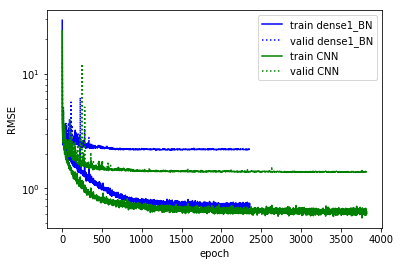

In [21]:
plot_loss([model1BN_hist, model2_hist],['dense1_BN','CNN'])

### Use the custom generator to enhance the training data

In [22]:
datagen = CustImageDataGenerator(
    rotation_range=5. #degrees
     ,horizontal_flip=True
     ,width_shift_range=.05 # percent of image width
     ,height_shift_range=.05 # percent of image height
    ).flow(X_train,y_train,whichlabels=list(labels), batch_size=32)

In [23]:
# basically a copy of model 2, but will train with augmented data
model2_augmented = Sequential()
model2_augmented.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
model2_augmented.add(BatchNormalization())
model2_augmented.add(MaxPooling2D(pool_size=(2, 2)))
model2_augmented.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
model2_augmented.add(BatchNormalization())
model2_augmented.add(MaxPooling2D(pool_size=(2, 2)))
model2_augmented.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
model2_augmented.add(BatchNormalization())
model2_augmented.add(MaxPooling2D(pool_size=(2, 2)))
model2_augmented.add(Flatten())
model2_augmented.add(Dense(500, activation = "relu"))
model2_augmented.add(BatchNormalization())
model2_augmented.add(Dense(100, activation = "relu"))
model2_augmented.add(BatchNormalization())
model2_augmented.add(Dense(30))
print(model2_augmented.summary())
model2_augmented_hist, model2_augmented = fit_model(model2_augmented, data,
                                                    'CNN_augmented',datagen)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization_7 (Batch (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 46, 46, 64)        8256      
_________________________________________________________________
batch_normalization_8 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 128)       32896     
__________

Epoch 58/10000
53/53 [==============================] - 3s 48ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 59/10000
53/53 [==============================] - 3s 49ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 60/10000
53/53 [==============================] - 3s 49ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 61/10000
53/53 [==============================] - 3s 48ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 62/10000
53/53 [==============================] - 3s 49ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 63/10000
53/53 [==============================] - 3s 49ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 64/10000
53/53 [==============================] - 3s 49ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 65/10000
53/53 [==============================] - 3s 48ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 66/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 67/10000
53/53 [==============================] - 3s 49ms/step - lo

53/53 [==============================] - 3s 49ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 138/10000
53/53 [==============================] - 3s 49ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 139/10000
53/53 [==============================] - 3s 49ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 140/10000
53/53 [==============================] - 3s 49ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 141/10000
53/53 [==============================] - 3s 49ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 142/10000
53/53 [==============================] - 3s 49ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 143/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 144/10000
53/53 [==============================] - 3s 49ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 145/10000
53/53 [==============================] - 3s 49ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 146/10000
53/53 [==============================] - 3s 49ms/step - loss: 0.

53/53 [==============================] - 3s 50ms/step - loss: 9.4391e-04 - val_loss: 9.3054e-04
Epoch 216/10000
53/53 [==============================] - 3s 48ms/step - loss: 9.3611e-04 - val_loss: 0.0011
Epoch 217/10000
53/53 [==============================] - 3s 49ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 218/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 219/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.7883e-04 - val_loss: 0.0011
Epoch 220/10000
53/53 [==============================] - 3s 49ms/step - loss: 9.7538e-04 - val_loss: 9.9633e-04
Epoch 221/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.5581e-04 - val_loss: 0.0014
Epoch 222/10000
53/53 [==============================] - 3s 49ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 223/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 224/10000
53/53 [=============================

53/53 [==============================] - 3s 50ms/step - loss: 7.4329e-04 - val_loss: 8.9562e-04
Epoch 290/10000
53/53 [==============================] - 3s 50ms/step - loss: 7.5768e-04 - val_loss: 8.5640e-04
Epoch 291/10000
53/53 [==============================] - 3s 50ms/step - loss: 7.2733e-04 - val_loss: 8.3713e-04
Epoch 292/10000
53/53 [==============================] - 3s 50ms/step - loss: 7.4566e-04 - val_loss: 8.4408e-04
Epoch 293/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.1487e-04 - val_loss: 8.3098e-04
Epoch 294/10000
53/53 [==============================] - 3s 50ms/step - loss: 7.4941e-04 - val_loss: 8.7039e-04
Epoch 295/10000
53/53 [==============================] - 3s 49ms/step - loss: 7.4034e-04 - val_loss: 8.6668e-04
Epoch 296/10000
53/53 [==============================] - 3s 50ms/step - loss: 7.6785e-04 - val_loss: 0.0010
Epoch 297/10000
53/53 [==============================] - 3s 49ms/step - loss: 7.6457e-04 - val_loss: 8.4001e-04
Epoch 298/10

53/53 [==============================] - 3s 50ms/step - loss: 6.7741e-04 - val_loss: 7.5194e-04
Epoch 363/10000
53/53 [==============================] - 3s 49ms/step - loss: 6.3274e-04 - val_loss: 8.7090e-04
Epoch 364/10000
53/53 [==============================] - 3s 50ms/step - loss: 6.1858e-04 - val_loss: 7.1600e-04
Epoch 365/10000
53/53 [==============================] - 3s 49ms/step - loss: 7.1489e-04 - val_loss: 7.8396e-04
Epoch 366/10000
53/53 [==============================] - 3s 49ms/step - loss: 6.2223e-04 - val_loss: 8.7926e-04
Epoch 367/10000
53/53 [==============================] - 3s 51ms/step - loss: 6.0941e-04 - val_loss: 8.5584e-04
Epoch 368/10000
53/53 [==============================] - 3s 50ms/step - loss: 6.8846e-04 - val_loss: 7.5316e-04
Epoch 369/10000
53/53 [==============================] - 3s 49ms/step - loss: 6.4005e-04 - val_loss: 7.3574e-04
Epoch 370/10000
53/53 [==============================] - 3s 51ms/step - loss: 6.7506e-04 - val_loss: 7.5762e-04
Epoch 37

53/53 [==============================] - 3s 48ms/step - loss: 6.0139e-04 - val_loss: 7.5717e-04
Epoch 436/10000
53/53 [==============================] - 3s 48ms/step - loss: 5.6964e-04 - val_loss: 7.3450e-04
Epoch 437/10000
53/53 [==============================] - 3s 49ms/step - loss: 5.7832e-04 - val_loss: 7.3987e-04
Epoch 438/10000
53/53 [==============================] - 3s 48ms/step - loss: 6.5541e-04 - val_loss: 8.3654e-04
Epoch 439/10000
53/53 [==============================] - 3s 50ms/step - loss: 6.3845e-04 - val_loss: 7.9157e-04
Epoch 440/10000
53/53 [==============================] - 3s 49ms/step - loss: 6.1215e-04 - val_loss: 7.2965e-04
Epoch 441/10000
53/53 [==============================] - 3s 49ms/step - loss: 5.4910e-04 - val_loss: 7.1036e-04
Epoch 442/10000
53/53 [==============================] - 3s 50ms/step - loss: 5.7252e-04 - val_loss: 7.2216e-04
Epoch 443/10000
53/53 [==============================] - 3s 49ms/step - loss: 6.0416e-04 - val_loss: 8.1805e-04
Epoch 44

53/53 [==============================] - 3s 50ms/step - loss: 5.5225e-04 - val_loss: 7.0812e-04
Epoch 509/10000
53/53 [==============================] - 3s 50ms/step - loss: 5.6787e-04 - val_loss: 6.6906e-04
Epoch 510/10000
53/53 [==============================] - 3s 49ms/step - loss: 5.7504e-04 - val_loss: 6.9580e-04
Epoch 511/10000
53/53 [==============================] - 3s 49ms/step - loss: 5.5457e-04 - val_loss: 6.9246e-04
Epoch 512/10000
53/53 [==============================] - 3s 49ms/step - loss: 5.7786e-04 - val_loss: 6.7951e-04
Epoch 513/10000
53/53 [==============================] - 3s 49ms/step - loss: 5.5547e-04 - val_loss: 7.1119e-04
Epoch 514/10000
53/53 [==============================] - 3s 50ms/step - loss: 5.4967e-04 - val_loss: 6.6796e-04
Epoch 515/10000
53/53 [==============================] - 3s 50ms/step - loss: 5.4119e-04 - val_loss: 6.9155e-04
Epoch 516/10000
53/53 [==============================] - 3s 50ms/step - loss: 5.5507e-04 - val_loss: 7.2221e-04
Epoch 51

53/53 [==============================] - 3s 49ms/step - loss: 5.1449e-04 - val_loss: 7.3712e-04
Epoch 582/10000
53/53 [==============================] - 3s 50ms/step - loss: 4.9057e-04 - val_loss: 7.0675e-04
Epoch 583/10000
53/53 [==============================] - 3s 50ms/step - loss: 4.6814e-04 - val_loss: 6.7663e-04
Epoch 584/10000
53/53 [==============================] - 3s 49ms/step - loss: 5.5972e-04 - val_loss: 7.1892e-04
Epoch 585/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.9832e-04 - val_loss: 6.5660e-04
Epoch 586/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.7690e-04 - val_loss: 7.0415e-04
Epoch 587/10000
53/53 [==============================] - 3s 52ms/step - loss: 5.1015e-04 - val_loss: 7.1658e-04
Epoch 588/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.8557e-04 - val_loss: 7.0689e-04
Epoch 589/10000
53/53 [==============================] - 3s 50ms/step - loss: 5.3382e-04 - val_loss: 7.0239e-04
Epoch 59

53/53 [==============================] - 3s 49ms/step - loss: 5.0202e-04 - val_loss: 7.2148e-04
Epoch 655/10000
53/53 [==============================] - 3s 49ms/step - loss: 5.0697e-04 - val_loss: 6.7781e-04
Epoch 656/10000
53/53 [==============================] - 3s 48ms/step - loss: 4.1877e-04 - val_loss: 6.9814e-04
Epoch 657/10000
53/53 [==============================] - 3s 48ms/step - loss: 5.0142e-04 - val_loss: 6.7770e-04
Epoch 658/10000
53/53 [==============================] - 3s 48ms/step - loss: 5.0933e-04 - val_loss: 6.4417e-04
Epoch 659/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.7440e-04 - val_loss: 6.8759e-04
Epoch 660/10000
53/53 [==============================] - 3s 51ms/step - loss: 4.3753e-04 - val_loss: 7.0752e-04
Epoch 661/10000
53/53 [==============================] - 3s 50ms/step - loss: 5.3305e-04 - val_loss: 6.6134e-04
Epoch 662/10000
53/53 [==============================] - 3s 50ms/step - loss: 5.0955e-04 - val_loss: 6.6145e-04
Epoch 66

53/53 [==============================] - 3s 50ms/step - loss: 4.7197e-04 - val_loss: 6.8767e-04
Epoch 728/10000
53/53 [==============================] - 3s 52ms/step - loss: 4.8698e-04 - val_loss: 6.4895e-04
Epoch 729/10000
53/53 [==============================] - 3s 52ms/step - loss: 4.2790e-04 - val_loss: 7.0629e-04
Epoch 730/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.4442e-04 - val_loss: 6.9322e-04
Epoch 731/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.2667e-04 - val_loss: 6.6624e-04
Epoch 732/10000
53/53 [==============================] - 3s 50ms/step - loss: 4.0981e-04 - val_loss: 6.6762e-04
Epoch 733/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.8859e-04 - val_loss: 6.7709e-04
Epoch 734/10000
53/53 [==============================] - 3s 49ms/step - loss: 5.0170e-04 - val_loss: 6.6777e-04
Epoch 735/10000
53/53 [==============================] - 3s 50ms/step - loss: 4.6601e-04 - val_loss: 6.8647e-04
Epoch 73

53/53 [==============================] - 3s 50ms/step - loss: 4.2985e-04 - val_loss: 6.7247e-04
Epoch 801/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.0324e-04 - val_loss: 6.8202e-04
Epoch 802/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.7196e-04 - val_loss: 6.6819e-04
Epoch 803/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.4602e-04 - val_loss: 6.6958e-04
Epoch 804/10000
53/53 [==============================] - 3s 51ms/step - loss: 5.5118e-04 - val_loss: 6.8275e-04
Epoch 805/10000
53/53 [==============================] - 3s 50ms/step - loss: 4.5843e-04 - val_loss: 6.3926e-04
Epoch 806/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.2400e-04 - val_loss: 6.5595e-04
Epoch 807/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.4360e-04 - val_loss: 6.9162e-04
Epoch 808/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.8658e-04 - val_loss: 6.3095e-04
Epoch 80

53/53 [==============================] - 3s 49ms/step - loss: 4.3834e-04 - val_loss: 6.5273e-04
Epoch 874/10000
53/53 [==============================] - 3s 48ms/step - loss: 4.2779e-04 - val_loss: 6.4861e-04
Epoch 875/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.6786e-04 - val_loss: 6.6201e-04
Epoch 876/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.5342e-04 - val_loss: 6.6223e-04
Epoch 877/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.1620e-04 - val_loss: 6.6083e-04
Epoch 878/10000
53/53 [==============================] - 3s 50ms/step - loss: 4.5063e-04 - val_loss: 6.6059e-04
Epoch 879/10000
53/53 [==============================] - 3s 51ms/step - loss: 4.3824e-04 - val_loss: 6.6310e-04
Epoch 880/10000
53/53 [==============================] - 3s 50ms/step - loss: 4.2660e-04 - val_loss: 6.5171e-04
Epoch 881/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.6575e-04 - val_loss: 6.4311e-04
Epoch 88

53/53 [==============================] - 3s 50ms/step - loss: 4.5850e-04 - val_loss: 6.5887e-04
Epoch 947/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.6917e-04 - val_loss: 6.3224e-04
Epoch 948/10000
53/53 [==============================] - 3s 48ms/step - loss: 4.6566e-04 - val_loss: 6.4717e-04
Epoch 949/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.6067e-04 - val_loss: 6.6982e-04
Epoch 950/10000
53/53 [==============================] - 3s 48ms/step - loss: 4.3074e-04 - val_loss: 6.4729e-04
Epoch 951/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.0753e-04 - val_loss: 6.4566e-04
Epoch 952/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.9873e-04 - val_loss: 6.7182e-04
Epoch 953/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.4864e-04 - val_loss: 6.5671e-04
Epoch 954/10000
53/53 [==============================] - 3s 48ms/step - loss: 4.5758e-04 - val_loss: 6.6923e-04
Epoch 95

Epoch 1019/10000
53/53 [==============================] - 3s 50ms/step - loss: 4.5867e-04 - val_loss: 6.4622e-04
Epoch 1020/10000
53/53 [==============================] - 3s 48ms/step - loss: 4.0316e-04 - val_loss: 6.7661e-04
Epoch 1021/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.8801e-04 - val_loss: 6.5634e-04
Epoch 1022/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.9328e-04 - val_loss: 6.7238e-04
Epoch 1023/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.8017e-04 - val_loss: 6.5530e-04
Epoch 1024/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.8520e-04 - val_loss: 6.5486e-04
Epoch 1025/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.4217e-04 - val_loss: 6.9834e-04
Epoch 1026/10000
53/53 [==============================] - 3s 48ms/step - loss: 4.6593e-04 - val_loss: 6.4687e-04
Epoch 1027/10000
53/53 [==============================] - 3s 47ms/step - loss: 4.4317e-04 - val_

53/53 [==============================] - 3s 51ms/step - loss: 4.1245e-04 - val_loss: 6.7045e-04
Epoch 1092/10000
53/53 [==============================] - 3s 48ms/step - loss: 4.3883e-04 - val_loss: 6.4641e-04
Epoch 1093/10000
53/53 [==============================] - 3s 48ms/step - loss: 4.2311e-04 - val_loss: 6.4287e-04
Epoch 1094/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.0158e-04 - val_loss: 6.4000e-04
Epoch 1095/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.2372e-04 - val_loss: 6.5602e-04
Epoch 1096/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.9622e-04 - val_loss: 6.4853e-04
Epoch 1097/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.1016e-04 - val_loss: 6.7560e-04
Epoch 1098/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.1710e-04 - val_loss: 6.4683e-04
Epoch 1099/10000
53/53 [==============================] - 3s 48ms/step - loss: 4.0133e-04 - val_loss: 6.4803e-04


53/53 [==============================] - 3s 49ms/step - loss: 3.4987e-04 - val_loss: 6.2186e-04
Epoch 1164/10000
53/53 [==============================] - 3s 48ms/step - loss: 4.3106e-04 - val_loss: 6.3410e-04
Epoch 1165/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.6290e-04 - val_loss: 6.4915e-04
Epoch 1166/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7423e-04 - val_loss: 6.4004e-04
Epoch 1167/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.9934e-04 - val_loss: 6.5248e-04
Epoch 1168/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.8036e-04 - val_loss: 6.7605e-04
Epoch 1169/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.7831e-04 - val_loss: 6.2743e-04
Epoch 1170/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.9081e-04 - val_loss: 6.2860e-04
Epoch 1171/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.9901e-04 - val_loss: 6.2950e-04


53/53 [==============================] - 3s 48ms/step - loss: 4.1944e-04 - val_loss: 6.3629e-04
Epoch 1236/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.9694e-04 - val_loss: 6.3296e-04
Epoch 1237/10000
53/53 [==============================] - 3s 48ms/step - loss: 4.2050e-04 - val_loss: 6.3094e-04
Epoch 1238/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.9281e-04 - val_loss: 6.2424e-04
Epoch 1239/10000
53/53 [==============================] - 3s 48ms/step - loss: 4.3291e-04 - val_loss: 6.4237e-04
Epoch 1240/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.8896e-04 - val_loss: 6.3946e-04
Epoch 1241/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7092e-04 - val_loss: 6.2375e-04
Epoch 1242/10000
53/53 [==============================] - 2s 47ms/step - loss: 4.2870e-04 - val_loss: 6.3003e-04
Epoch 1243/10000
53/53 [==============================] - 2s 47ms/step - loss: 3.9910e-04 - val_loss: 6.3692e-04


53/53 [==============================] - 3s 50ms/step - loss: 3.7453e-04 - val_loss: 6.5009e-04
Epoch 1308/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7133e-04 - val_loss: 6.2996e-04
Epoch 1309/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7323e-04 - val_loss: 6.4487e-04
Epoch 1310/10000
53/53 [==============================] - 3s 48ms/step - loss: 4.3332e-04 - val_loss: 6.3633e-04
Epoch 1311/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.9692e-04 - val_loss: 6.3009e-04
Epoch 1312/10000
53/53 [==============================] - 3s 48ms/step - loss: 4.0125e-04 - val_loss: 6.3053e-04
Epoch 1313/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.2657e-04 - val_loss: 6.3926e-04
Epoch 1314/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7747e-04 - val_loss: 6.3627e-04
Epoch 1315/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.8318e-04 - val_loss: 6.2950e-04


53/53 [==============================] - 3s 48ms/step - loss: 3.9401e-04 - val_loss: 6.2396e-04
Epoch 1380/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.6529e-04 - val_loss: 6.5001e-04
Epoch 1381/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.9759e-04 - val_loss: 6.4540e-04
Epoch 1382/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.6632e-04 - val_loss: 6.4515e-04
Epoch 1383/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5545e-04 - val_loss: 6.2544e-04
Epoch 1384/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.7238e-04 - val_loss: 6.4046e-04
Epoch 1385/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.6457e-04 - val_loss: 6.2675e-04
Epoch 1386/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.8370e-04 - val_loss: 6.2226e-04
Epoch 1387/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.5530e-04 - val_loss: 6.3277e-04


53/53 [==============================] - 3s 48ms/step - loss: 3.7028e-04 - val_loss: 6.3724e-04
Epoch 1452/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.7033e-04 - val_loss: 6.1734e-04
Epoch 1453/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.6562e-04 - val_loss: 6.3745e-04
Epoch 1454/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7712e-04 - val_loss: 6.4375e-04
Epoch 1455/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.7320e-04 - val_loss: 6.1322e-04
Epoch 1456/10000
53/53 [==============================] - 3s 48ms/step - loss: 4.2514e-04 - val_loss: 6.3776e-04
Epoch 1457/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.7573e-04 - val_loss: 6.2147e-04
Epoch 1458/10000
53/53 [==============================] - 2s 47ms/step - loss: 3.7577e-04 - val_loss: 6.5630e-04
Epoch 1459/10000
53/53 [==============================] - 3s 47ms/step - loss: 4.1246e-04 - val_loss: 6.1984e-04


53/53 [==============================] - 2s 47ms/step - loss: 4.1014e-04 - val_loss: 6.3772e-04
Epoch 1524/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.6205e-04 - val_loss: 6.3894e-04
Epoch 1525/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.1223e-04 - val_loss: 6.5230e-04
Epoch 1526/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.8972e-04 - val_loss: 6.3659e-04
Epoch 1527/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.9873e-04 - val_loss: 6.3417e-04
Epoch 1528/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.8173e-04 - val_loss: 6.2878e-04
Epoch 1529/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.6518e-04 - val_loss: 6.2238e-04
Epoch 1530/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5640e-04 - val_loss: 6.2116e-04
Epoch 1531/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.8982e-04 - val_loss: 6.4140e-04


53/53 [==============================] - 3s 48ms/step - loss: 4.1799e-04 - val_loss: 6.4728e-04
Epoch 1596/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.3345e-04 - val_loss: 6.3180e-04
Epoch 1597/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.6560e-04 - val_loss: 6.3528e-04
Epoch 1598/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.8829e-04 - val_loss: 6.4306e-04
Epoch 1599/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.9661e-04 - val_loss: 6.3787e-04
Epoch 1600/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.3890e-04 - val_loss: 6.4189e-04
Epoch 1601/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5857e-04 - val_loss: 6.3208e-04
Epoch 1602/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.5194e-04 - val_loss: 6.2276e-04
Epoch 1603/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.6736e-04 - val_loss: 6.3652e-04


53/53 [==============================] - 3s 50ms/step - loss: 3.7471e-04 - val_loss: 6.6908e-04
Epoch 1668/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.8485e-04 - val_loss: 6.3501e-04
Epoch 1669/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.8680e-04 - val_loss: 6.5457e-04
Epoch 1670/10000
53/53 [==============================] - 3s 48ms/step - loss: 4.0938e-04 - val_loss: 6.9798e-04
Epoch 1671/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.9236e-04 - val_loss: 6.2543e-04
Epoch 1672/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5156e-04 - val_loss: 6.2443e-04
Epoch 1673/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.1568e-04 - val_loss: 6.3439e-04
Epoch 1674/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.9844e-04 - val_loss: 6.4241e-04
Epoch 1675/10000
53/53 [==============================] - 2s 47ms/step - loss: 3.3357e-04 - val_loss: 6.2615e-04


53/53 [==============================] - 2s 47ms/step - loss: 3.5593e-04 - val_loss: 6.3425e-04
Epoch 1740/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.2725e-04 - val_loss: 6.3463e-04
Epoch 1741/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.7444e-04 - val_loss: 6.1999e-04
Epoch 1742/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.7104e-04 - val_loss: 6.2808e-04
Epoch 1743/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.7149e-04 - val_loss: 6.4267e-04
Epoch 1744/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.7069e-04 - val_loss: 6.3495e-04
Epoch 1745/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.4187e-04 - val_loss: 6.4483e-04
Epoch 1746/10000
53/53 [==============================] - 3s 50ms/step - loss: 4.1689e-04 - val_loss: 6.3340e-04
Epoch 1747/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.7215e-04 - val_loss: 6.2816e-04


53/53 [==============================] - 3s 49ms/step - loss: 3.9149e-04 - val_loss: 6.2536e-04
Epoch 1812/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.7413e-04 - val_loss: 6.3610e-04
Epoch 1813/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.6884e-04 - val_loss: 6.1924e-04
Epoch 1814/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5217e-04 - val_loss: 6.3708e-04
Epoch 1815/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.5678e-04 - val_loss: 6.2778e-04
Epoch 1816/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.5088e-04 - val_loss: 6.6809e-04
Epoch 1817/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.4742e-04 - val_loss: 6.5953e-04
Epoch 1818/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.8280e-04 - val_loss: 6.2650e-04
Epoch 1819/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.5178e-04 - val_loss: 6.2264e-04


53/53 [==============================] - 3s 49ms/step - loss: 3.2971e-04 - val_loss: 6.4932e-04
Epoch 1884/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.7995e-04 - val_loss: 6.4179e-04
Epoch 1885/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.6052e-04 - val_loss: 6.5719e-04
Epoch 1886/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.9410e-04 - val_loss: 6.1862e-04
Epoch 1887/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.7979e-04 - val_loss: 6.2439e-04
Epoch 1888/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7137e-04 - val_loss: 6.2756e-04
Epoch 1889/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.3943e-04 - val_loss: 6.3131e-04
Epoch 1890/10000
53/53 [==============================] - 3s 47ms/step - loss: 3.5576e-04 - val_loss: 6.3052e-04
Epoch 1891/10000
53/53 [==============================] - 2s 47ms/step - loss: 3.3645e-04 - val_loss: 6.1925e-04


53/53 [==============================] - 3s 49ms/step - loss: 4.0702e-04 - val_loss: 6.4404e-04
Epoch 1956/10000
53/53 [==============================] - 3s 48ms/step - loss: 4.0441e-04 - val_loss: 6.2507e-04
Epoch 1957/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.4830e-04 - val_loss: 6.1891e-04
Epoch 1958/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.4056e-04 - val_loss: 6.1391e-04
Epoch 1959/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.7091e-04 - val_loss: 6.2245e-04
Epoch 1960/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.5136e-04 - val_loss: 6.4127e-04
Epoch 1961/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.6426e-04 - val_loss: 6.2828e-04
Epoch 1962/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.0346e-04 - val_loss: 6.1537e-04
Epoch 1963/10000
53/53 [==============================] - 3s 50ms/step - loss: 4.0971e-04 - val_loss: 6.2587e-04


53/53 [==============================] - 3s 48ms/step - loss: 3.4989e-04 - val_loss: 6.1594e-04
Epoch 2028/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.8882e-04 - val_loss: 6.2525e-04
Epoch 2029/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.5906e-04 - val_loss: 6.2064e-04
Epoch 2030/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.3335e-04 - val_loss: 6.4232e-04
Epoch 2031/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.6257e-04 - val_loss: 6.1677e-04
Epoch 2032/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.2830e-04 - val_loss: 6.0660e-04
Epoch 2033/10000
53/53 [==============================] - 3s 48ms/step - loss: 4.2947e-04 - val_loss: 6.7971e-04
Epoch 2034/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.7712e-04 - val_loss: 6.5435e-04
Epoch 2035/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.9366e-04 - val_loss: 6.3713e-04


53/53 [==============================] - 3s 48ms/step - loss: 3.6208e-04 - val_loss: 6.4493e-04
Epoch 2100/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.2849e-04 - val_loss: 6.2291e-04
Epoch 2101/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.7365e-04 - val_loss: 6.3014e-04
Epoch 2102/10000
53/53 [==============================] - 3s 48ms/step - loss: 4.2577e-04 - val_loss: 6.3221e-04
Epoch 2103/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.8624e-04 - val_loss: 6.4554e-04
Epoch 2104/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.3655e-04 - val_loss: 6.5066e-04
Epoch 2105/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.3666e-04 - val_loss: 6.1966e-04
Epoch 2106/10000
53/53 [==============================] - 3s 47ms/step - loss: 3.2228e-04 - val_loss: 6.4900e-04
Epoch 2107/10000
53/53 [==============================] - 3s 47ms/step - loss: 3.2868e-04 - val_loss: 6.3070e-04


53/53 [==============================] - 3s 47ms/step - loss: 3.7217e-04 - val_loss: 6.1020e-04
Epoch 2172/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.6642e-04 - val_loss: 6.2494e-04
Epoch 2173/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.1114e-04 - val_loss: 6.5032e-04
Epoch 2174/10000
53/53 [==============================] - 3s 48ms/step - loss: 4.0447e-04 - val_loss: 6.2950e-04
Epoch 2175/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3103e-04 - val_loss: 6.2225e-04
Epoch 2176/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7054e-04 - val_loss: 6.5973e-04
Epoch 2177/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.8583e-04 - val_loss: 6.3317e-04
Epoch 2178/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.8127e-04 - val_loss: 6.1668e-04
Epoch 2179/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.0387e-04 - val_loss: 6.5290e-04


53/53 [==============================] - 3s 48ms/step - loss: 3.7326e-04 - val_loss: 6.2594e-04
Epoch 2244/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.6492e-04 - val_loss: 6.2503e-04
Epoch 2245/10000
53/53 [==============================] - 3s 48ms/step - loss: 4.0182e-04 - val_loss: 6.2997e-04
Epoch 2246/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.5315e-04 - val_loss: 6.3361e-04
Epoch 2247/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.8192e-04 - val_loss: 6.3245e-04
Epoch 2248/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7919e-04 - val_loss: 6.1320e-04
Epoch 2249/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.3039e-04 - val_loss: 6.4074e-04
Epoch 2250/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.8829e-04 - val_loss: 6.3816e-04
Epoch 2251/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.8673e-04 - val_loss: 6.2272e-04


53/53 [==============================] - 3s 48ms/step - loss: 3.9075e-04 - val_loss: 6.1370e-04
Epoch 2316/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5372e-04 - val_loss: 6.2706e-04
Epoch 2317/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.7267e-04 - val_loss: 6.3737e-04
Epoch 2318/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.9291e-04 - val_loss: 6.3473e-04
Epoch 2319/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.8617e-04 - val_loss: 6.3101e-04
Epoch 2320/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5496e-04 - val_loss: 6.3473e-04
Epoch 2321/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5766e-04 - val_loss: 6.3598e-04
Epoch 2322/10000
53/53 [==============================] - 3s 47ms/step - loss: 3.5846e-04 - val_loss: 6.7030e-04
Epoch 2323/10000
53/53 [==============================] - 2s 47ms/step - loss: 3.4665e-04 - val_loss: 6.2229e-04


53/53 [==============================] - 2s 47ms/step - loss: 4.0066e-04 - val_loss: 6.3227e-04
Epoch 2388/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7933e-04 - val_loss: 6.2015e-04
Epoch 2389/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.4385e-04 - val_loss: 6.3972e-04
Epoch 2390/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.6103e-04 - val_loss: 6.2649e-04
Epoch 2391/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.6569e-04 - val_loss: 6.3963e-04
Epoch 2392/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.2395e-04 - val_loss: 6.4919e-04
Epoch 2393/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.9243e-04 - val_loss: 6.3573e-04
Epoch 2394/10000
53/53 [==============================] - 3s 48ms/step - loss: 4.0873e-04 - val_loss: 6.5407e-04
Epoch 2395/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.3863e-04 - val_loss: 6.4930e-04


53/53 [==============================] - 3s 50ms/step - loss: 2.9827e-04 - val_loss: 6.1460e-04
Epoch 2460/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.6443e-04 - val_loss: 6.2378e-04
Epoch 2461/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.1261e-04 - val_loss: 6.3675e-04
Epoch 2462/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.5377e-04 - val_loss: 6.3677e-04
Epoch 2463/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.7176e-04 - val_loss: 6.1752e-04
Epoch 2464/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.9899e-04 - val_loss: 6.3699e-04
Epoch 2465/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.4704e-04 - val_loss: 6.4051e-04
Epoch 2466/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.0853e-04 - val_loss: 6.3218e-04
Epoch 2467/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.6846e-04 - val_loss: 6.1547e-04


53/53 [==============================] - 3s 48ms/step - loss: 2.9811e-04 - val_loss: 6.1950e-04
Epoch 2532/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.6760e-04 - val_loss: 6.3787e-04
Epoch 2533/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.8210e-04 - val_loss: 6.2192e-04
Epoch 2534/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3986e-04 - val_loss: 6.1767e-04
Epoch 2535/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7136e-04 - val_loss: 6.1405e-04
Epoch 2536/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3512e-04 - val_loss: 6.3062e-04
Epoch 2537/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.2979e-04 - val_loss: 6.1760e-04
Epoch 2538/10000
53/53 [==============================] - 3s 47ms/step - loss: 3.5475e-04 - val_loss: 6.3863e-04
Epoch 2539/10000
53/53 [==============================] - 3s 47ms/step - loss: 3.9535e-04 - val_loss: 6.3573e-04


53/53 [==============================] - 3s 47ms/step - loss: 3.9001e-04 - val_loss: 6.1557e-04
Epoch 2604/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.7231e-04 - val_loss: 6.1462e-04
Epoch 2605/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.3147e-04 - val_loss: 6.2845e-04
Epoch 2606/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.5876e-04 - val_loss: 6.2223e-04
Epoch 2607/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.7352e-04 - val_loss: 6.2325e-04
Epoch 2608/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.2484e-04 - val_loss: 6.2598e-04
Epoch 2609/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4524e-04 - val_loss: 6.2554e-04
Epoch 2610/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.6502e-04 - val_loss: 6.1200e-04
Epoch 2611/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.5968e-04 - val_loss: 6.3145e-04


53/53 [==============================] - 3s 48ms/step - loss: 3.3710e-04 - val_loss: 6.2311e-04
Epoch 2676/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.8023e-04 - val_loss: 6.1425e-04
Epoch 2677/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.1455e-04 - val_loss: 6.1293e-04
Epoch 2678/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.1465e-04 - val_loss: 6.2584e-04
Epoch 2679/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.8830e-04 - val_loss: 6.2922e-04
Epoch 2680/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.6666e-04 - val_loss: 6.1828e-04
Epoch 2681/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.5934e-04 - val_loss: 6.2427e-04
Epoch 2682/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.3854e-04 - val_loss: 6.2912e-04
Epoch 2683/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.8504e-04 - val_loss: 6.5948e-04


53/53 [==============================] - 3s 48ms/step - loss: 3.5506e-04 - val_loss: 6.3397e-04
Epoch 2748/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.5898e-04 - val_loss: 6.3222e-04
Epoch 2749/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.1159e-04 - val_loss: 6.1866e-04
Epoch 2750/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.7024e-04 - val_loss: 6.1837e-04
Epoch 2751/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.2609e-04 - val_loss: 6.2801e-04
Epoch 2752/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5366e-04 - val_loss: 6.2879e-04
Epoch 2753/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.4376e-04 - val_loss: 6.2577e-04
Epoch 2754/10000
53/53 [==============================] - 2s 47ms/step - loss: 3.9612e-04 - val_loss: 6.3163e-04
Epoch 2755/10000
53/53 [==============================] - 3s 47ms/step - loss: 3.5922e-04 - val_loss: 6.3204e-04


53/53 [==============================] - 2s 47ms/step - loss: 3.6069e-04 - val_loss: 6.4202e-04
Epoch 2820/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.8896e-04 - val_loss: 6.0908e-04
Epoch 2821/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.6805e-04 - val_loss: 6.0730e-04
Epoch 2822/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.4433e-04 - val_loss: 6.1946e-04
Epoch 2823/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.4201e-04 - val_loss: 6.2021e-04
Epoch 2824/10000
53/53 [==============================] - 3s 48ms/step - loss: 2.9370e-04 - val_loss: 6.1275e-04
Epoch 2825/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5090e-04 - val_loss: 6.1754e-04
Epoch 2826/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.5543e-04 - val_loss: 6.1219e-04
Epoch 2827/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7760e-04 - val_loss: 6.2239e-04


53/53 [==============================] - 3s 48ms/step - loss: 3.5338e-04 - val_loss: 6.0822e-04
Epoch 2892/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.5870e-04 - val_loss: 6.3425e-04
Epoch 2893/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.6323e-04 - val_loss: 6.3274e-04
Epoch 2894/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.4476e-04 - val_loss: 6.4054e-04
Epoch 2895/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.8503e-04 - val_loss: 6.3322e-04
Epoch 2896/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.4761e-04 - val_loss: 6.1617e-04
Epoch 2897/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.6898e-04 - val_loss: 6.2388e-04
Epoch 2898/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.9740e-04 - val_loss: 6.2234e-04
Epoch 2899/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.5937e-04 - val_loss: 6.2143e-04


53/53 [==============================] - 3s 48ms/step - loss: 3.1395e-04 - val_loss: 6.1274e-04
Epoch 2964/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3785e-04 - val_loss: 6.2659e-04
Epoch 2965/10000
53/53 [==============================] - 3s 48ms/step - loss: 2.9869e-04 - val_loss: 6.1993e-04
Epoch 2966/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.4263e-04 - val_loss: 6.2133e-04
Epoch 2967/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.4216e-04 - val_loss: 6.1914e-04
Epoch 2968/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.3532e-04 - val_loss: 6.1220e-04
Epoch 2969/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.4901e-04 - val_loss: 6.2925e-04
Epoch 2970/10000
53/53 [==============================] - 2s 47ms/step - loss: 3.3529e-04 - val_loss: 6.2071e-04
Epoch 2971/10000
53/53 [==============================] - 2s 47ms/step - loss: 3.4209e-04 - val_loss: 6.2131e-04


53/53 [==============================] - 2s 47ms/step - loss: 3.9150e-04 - val_loss: 6.3038e-04ETA: 1s -
Epoch 3036/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.4967e-04 - val_loss: 6.3109e-04
Epoch 3037/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.2041e-04 - val_loss: 6.2876e-04
Epoch 3038/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.7002e-04 - val_loss: 6.2285e-04
Epoch 3039/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5812e-04 - val_loss: 6.2583e-04
Epoch 3040/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.7338e-04 - val_loss: 6.1483e-04
Epoch 3041/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.6061e-04 - val_loss: 6.1535e-04
Epoch 3042/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4351e-04 - val_loss: 6.0996e-04
Epoch 3043/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.9956e-04 - val_loss: 6.

53/53 [==============================] - 3s 49ms/step - loss: 3.4826e-04 - val_loss: 6.2025e-04
Epoch 3108/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.3637e-04 - val_loss: 6.2130e-04
Epoch 3109/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.6749e-04 - val_loss: 6.3929e-04
Epoch 3110/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.6574e-04 - val_loss: 6.1742e-04
Epoch 3111/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.2597e-04 - val_loss: 6.0687e-04
Epoch 3112/10000
53/53 [==============================] - 3s 52ms/step - loss: 3.7067e-04 - val_loss: 6.2033e-04
Epoch 3113/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7237e-04 - val_loss: 6.2937e-04
Epoch 3114/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5334e-04 - val_loss: 6.1439e-04
Epoch 3115/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3069e-04 - val_loss: 6.2029e-04


53/53 [==============================] - 3s 48ms/step - loss: 3.4472e-04 - val_loss: 6.1275e-04
Epoch 3180/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4123e-04 - val_loss: 6.2644e-04
Epoch 3181/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.5926e-04 - val_loss: 6.1635e-04
Epoch 3182/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.4043e-04 - val_loss: 6.2603e-04
Epoch 3183/10000
53/53 [==============================] - 3s 48ms/step - loss: 4.0642e-04 - val_loss: 6.6619e-04
Epoch 3184/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.8095e-04 - val_loss: 6.1760e-04
Epoch 3185/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5012e-04 - val_loss: 6.4295e-04
Epoch 3186/10000
53/53 [==============================] - 3s 47ms/step - loss: 3.8026e-04 - val_loss: 6.3221e-04
Epoch 3187/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.5269e-04 - val_loss: 6.5324e-04


53/53 [==============================] - 3s 50ms/step - loss: 3.7738e-04 - val_loss: 6.1681e-04
Epoch 3252/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.3917e-04 - val_loss: 6.2777e-04
Epoch 3253/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.3466e-04 - val_loss: 6.2607e-04
Epoch 3254/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4552e-04 - val_loss: 6.2554e-04
Epoch 3255/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4345e-04 - val_loss: 6.1736e-04
Epoch 3256/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.6027e-04 - val_loss: 6.1798e-04
Epoch 3257/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3682e-04 - val_loss: 6.6288e-04
Epoch 3258/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7968e-04 - val_loss: 6.4383e-04
Epoch 3259/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.4611e-04 - val_loss: 6.3893e-04


53/53 [==============================] - 3s 51ms/step - loss: 3.7173e-04 - val_loss: 6.2035e-04
Epoch 3324/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.1621e-04 - val_loss: 6.1796e-04
Epoch 3325/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.5845e-04 - val_loss: 6.4723e-04
Epoch 3326/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.6047e-04 - val_loss: 6.2384e-04
Epoch 3327/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.3474e-04 - val_loss: 6.3731e-04
Epoch 3328/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.6715e-04 - val_loss: 6.4805e-04
Epoch 3329/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4151e-04 - val_loss: 6.3055e-04
Epoch 3330/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4923e-04 - val_loss: 6.3724e-04
Epoch 3331/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.0780e-04 - val_loss: 6.2651e-04


53/53 [==============================] - 3s 49ms/step - loss: 3.9215e-04 - val_loss: 6.2946e-04
Epoch 3396/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.2351e-04 - val_loss: 6.2669e-04
Epoch 3397/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7091e-04 - val_loss: 6.2953e-04
Epoch 3398/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.3930e-04 - val_loss: 6.2738e-04
Epoch 3399/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.0388e-04 - val_loss: 6.1002e-04
Epoch 3400/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4546e-04 - val_loss: 6.4345e-04
Epoch 3401/10000
53/53 [==============================] - 3s 52ms/step - loss: 3.6588e-04 - val_loss: 6.1007e-04
Epoch 3402/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5457e-04 - val_loss: 6.2351e-04
Epoch 3403/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.4677e-04 - val_loss: 6.2723e-04


53/53 [==============================] - 3s 50ms/step - loss: 3.1081e-04 - val_loss: 6.1735e-04
Epoch 3468/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.0664e-04 - val_loss: 6.2954e-04
Epoch 3469/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4652e-04 - val_loss: 6.1657e-04
Epoch 3470/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.9066e-04 - val_loss: 6.1043e-04
Epoch 3471/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.1578e-04 - val_loss: 6.1690e-04
Epoch 3472/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.6642e-04 - val_loss: 6.2383e-04
Epoch 3473/10000
53/53 [==============================] - 3s 49ms/step - loss: 2.8938e-04 - val_loss: 6.0974e-04
Epoch 3474/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5927e-04 - val_loss: 6.4619e-04
Epoch 3475/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4276e-04 - val_loss: 6.2021e-04


53/53 [==============================] - 3s 49ms/step - loss: 3.2301e-04 - val_loss: 6.2931e-04
Epoch 3540/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3309e-04 - val_loss: 6.5510e-04
Epoch 3541/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.0405e-04 - val_loss: 6.1972e-04
Epoch 3542/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.2669e-04 - val_loss: 6.2084e-04
Epoch 3543/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.1263e-04 - val_loss: 6.6412e-04
Epoch 3544/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4136e-04 - val_loss: 6.4629e-04
Epoch 3545/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3476e-04 - val_loss: 6.2507e-04
Epoch 3546/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3426e-04 - val_loss: 6.2388e-04
Epoch 3547/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.0811e-04 - val_loss: 6.1831e-04


53/53 [==============================] - 3s 49ms/step - loss: 3.6937e-04 - val_loss: 6.1402e-04
Epoch 3612/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.4218e-04 - val_loss: 6.2858e-04
Epoch 3613/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.7623e-04 - val_loss: 6.2033e-04
Epoch 3614/10000
53/53 [==============================] - 3s 51ms/step - loss: 4.0546e-04 - val_loss: 6.2274e-04
Epoch 3615/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7719e-04 - val_loss: 6.1129e-04
Epoch 3616/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.6546e-04 - val_loss: 6.1265e-04
Epoch 3617/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.4955e-04 - val_loss: 6.1703e-04
Epoch 3618/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.7206e-04 - val_loss: 6.1742e-04
Epoch 3619/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.5626e-04 - val_loss: 6.2628e-04


53/53 [==============================] - 3s 51ms/step - loss: 3.8104e-04 - val_loss: 6.3470e-04
Epoch 3684/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.1288e-04 - val_loss: 6.2752e-04
Epoch 3685/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.0967e-04 - val_loss: 6.0693e-04
Epoch 3686/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.6210e-04 - val_loss: 6.2705e-04
Epoch 3687/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.9579e-04 - val_loss: 6.0765e-04
Epoch 3688/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3170e-04 - val_loss: 6.1088e-04
Epoch 3689/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.2976e-04 - val_loss: 6.1104e-04
Epoch 3690/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.2640e-04 - val_loss: 6.1499e-04
Epoch 3691/10000
53/53 [==============================] - 3s 52ms/step - loss: 3.8658e-04 - val_loss: 6.2147e-04


53/53 [==============================] - 3s 49ms/step - loss: 3.1897e-04 - val_loss: 6.1737e-04
Epoch 3756/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3321e-04 - val_loss: 6.3478e-04
Epoch 3757/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.2776e-04 - val_loss: 6.2306e-04
Epoch 3758/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3448e-04 - val_loss: 6.1346e-04
Epoch 3759/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5171e-04 - val_loss: 6.0577e-04
Epoch 3760/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.2565e-04 - val_loss: 6.2574e-04
Epoch 3761/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4707e-04 - val_loss: 6.2639e-04
Epoch 3762/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5347e-04 - val_loss: 6.3800e-04
Epoch 3763/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5379e-04 - val_loss: 6.5821e-04


53/53 [==============================] - 3s 50ms/step - loss: 3.4596e-04 - val_loss: 6.2108e-04
Epoch 3828/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.1770e-04 - val_loss: 6.2563e-04
Epoch 3829/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.3252e-04 - val_loss: 6.1952e-04
Epoch 3830/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4543e-04 - val_loss: 6.0936e-04
Epoch 3831/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3558e-04 - val_loss: 6.3521e-04
Epoch 3832/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.2983e-04 - val_loss: 6.1202e-04
Epoch 3833/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5131e-04 - val_loss: 6.2847e-04
Epoch 3834/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.4603e-04 - val_loss: 6.3299e-04
Epoch 3835/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.5529e-04 - val_loss: 6.2055e-04


53/53 [==============================] - 3s 48ms/step - loss: 3.7118e-04 - val_loss: 6.2156e-04
Epoch 3900/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.9569e-04 - val_loss: 6.2903e-04
Epoch 3901/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.1932e-04 - val_loss: 6.2984e-04
Epoch 3902/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3627e-04 - val_loss: 6.3599e-04
Epoch 3903/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.6968e-04 - val_loss: 6.2141e-04
Epoch 3904/10000
53/53 [==============================] - 3s 52ms/step - loss: 3.1171e-04 - val_loss: 6.1707e-04
Epoch 3905/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7169e-04 - val_loss: 6.2023e-04
Epoch 3906/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.6742e-04 - val_loss: 6.1994e-04
Epoch 3907/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.6821e-04 - val_loss: 6.4617e-04


53/53 [==============================] - 3s 49ms/step - loss: 3.4255e-04 - val_loss: 6.1473e-04
Epoch 3972/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3840e-04 - val_loss: 6.3595e-04
Epoch 3973/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.2657e-04 - val_loss: 6.3088e-04
Epoch 3974/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.2364e-04 - val_loss: 6.3096e-04
Epoch 3975/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.4261e-04 - val_loss: 6.2270e-04
Epoch 3976/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.6355e-04 - val_loss: 6.2368e-04
Epoch 3977/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4166e-04 - val_loss: 6.8928e-04
Epoch 3978/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.5367e-04 - val_loss: 6.2077e-04
Epoch 3979/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.3765e-04 - val_loss: 6.3276e-04


53/53 [==============================] - 3s 49ms/step - loss: 3.4143e-04 - val_loss: 6.1317e-04
Epoch 4044/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4988e-04 - val_loss: 6.3467e-04
Epoch 4045/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4174e-04 - val_loss: 6.3269e-04
Epoch 4046/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.4610e-04 - val_loss: 6.2027e-04
Epoch 4047/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4542e-04 - val_loss: 6.2495e-04
Epoch 4048/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7601e-04 - val_loss: 6.1001e-04
Epoch 4049/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4902e-04 - val_loss: 6.1885e-04
Epoch 4050/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.7007e-04 - val_loss: 6.4086e-04
Epoch 4051/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.9718e-04 - val_loss: 6.0768e-04


53/53 [==============================] - 3s 49ms/step - loss: 3.4306e-04 - val_loss: 6.0607e-04
Epoch 4116/10000
53/53 [==============================] - 3s 52ms/step - loss: 3.4763e-04 - val_loss: 6.1053e-04
Epoch 4117/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.4216e-04 - val_loss: 6.1563e-04
Epoch 4118/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.6046e-04 - val_loss: 6.3101e-04
Epoch 4119/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4211e-04 - val_loss: 6.3476e-04
Epoch 4120/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.6782e-04 - val_loss: 6.3907e-04
Epoch 4121/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5093e-04 - val_loss: 6.3570e-04
Epoch 4122/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.3442e-04 - val_loss: 6.2258e-04
Epoch 4123/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7691e-04 - val_loss: 6.3173e-04


53/53 [==============================] - 3s 50ms/step - loss: 3.5213e-04 - val_loss: 6.1437e-04
Epoch 4188/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.4654e-04 - val_loss: 6.1085e-04
Epoch 4189/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.8665e-04 - val_loss: 6.2265e-04
Epoch 4190/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4417e-04 - val_loss: 6.1888e-04
Epoch 4191/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.5571e-04 - val_loss: 6.0762e-04
Epoch 4192/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.3874e-04 - val_loss: 6.2308e-04
Epoch 4193/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.3832e-04 - val_loss: 6.1093e-04
Epoch 4194/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4336e-04 - val_loss: 6.1753e-04
Epoch 4195/10000
53/53 [==============================] - 3s 51ms/step - loss: 4.1477e-04 - val_loss: 6.1914e-04


53/53 [==============================] - 3s 49ms/step - loss: 3.4537e-04 - val_loss: 6.2034e-04
Epoch 4260/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5537e-04 - val_loss: 6.1956e-04
Epoch 4261/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.3724e-04 - val_loss: 6.1843e-04
Epoch 4262/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3264e-04 - val_loss: 6.4353e-04
Epoch 4263/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3263e-04 - val_loss: 6.5212e-04
Epoch 4264/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.5466e-04 - val_loss: 6.5762e-04
Epoch 4265/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.1540e-04 - val_loss: 6.2294e-04
Epoch 4266/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.1999e-04 - val_loss: 6.1747e-04
Epoch 4267/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3440e-04 - val_loss: 6.1749e-04


53/53 [==============================] - 3s 49ms/step - loss: 3.2892e-04 - val_loss: 6.1558e-04
Epoch 4332/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.8301e-04 - val_loss: 6.2234e-04
Epoch 4333/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.1359e-04 - val_loss: 6.2809e-04
Epoch 4334/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.3821e-04 - val_loss: 6.1385e-04
Epoch 4335/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.6200e-04 - val_loss: 6.0987e-04
Epoch 4336/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7412e-04 - val_loss: 6.2802e-04
Epoch 4337/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.5321e-04 - val_loss: 6.1910e-04
Epoch 4338/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3130e-04 - val_loss: 6.6616e-04
Epoch 4339/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.5632e-04 - val_loss: 6.1671e-04


53/53 [==============================] - 3s 50ms/step - loss: 3.3323e-04 - val_loss: 6.1424e-04
Epoch 4404/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.2053e-04 - val_loss: 6.1459e-04
Epoch 4405/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.4550e-04 - val_loss: 6.0845e-04
Epoch 4406/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3338e-04 - val_loss: 6.1835e-04
Epoch 4407/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.6759e-04 - val_loss: 6.1924e-04
Epoch 4408/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.6046e-04 - val_loss: 6.1767e-04
Epoch 4409/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5332e-04 - val_loss: 6.4247e-04
Epoch 4410/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.2643e-04 - val_loss: 6.2315e-04
Epoch 4411/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7974e-04 - val_loss: 6.2402e-04


53/53 [==============================] - 3s 51ms/step - loss: 3.3392e-04 - val_loss: 6.1802e-04
Epoch 4476/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.1619e-04 - val_loss: 6.1900e-04
Epoch 4477/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.3321e-04 - val_loss: 6.3281e-04
Epoch 4478/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.1051e-04 - val_loss: 6.3386e-04
Epoch 4479/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3325e-04 - val_loss: 6.2187e-04
Epoch 4480/10000
53/53 [==============================] - 3s 50ms/step - loss: 2.9141e-04 - val_loss: 6.1517e-04
Epoch 4481/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.1779e-04 - val_loss: 6.6555e-04
Epoch 4482/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.4656e-04 - val_loss: 6.4086e-04
Epoch 4483/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.7874e-04 - val_loss: 6.1336e-04


53/53 [==============================] - 3s 49ms/step - loss: 3.7845e-04 - val_loss: 6.1957e-04
Epoch 4548/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5431e-04 - val_loss: 6.0869e-04
Epoch 4549/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.9281e-04 - val_loss: 6.2716e-04
Epoch 4550/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.4070e-04 - val_loss: 6.2003e-04
Epoch 4551/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.2735e-04 - val_loss: 6.1943e-04
Epoch 4552/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5103e-04 - val_loss: 6.2851e-04
Epoch 4553/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.4506e-04 - val_loss: 6.2745e-04
Epoch 4554/10000
53/53 [==============================] - 3s 49ms/step - loss: 2.7704e-04 - val_loss: 6.0925e-04
Epoch 4555/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.5566e-04 - val_loss: 6.3812e-04


53/53 [==============================] - 3s 50ms/step - loss: 3.1579e-04 - val_loss: 6.2053e-04
Epoch 4620/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.1245e-04 - val_loss: 6.2422e-04
Epoch 4621/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.5361e-04 - val_loss: 6.0607e-04
Epoch 4622/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.2701e-04 - val_loss: 6.1653e-04
Epoch 4623/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.5490e-04 - val_loss: 6.1965e-04
Epoch 4624/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4237e-04 - val_loss: 6.1912e-04
Epoch 4625/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5872e-04 - val_loss: 6.1709e-04
Epoch 4626/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.2483e-04 - val_loss: 6.1003e-04
Epoch 4627/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.1122e-04 - val_loss: 6.2391e-04


53/53 [==============================] - 3s 49ms/step - loss: 3.5048e-04 - val_loss: 6.2878e-04
Epoch 4692/10000
53/53 [==============================] - 3s 50ms/step - loss: 2.9389e-04 - val_loss: 6.2291e-04
Epoch 4693/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.1206e-04 - val_loss: 6.1311e-04
Epoch 4694/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5514e-04 - val_loss: 6.2426e-04
Epoch 4695/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.4774e-04 - val_loss: 6.0866e-04
Epoch 4696/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.3615e-04 - val_loss: 6.1481e-04
Epoch 4697/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.2201e-04 - val_loss: 6.1921e-04
Epoch 4698/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7375e-04 - val_loss: 6.1677e-04
Epoch 4699/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.2672e-04 - val_loss: 6.5718e-04


53/53 [==============================] - 3s 48ms/step - loss: 3.8293e-04 - val_loss: 6.1449e-04
Epoch 4764/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.7662e-04 - val_loss: 6.2644e-04
Epoch 4765/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.6082e-04 - val_loss: 6.0736e-04
Epoch 4766/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.4050e-04 - val_loss: 6.1820e-04
Epoch 4767/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4967e-04 - val_loss: 6.2592e-04
Epoch 4768/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.2531e-04 - val_loss: 6.1447e-04
Epoch 4769/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.7351e-04 - val_loss: 6.3606e-04
Epoch 4770/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.6292e-04 - val_loss: 6.2739e-04
Epoch 4771/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.0315e-04 - val_loss: 6.2414e-04


53/53 [==============================] - 3s 50ms/step - loss: 3.4938e-04 - val_loss: 6.2070e-04
Epoch 4836/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.5823e-04 - val_loss: 6.4283e-04
Epoch 4837/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7586e-04 - val_loss: 6.2388e-04
Epoch 4838/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.6403e-04 - val_loss: 6.0805e-04
Epoch 4839/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.6126e-04 - val_loss: 6.2807e-04
Epoch 4840/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7588e-04 - val_loss: 6.1235e-04
Epoch 4841/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.4462e-04 - val_loss: 6.1430e-04
Epoch 4842/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.2996e-04 - val_loss: 6.1137e-04
Epoch 4843/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.3886e-04 - val_loss: 6.1413e-04


53/53 [==============================] - 3s 50ms/step - loss: 3.6029e-04 - val_loss: 6.2223e-04
Epoch 4908/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5433e-04 - val_loss: 6.3257e-04
Epoch 4909/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.2167e-04 - val_loss: 6.1615e-04
Epoch 4910/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.7126e-04 - val_loss: 6.2565e-04
Epoch 4911/10000
53/53 [==============================] - 3s 49ms/step - loss: 2.9263e-04 - val_loss: 6.3410e-04
Epoch 4912/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.7255e-04 - val_loss: 6.2777e-04
Epoch 4913/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.6325e-04 - val_loss: 6.1715e-04
Epoch 4914/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.4017e-04 - val_loss: 6.3198e-04
Epoch 4915/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.4279e-04 - val_loss: 6.1207e-04


53/53 [==============================] - 3s 49ms/step - loss: 3.3166e-04 - val_loss: 6.2349e-04
Epoch 4980/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.2678e-04 - val_loss: 6.2089e-04
Epoch 4981/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.7521e-04 - val_loss: 6.2642e-04
Epoch 4982/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.2946e-04 - val_loss: 6.3653e-04
Epoch 4983/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.4433e-04 - val_loss: 6.1580e-04
Epoch 4984/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4020e-04 - val_loss: 6.1715e-04
Epoch 4985/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4532e-04 - val_loss: 6.1339e-04
Epoch 4986/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.2719e-04 - val_loss: 6.4018e-04
Epoch 4987/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.3106e-04 - val_loss: 6.1135e-04


53/53 [==============================] - 3s 50ms/step - loss: 3.6996e-04 - val_loss: 6.1235e-04
Epoch 5052/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.4943e-04 - val_loss: 6.1442e-04
Epoch 5053/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.5989e-04 - val_loss: 6.0594e-04
Epoch 5054/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.5353e-04 - val_loss: 6.5058e-04
Epoch 5055/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.2383e-04 - val_loss: 6.0268e-04
Epoch 5056/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4617e-04 - val_loss: 6.3116e-04
Epoch 5057/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.0253e-04 - val_loss: 6.2375e-04
Epoch 5058/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.2186e-04 - val_loss: 6.0987e-04
Epoch 5059/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4097e-04 - val_loss: 6.0659e-04


53/53 [==============================] - 3s 52ms/step - loss: 3.4960e-04 - val_loss: 6.3068e-04
Epoch 5124/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7173e-04 - val_loss: 6.2972e-04
Epoch 5125/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.2816e-04 - val_loss: 6.1274e-04
Epoch 5126/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.2495e-04 - val_loss: 6.2283e-04
Epoch 5127/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.1485e-04 - val_loss: 6.0921e-04
Epoch 5128/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.1433e-04 - val_loss: 6.2327e-04
Epoch 5129/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.0645e-04 - val_loss: 6.1690e-04
Epoch 5130/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.2510e-04 - val_loss: 6.2297e-04
Epoch 5131/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3886e-04 - val_loss: 6.2495e-04


53/53 [==============================] - 3s 48ms/step - loss: 3.7503e-04 - val_loss: 6.6484e-04
Epoch 5196/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4433e-04 - val_loss: 6.3012e-04
Epoch 5197/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.8407e-04 - val_loss: 6.0486e-04
Epoch 5198/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.0006e-04 - val_loss: 6.1376e-04
Epoch 5199/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.7968e-04 - val_loss: 6.0986e-04
Epoch 5200/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.9972e-04 - val_loss: 6.1183e-04
Epoch 5201/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3357e-04 - val_loss: 6.1179e-04
Epoch 5202/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.2775e-04 - val_loss: 6.1109e-04
Epoch 5203/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.4907e-04 - val_loss: 6.2452e-04


53/53 [==============================] - 3s 52ms/step - loss: 3.2159e-04 - val_loss: 6.2140e-04
Epoch 5268/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.3820e-04 - val_loss: 6.2259e-04
Epoch 5269/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.6251e-04 - val_loss: 6.1940e-04
Epoch 5270/10000
53/53 [==============================] - 3s 49ms/step - loss: 4.0388e-04 - val_loss: 6.3643e-04
Epoch 5271/10000
53/53 [==============================] - 3s 49ms/step - loss: 2.8969e-04 - val_loss: 6.2795e-04
Epoch 5272/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5075e-04 - val_loss: 6.5437e-04
Epoch 5273/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.5250e-04 - val_loss: 6.0787e-04
Epoch 5274/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3051e-04 - val_loss: 6.1397e-04
Epoch 5275/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.2004e-04 - val_loss: 6.1592e-04


53/53 [==============================] - 3s 49ms/step - loss: 3.5906e-04 - val_loss: 6.1657e-04
Epoch 5340/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.2229e-04 - val_loss: 6.4686e-04
Epoch 5341/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.6834e-04 - val_loss: 6.0975e-04
Epoch 5342/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5597e-04 - val_loss: 6.4063e-04
Epoch 5343/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.0443e-04 - val_loss: 6.5025e-04
Epoch 5344/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.6702e-04 - val_loss: 6.3784e-04
Epoch 5345/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7620e-04 - val_loss: 6.3947e-04
Epoch 5346/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.3630e-04 - val_loss: 6.0829e-04
Epoch 5347/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.2310e-04 - val_loss: 6.2322e-04


53/53 [==============================] - 3s 52ms/step - loss: 3.5865e-04 - val_loss: 6.1327e-04
Epoch 5412/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.2566e-04 - val_loss: 6.2158e-04
Epoch 5413/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.4242e-04 - val_loss: 6.1661e-04
Epoch 5414/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3281e-04 - val_loss: 6.1714e-04
Epoch 5415/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4420e-04 - val_loss: 6.3050e-04
Epoch 5416/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.5276e-04 - val_loss: 6.4135e-04
Epoch 5417/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.2229e-04 - val_loss: 6.1738e-04
Epoch 5418/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.8292e-04 - val_loss: 6.1696e-04
Epoch 5419/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.4149e-04 - val_loss: 6.1450e-04


53/53 [==============================] - 3s 49ms/step - loss: 3.3951e-04 - val_loss: 6.1834e-04
Epoch 5484/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4996e-04 - val_loss: 6.1780e-04
Epoch 5485/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.2417e-04 - val_loss: 6.1784e-04
Epoch 5486/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.6079e-04 - val_loss: 6.1952e-04
Epoch 5487/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3186e-04 - val_loss: 6.1515e-04
Epoch 5488/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.8336e-04 - val_loss: 6.3097e-04
Epoch 5489/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.3459e-04 - val_loss: 6.1620e-04
Epoch 5490/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.7336e-04 - val_loss: 6.2005e-04
Epoch 5491/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.2831e-04 - val_loss: 6.1529e-04


53/53 [==============================] - 3s 49ms/step - loss: 3.4069e-04 - val_loss: 6.3572e-04
Epoch 5556/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.5732e-04 - val_loss: 6.1793e-04
Epoch 5557/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.1167e-04 - val_loss: 6.2079e-04
Epoch 5558/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.4850e-04 - val_loss: 6.2411e-04
Epoch 5559/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.0557e-04 - val_loss: 6.2737e-04
Epoch 5560/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4621e-04 - val_loss: 6.1630e-04
Epoch 5561/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7741e-04 - val_loss: 6.2622e-04
Epoch 5562/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.3213e-04 - val_loss: 6.3103e-04
Epoch 5563/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.2447e-04 - val_loss: 6.1038e-04


53/53 [==============================] - 3s 48ms/step - loss: 3.3976e-04 - val_loss: 6.4406e-04
Epoch 5628/10000
53/53 [==============================] - 3s 52ms/step - loss: 3.9087e-04 - val_loss: 6.6308e-04
Epoch 5629/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.8983e-04 - val_loss: 6.3378e-04
Epoch 5630/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.0539e-04 - val_loss: 6.1201e-04
Epoch 5631/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.2403e-04 - val_loss: 6.0628e-04
Epoch 5632/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.2828e-04 - val_loss: 6.2080e-04
Epoch 5633/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3196e-04 - val_loss: 6.0272e-04
Epoch 5634/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.4041e-04 - val_loss: 6.0902e-04
Epoch 5635/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.4555e-04 - val_loss: 6.0845e-04


53/53 [==============================] - 3s 49ms/step - loss: 3.1821e-04 - val_loss: 6.2123e-04
Epoch 5700/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4836e-04 - val_loss: 6.2185e-04
Epoch 5701/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3283e-04 - val_loss: 6.0832e-04
Epoch 5702/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.3954e-04 - val_loss: 6.3187e-04
Epoch 5703/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.5115e-04 - val_loss: 6.2404e-04
Epoch 5704/10000
53/53 [==============================] - 3s 50ms/step - loss: 2.9734e-04 - val_loss: 6.2590e-04
Epoch 5705/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4988e-04 - val_loss: 6.2841e-04
Epoch 5706/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.2245e-04 - val_loss: 6.2806e-04
Epoch 5707/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7174e-04 - val_loss: 6.1732e-04


53/53 [==============================] - 3s 49ms/step - loss: 3.1853e-04 - val_loss: 6.2511e-04
Epoch 5772/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.3355e-04 - val_loss: 6.0517e-04
Epoch 5773/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.6986e-04 - val_loss: 6.1238e-04
Epoch 5774/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4242e-04 - val_loss: 6.3360e-04
Epoch 5775/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.7701e-04 - val_loss: 6.2999e-04
Epoch 5776/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.3431e-04 - val_loss: 6.0745e-04
Epoch 5777/10000
53/53 [==============================] - 3s 49ms/step - loss: 2.9099e-04 - val_loss: 6.2052e-04
Epoch 5778/10000
53/53 [==============================] - 3s 48ms/step - loss: 3.5103e-04 - val_loss: 6.1199e-04
Epoch 5779/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.6811e-04 - val_loss: 6.1562e-04


53/53 [==============================] - 3s 49ms/step - loss: 3.0339e-04 - val_loss: 6.3342e-04
Epoch 5844/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.4862e-04 - val_loss: 6.1303e-04
Epoch 5845/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.3523e-04 - val_loss: 6.0576e-04
Epoch 5846/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.7496e-04 - val_loss: 6.2797e-04
Epoch 5847/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.3716e-04 - val_loss: 6.1430e-04
Epoch 5848/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.4731e-04 - val_loss: 6.1774e-04
Epoch 5849/10000
53/53 [==============================] - 3s 49ms/step - loss: 3.5280e-04 - val_loss: 6.2175e-04
Epoch 5850/10000
53/53 [==============================] - 3s 51ms/step - loss: 3.3670e-04 - val_loss: 6.1153e-04
Epoch 5851/10000
53/53 [==============================] - 3s 50ms/step - loss: 3.3985e-04 - val_loss: 6.1296e-04


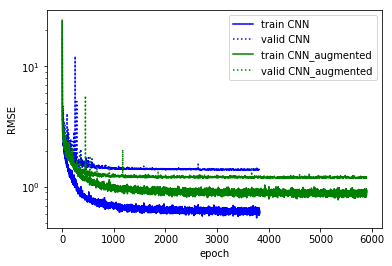

In [24]:
plot_loss([model2_hist, model2_augmented_hist],['CNN','CNN_augmented'])

The augmented data improves the validation RMSE by adding some variance to the training data.

### Add Dropout to avoid over-fitting and up the last hidden level

In [26]:
model3 = Sequential()
model3.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(.1))
model3.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(.2))
model3.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(.3))
model3.add(Flatten())
model3.add(Dense(500, activation = "relu"))
model3.add(Dropout(.5))
model3.add(BatchNormalization())
model3.add(Dense(500, activation = "relu"))
model3.add(BatchNormalization())
model3.add(Dense(30))
print(model3.summary())
model3_hist, model3 = fit_model(model3, data,
                                'CNN_aug_dropout',datagen,
                                patience=1000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization_17 (Batc (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 46, 46, 64)        8256      
_________________________________________________________________
batch_normalization_18 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 23, 23, 64)        0         
__________

Epoch 53/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0110 - val_loss: 0.0047
Epoch 54/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0115 - val_loss: 0.0756
Epoch 55/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0127 - val_loss: 0.0375
Epoch 56/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0129 - val_loss: 0.0203
Epoch 57/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0147 - val_loss: 0.0094
Epoch 58/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0100 - val_loss: 0.0096
Epoch 59/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0116 - val_loss: 0.0157
Epoch 60/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0113 - val_loss: 0.0094
Epoch 61/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0104 - val_loss: 0.0135
Epoch 62/10000
53/53 [==============================] - 3s 54ms/step - lo

53/53 [==============================] - 3s 52ms/step - loss: 0.0050 - val_loss: 0.0041
Epoch 133/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0044 - val_loss: 0.0021
Epoch 134/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0046 - val_loss: 0.0053
Epoch 135/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 136/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0043 - val_loss: 0.0033
Epoch 137/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0042 - val_loss: 0.0023
Epoch 138/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0042 - val_loss: 0.0104
Epoch 139/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0040 - val_loss: 0.0025
Epoch 140/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0051 - val_loss: 0.0109
Epoch 141/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.

Epoch 211/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 212/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 213/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 214/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 215/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 216/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 217/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 218/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 219/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 220/10000
53/53 [==============================] - 3s 51ms

53/53 [==============================] - 3s 53ms/step - loss: 0.0016 - val_loss: 9.4393e-04
Epoch 290/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0017 - val_loss: 9.5686e-04
Epoch 291/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0016 - val_loss: 9.3708e-04
Epoch 292/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0016 - val_loss: 9.1347e-04
Epoch 293/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 294/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 295/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 296/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 297/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 298/10000
53/53 [==============================] - 3s 52ms

53/53 [==============================] - 3s 54ms/step - loss: 0.0014 - val_loss: 8.3849e-04
Epoch 367/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0014 - val_loss: 8.5442e-04
Epoch 368/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0015 - val_loss: 8.6539e-04
Epoch 369/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0014 - val_loss: 8.1257e-04
Epoch 370/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0014 - val_loss: 9.4033e-04
Epoch 371/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0014 - val_loss: 8.2830e-04
Epoch 372/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 373/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0014 - val_loss: 8.5528e-04
Epoch 374/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 375/10000
53/53 [=============================

53/53 [==============================] - 3s 50ms/step - loss: 0.0013 - val_loss: 0.0058
Epoch 444/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0013 - val_loss: 0.0092
Epoch 445/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0013 - val_loss: 0.0073
Epoch 446/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0013 - val_loss: 0.0064
Epoch 447/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0014 - val_loss: 0.2497
Epoch 448/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0014 - val_loss: 8.7179e-04
Epoch 449/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0013 - val_loss: 8.1402e-04
Epoch 450/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0013 - val_loss: 9.5252e-04
Epoch 451/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0013 - val_loss: 8.5168e-04
Epoch 452/10000
53/53 [==============================] - 3s 52ms

53/53 [==============================] - 3s 51ms/step - loss: 0.0013 - val_loss: 7.3467e-04
Epoch 521/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0013 - val_loss: 8.8730e-04
Epoch 522/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0013 - val_loss: 7.8809e-04
Epoch 523/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0012 - val_loss: 9.3893e-04
Epoch 524/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 525/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 526/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 527/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 528/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 529/10000
53/53 [==============================] - 3s 53ms

53/53 [==============================] - 3s 50ms/step - loss: 0.0012 - val_loss: 0.9588
Epoch 599/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0012 - val_loss: 0.7880
Epoch 600/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0012 - val_loss: 0.6571
Epoch 601/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0012 - val_loss: 1.6166
Epoch 602/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0012 - val_loss: 3.2801
Epoch 603/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0012 - val_loss: 4.0125
Epoch 604/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0012 - val_loss: 4.6001
Epoch 605/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0012 - val_loss: 6.5303
Epoch 606/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0012 - val_loss: 10.6423
Epoch 607/10000
53/53 [==============================] - 3s 51ms/step - loss: 0

53/53 [==============================] - 3s 52ms/step - loss: 0.0012 - val_loss: 2.6443
Epoch 677/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0012 - val_loss: 0.2030
Epoch 678/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0012 - val_loss: 0.3989
Epoch 679/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0012 - val_loss: 0.6179
Epoch 680/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0012 - val_loss: 1.3532
Epoch 681/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0012 - val_loss: 2.0436
Epoch 682/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0012 - val_loss: 3.5932
Epoch 683/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0012 - val_loss: 8.2171e-04
Epoch 684/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0012 - val_loss: 8.1931e-04
Epoch 685/10000
53/53 [==============================] - 3s 52ms/step - 

53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 0.0192
Epoch 755/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0012 - val_loss: 0.0072
Epoch 756/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0012 - val_loss: 0.0058
Epoch 757/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 0.0105
Epoch 758/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 0.0190
Epoch 759/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 0.0058
Epoch 760/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0012 - val_loss: 0.0066
Epoch 761/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 762/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0011 - val_loss: 0.0464
Epoch 763/10000
53/53 [==============================] - 3s 54ms/step - loss: 0.

Epoch 832/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 0.0231
Epoch 833/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0011 - val_loss: 7.8544
Epoch 834/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 7.9790e-04
Epoch 835/10000
53/53 [==============================] - 3s 54ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 836/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 0.0393
Epoch 837/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0012 - val_loss: 9.7029e-04
Epoch 838/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 8.6460e-04
Epoch 839/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 840/10000
53/53 [==============================] - ETA: 0s - loss: 0.001 - 3s 52ms/step - loss: 0.0011 - val_loss: 0.0081
Epoch 841/10000
53/53 [=====

53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 6.5523e-04
Epoch 910/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 6.2898e-04
Epoch 911/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 6.8190e-04
Epoch 912/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0012 - val_loss: 7.8201e-04
Epoch 913/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 0.0144
Epoch 914/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 6.8669e-04
Epoch 915/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 6.9066e-04
Epoch 916/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 6.4278e-04
Epoch 917/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0011 - val_loss: 6.3860e-04
Epoch 918/10000
53/53 [=========================

53/53 [==============================] - 3s 52ms/step - loss: 0.0010 - val_loss: 1.1522
Epoch 986/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 6.9473e-04
Epoch 987/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0012 - val_loss: 6.2815e-04
Epoch 988/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0011 - val_loss: 7.2993e-04
Epoch 989/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0012 - val_loss: 9.9582e-04
Epoch 990/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 7.5708e-04
Epoch 991/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 7.6889e-04
Epoch 992/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 993/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0011 - val_loss: 0.0070
Epoch 994/10000
53/53 [==============================] -

53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 10.1982
Epoch 1063/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 5.2737
Epoch 1064/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0010 - val_loss: 0.6751
Epoch 1065/10000
53/53 [==============================] - 3s 54ms/step - loss: 0.0010 - val_loss: 4.1038
Epoch 1066/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 7.6648e-04
Epoch 1067/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 0.0203
Epoch 1068/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0010 - val_loss: 61.2087
Epoch 1069/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0010 - val_loss: 6.6566e-04
Epoch 1070/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 6.7602e-04
Epoch 1071/10000
53/53 [==============================] - 

53/53 [==============================] - 3s 53ms/step - loss: 0.0010 - val_loss: 7.3819e-04
Epoch 1139/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 0.0125
Epoch 1140/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0011 - val_loss: 8.8532e-04
Epoch 1141/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 9.7960e-04
Epoch 1142/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.9924e-04 - val_loss: 7.2243e-04
Epoch 1143/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0010 - val_loss: 8.5259e-04
Epoch 1144/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0011 - val_loss: 5.3439
Epoch 1145/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 1500.2721
Epoch 1146/10000
53/53 [==============================] - 3s 55ms/step - loss: 0.0012 - val_loss: 7.4531e-04
Epoch 1147/10000
53/53 [=================

Epoch 1215/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0010 - val_loss: 6.7310e-04
Epoch 1216/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 6.7771e-04
Epoch 1217/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0010 - val_loss: 6.2046e-04
Epoch 1218/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0010 - val_loss: 6.8333e-04
Epoch 1219/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0010 - val_loss: 8.4934e-04
Epoch 1220/10000
53/53 [==============================] - 3s 55ms/step - loss: 0.0010 - val_loss: 6.8197e-04
Epoch 1221/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0010 - val_loss: 7.3526e-04
Epoch 1222/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0010 - val_loss: 7.4565e-04
Epoch 1223/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0010 - val_loss: 8.4097e-04
Epoch 1224/10000
53

Epoch 1291/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.8890e-04 - val_loss: 0.0017
Epoch 1292/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.8149e-04 - val_loss: 0.0043
Epoch 1293/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0010 - val_loss: 0.0065
Epoch 1294/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.9548e-04 - val_loss: 0.0039
Epoch 1295/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.7190e-04 - val_loss: 0.0183
Epoch 1296/10000
53/53 [==============================] - 3s 50ms/step - loss: 9.9481e-04 - val_loss: 0.0017
Epoch 1297/10000
53/53 [==============================] - 3s 50ms/step - loss: 9.8768e-04 - val_loss: 0.0732
Epoch 1298/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 1299/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0011 - val_loss: 0.0054
Epoch 1300/10000
53/53 [=======

53/53 [==============================] - 3s 52ms/step - loss: 0.0010 - val_loss: 8.4975e-04
Epoch 1368/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0010 - val_loss: 7.2072e-04
Epoch 1369/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0010 - val_loss: 7.7849e-04
Epoch 1370/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 7.0179e-04
Epoch 1371/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 8.7484e-04
Epoch 1372/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 1373/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0010 - val_loss: 7.6332e-04
Epoch 1374/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.8453e-04 - val_loss: 0.0013
Epoch 1375/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.9290e-04 - val_loss: 7.9386e-04
Epoch 1376/10000
53/53 [============

53/53 [==============================] - 3s 54ms/step - loss: 9.6271e-04 - val_loss: 6.7982e-04
Epoch 1443/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.5868e-04 - val_loss: 7.4635e-04
Epoch 1444/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0010 - val_loss: 7.2007e-04
Epoch 1445/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.6775e-04 - val_loss: 0.0019
Epoch 1446/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0010 - val_loss: 0.0041
Epoch 1447/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 1448/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0010 - val_loss: 0.0033
Epoch 1449/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.8200e-04 - val_loss: 0.0062
Epoch 1450/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.8273e-04 - val_loss: 0.0356
Epoch 1451/10000
53/53 [================

Epoch 1518/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.7016e-04 - val_loss: 0.0013
Epoch 1519/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.9454e-04 - val_loss: 0.0014
Epoch 1520/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.6430e-04 - val_loss: 7.7415e-04
Epoch 1521/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.9970e-04 - val_loss: 0.0019
Epoch 1522/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.2798e-04 - val_loss: 0.0018
Epoch 1523/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0010 - val_loss: 0.0056
Epoch 1524/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0010 - val_loss: 0.0030
Epoch 1525/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.5130e-04 - val_loss: 0.0034
Epoch 1526/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.6858e-04 - val_loss: 0.0056
Epoch 1527/10000
53/53 

53/53 [==============================] - 3s 52ms/step - loss: 9.8563e-04 - val_loss: 7.4573e-04
Epoch 1592/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.3939e-04 - val_loss: 6.7925e-04
Epoch 1593/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.8033e-04 - val_loss: 7.2893e-04
Epoch 1594/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.9979e-04 - val_loss: 6.2462e-04
Epoch 1595/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.3692e-04 - val_loss: 6.2438e-04
Epoch 1596/10000
53/53 [==============================] - 3s 50ms/step - loss: 9.8836e-04 - val_loss: 6.0319e-04
Epoch 1597/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.5411e-04 - val_loss: 6.6432e-04
Epoch 1598/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.6869e-04 - val_loss: 0.0012
Epoch 1599/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.3738e-04 - val_loss: 7.2321e-04
Epoc

53/53 [==============================] - 3s 52ms/step - loss: 9.5797e-04 - val_loss: 6.9302e-04
Epoch 1665/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.7732e-04 - val_loss: 7.1774e-04
Epoch 1666/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.9562e-04 - val_loss: 9.6948e-04
Epoch 1667/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0010 - val_loss: 0.0099
Epoch 1668/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.7235e-04 - val_loss: 0.0059
Epoch 1669/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.6108e-04 - val_loss: 9.1873e-04
Epoch 1670/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.6013e-04 - val_loss: 5.7856e-04
Epoch 1671/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.5400e-04 - val_loss: 5.8644e-04
Epoch 1672/10000
53/53 [==============================] - 3s 55ms/step - loss: 9.4397e-04 - val_loss: 6.0412e-04
Epoch 1673/1

53/53 [==============================] - 3s 50ms/step - loss: 0.0010 - val_loss: 5.9446e-04
Epoch 1738/10000
53/53 [==============================] - 3s 50ms/step - loss: 9.2658e-04 - val_loss: 5.8367e-04
Epoch 1739/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.9391e-04 - val_loss: 6.0258e-04
Epoch 1740/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.9198e-04 - val_loss: 6.0767e-04
Epoch 1741/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.6566e-04 - val_loss: 5.6796e-04
Epoch 1742/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.7782e-04 - val_loss: 6.3073e-04
Epoch 1743/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.5823e-04 - val_loss: 6.0975e-04
Epoch 1744/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.5651e-04 - val_loss: 5.8765e-04
Epoch 1745/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.5809e-04 - val_loss: 6.0840e-04
Epoc

53/53 [==============================] - 3s 52ms/step - loss: 9.9115e-04 - val_loss: 6.3350e-04
Epoch 1811/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.0858e-04 - val_loss: 6.2305e-04
Epoch 1812/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0010 - val_loss: 6.6388e-04
Epoch 1813/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.5042e-04 - val_loss: 6.2624e-04
Epoch 1814/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.9939e-04 - val_loss: 5.9623e-04
Epoch 1815/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.3979e-04 - val_loss: 5.9861e-04
Epoch 1816/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.5373e-04 - val_loss: 1.5815
Epoch 1817/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.6279e-04 - val_loss: 7.0298e-04
Epoch 1818/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0010 - val_loss: 5.8637e-04
Epoch 1819/1

53/53 [==============================] - 3s 52ms/step - loss: 8.8230e-04 - val_loss: 6.3285e-04
Epoch 1884/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.4887e-04 - val_loss: 8.6732e-04
Epoch 1885/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.6678e-04 - val_loss: 9.9353e-04
Epoch 1886/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.3350e-04 - val_loss: 8.3312e-04
Epoch 1887/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.5682e-04 - val_loss: 0.0021
Epoch 1888/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.5438e-04 - val_loss: 0.0013
Epoch 1889/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.1822e-04 - val_loss: 6.2216e-04
Epoch 1890/10000
53/53 [==============================] - 3s 50ms/step - loss: 9.1579e-04 - val_loss: 6.8600e-04
Epoch 1891/10000
53/53 [==============================] - 3s 50ms/step - loss: 9.9226e-04 - val_loss: 0.0015
Epoch 1892/1

53/53 [==============================] - 3s 52ms/step - loss: 9.6012e-04 - val_loss: 0.0020
Epoch 1958/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.3044e-04 - val_loss: 0.0018
Epoch 1959/10000
53/53 [==============================] - 3s 54ms/step - loss: 9.6534e-04 - val_loss: 0.0023
Epoch 1960/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.9359e-04 - val_loss: 0.0062
Epoch 1961/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.6734e-04 - val_loss: 3.6557
Epoch 1962/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0010 - val_loss: 3.7979
Epoch 1963/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.8057e-04 - val_loss: 6.4083
Epoch 1964/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.0430e-04 - val_loss: 1.7476
Epoch 1965/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.6330e-04 - val_loss: 1.5488
Epoch 1966/10000
53/53 [================

53/53 [==============================] - 3s 51ms/step - loss: 9.6424e-04 - val_loss: 7.5901e-04
Epoch 2032/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.6938e-04 - val_loss: 6.4815e-04
Epoch 2033/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.1898e-04 - val_loss: 6.1761e-04
Epoch 2034/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.2360e-04 - val_loss: 7.2994e-04
Epoch 2035/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.9589e-04 - val_loss: 8.3774e-04
Epoch 2036/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.0102e-04 - val_loss: 5.8992e-04
Epoch 2037/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.2286e-04 - val_loss: 5.9882e-04
Epoch 2038/10000
53/53 [==============================] - 3s 54ms/step - loss: 9.6574e-04 - val_loss: 7.4737e-04
Epoch 2039/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.2668e-04 - val_loss: 7.9919e-04


Epoch 2105/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.3211e-04 - val_loss: 6.1957e-04
Epoch 2106/10000
53/53 [==============================] - 3s 50ms/step - loss: 9.2209e-04 - val_loss: 7.1976e-04
Epoch 2107/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.7657e-04 - val_loss: 6.5491e-04
Epoch 2108/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.7238e-04 - val_loss: 7.8638e-04
Epoch 2109/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.4899e-04 - val_loss: 0.0011
Epoch 2110/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.4597e-04 - val_loss: 6.1029e-04
Epoch 2111/10000
53/53 [==============================] - 3s 50ms/step - loss: 9.3829e-04 - val_loss: 5.6542e-04
Epoch 2112/10000
53/53 [==============================] - 3s 55ms/step - loss: 9.1245e-04 - val_loss: 6.0010e-04
Epoch 2113/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.0574e-04 - val_loss

Epoch 2179/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.9277e-04 - val_loss: 0.0010
Epoch 2180/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.9434e-04 - val_loss: 7.8329e-04
Epoch 2181/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.8824e-04 - val_loss: 6.3908e-04
Epoch 2182/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.3130e-04 - val_loss: 2.9508
Epoch 2183/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.1347e-04 - val_loss: 0.0056
Epoch 2184/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.1410e-04 - val_loss: 6.1895e-04
Epoch 2185/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.4047e-04 - val_loss: 7.5924e-04
Epoch 2186/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.0971e-04 - val_loss: 0.0013
Epoch 2187/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.1547e-04 - val_loss: 0.0014
Epo

53/53 [==============================] - 3s 52ms/step - loss: 8.9987e-04 - val_loss: 0.0038
Epoch 2254/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.1927e-04 - val_loss: 0.0050
Epoch 2255/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.5579e-04 - val_loss: 8.4532e-04
Epoch 2256/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.2868e-04 - val_loss: 9.2361e-04
Epoch 2257/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.3197e-04 - val_loss: 0.0026
Epoch 2258/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.2798e-04 - val_loss: 0.0027
Epoch 2259/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.2526e-04 - val_loss: 0.0075
Epoch 2260/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.9913e-04 - val_loss: 0.0247
Epoch 2261/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.0666e-04 - val_loss: 0.0016
Epoch 2262/10000
53/53 [====

53/53 [==============================] - 3s 51ms/step - loss: 8.8777e-04 - val_loss: 7.1699e-04
Epoch 2327/10000
53/53 [==============================] - 3s 54ms/step - loss: 8.8896e-04 - val_loss: 8.7722e-04
Epoch 2328/10000
53/53 [==============================] - 3s 50ms/step - loss: 9.1936e-04 - val_loss: 0.0013
Epoch 2329/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.8144e-04 - val_loss: 0.0033
Epoch 2330/10000
53/53 [==============================] - 3s 54ms/step - loss: 9.4163e-04 - val_loss: 0.0018
Epoch 2331/10000
53/53 [==============================] - 3s 54ms/step - loss: 9.2602e-04 - val_loss: 0.0030
Epoch 2332/10000
53/53 [==============================] - 3s 55ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 2333/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 2334/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.8791e-04 - val_loss: 0.0012
Epoch 2335/10000
53/53 [============

53/53 [==============================] - 3s 54ms/step - loss: 9.4833e-04 - val_loss: 5.9857e-04
Epoch 2401/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.9920e-04 - val_loss: 58.7097
Epoch 2402/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.1204e-04 - val_loss: 6.7112e-04
Epoch 2403/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.0105e-04 - val_loss: 5.9832e-04
Epoch 2404/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.9440e-04 - val_loss: 6.4637e-04
Epoch 2405/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.2315e-04 - val_loss: 6.8701e-04
Epoch 2406/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.2024e-04 - val_loss: 9.2007e-04
Epoch 2407/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.9182e-04 - val_loss: 7.1610e-04
Epoch 2408/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.6995e-04 - val_loss: 0.0044
Epoch 2

Epoch 2473/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.7883e-04 - val_loss: 0.0018
Epoch 2474/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.1455e-04 - val_loss: 7.1580e-04
Epoch 2475/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.3059e-04 - val_loss: 6.8006e-04
Epoch 2476/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.1289e-04 - val_loss: 6.0481e-04
Epoch 2477/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.3000e-04 - val_loss: 6.7012e-04
Epoch 2478/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.0872e-04 - val_loss: 0.0017
Epoch 2479/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.4816e-04 - val_loss: 6.0050e-04
Epoch 2480/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.6322e-04 - val_loss: 5.8501e-04
Epoch 2481/10000
53/53 [==============================] - 3s 54ms/step - loss: 9.2522e-04 - val_loss: 5.

53/53 [==============================] - 3s 53ms/step - loss: 9.1920e-04 - val_loss: 0.0736
Epoch 2547/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.8779e-04 - val_loss: 0.0723
Epoch 2548/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.5523e-04 - val_loss: 0.2012
Epoch 2549/10000
53/53 [==============================] - 3s 50ms/step - loss: 9.1202e-04 - val_loss: 0.0520
Epoch 2550/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.0669e-04 - val_loss: 0.0823
Epoch 2551/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.2148e-04 - val_loss: 0.0115
Epoch 2552/10000
53/53 [==============================] - 3s 55ms/step - loss: 8.6534e-04 - val_loss: 0.0053
Epoch 2553/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.1150e-04 - val_loss: 0.0025
Epoch 2554/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.8131e-04 - val_loss: 0.0034
Epoch 2555/10000
53/53 [============

53/53 [==============================] - 3s 54ms/step - loss: 9.6085e-04 - val_loss: 0.0020
Epoch 2622/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.3745e-04 - val_loss: 0.0011
Epoch 2623/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.0023e-04 - val_loss: 0.0011
Epoch 2624/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.1250e-04 - val_loss: 0.0013
Epoch 2625/10000
53/53 [==============================] - 3s 54ms/step - loss: 8.8805e-04 - val_loss: 0.0023
Epoch 2626/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.4399e-04 - val_loss: 0.0012
Epoch 2627/10000
53/53 [==============================] - 3s 54ms/step - loss: 8.4736e-04 - val_loss: 6.8699e-04
Epoch 2628/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.2713e-04 - val_loss: 7.4534e-04
Epoch 2629/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0010 - val_loss: 1.5530
Epoch 2630/10000
53/53 [========

53/53 [==============================] - 3s 51ms/step - loss: 9.9279e-04 - val_loss: 44.6868
Epoch 2696/10000
53/53 [==============================] - 3s 50ms/step - loss: 9.1757e-04 - val_loss: 0.0011
Epoch 2697/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.3727e-04 - val_loss: 8.2355e-04
Epoch 2698/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.7909e-04 - val_loss: 0.0010
Epoch 2699/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.9125e-04 - val_loss: 8.5848e-04
Epoch 2700/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.9843e-04 - val_loss: 6.5527e-04
Epoch 2701/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.1640e-04 - val_loss: 6.5866e-04
Epoch 2702/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.4621e-04 - val_loss: 6.8471e-04
Epoch 2703/10000
53/53 [==============================] - 3s 50ms/step - loss: 9.1218e-04 - val_loss: 7.1881e-04
Epoch 2704/

53/53 [==============================] - 3s 53ms/step - loss: 8.9315e-04 - val_loss: 6.1528e-04
Epoch 2769/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.4136e-04 - val_loss: 5.7563e-04
Epoch 2770/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.4996e-04 - val_loss: 5.9553e-04
Epoch 2771/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.6520e-04 - val_loss: 6.1840e-04
Epoch 2772/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.4692e-04 - val_loss: 5.9664e-04
Epoch 2773/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.1800e-04 - val_loss: 5.7384e-04
Epoch 2774/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.8147e-04 - val_loss: 5.7147e-04
Epoch 2775/10000
53/53 [==============================] - 3s 55ms/step - loss: 8.8230e-04 - val_loss: 5.7226e-04
Epoch 2776/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.9724e-04 - val_loss: 6.1783e-04


53/53 [==============================] - 3s 53ms/step - loss: 8.3438e-04 - val_loss: 6.1141e-04
Epoch 2841/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.1294e-04 - val_loss: 5.6584e-04
Epoch 2842/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.5766e-04 - val_loss: 5.7059e-04
Epoch 2843/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.7727e-04 - val_loss: 5.7642e-04
Epoch 2844/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.6830e-04 - val_loss: 6.1639e-04
Epoch 2845/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.8055e-04 - val_loss: 6.1504e-04
Epoch 2846/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.8970e-04 - val_loss: 6.0819e-04
Epoch 2847/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.6430e-04 - val_loss: 5.9214e-04
Epoch 2848/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.4278e-04 - val_loss: 6.0815e-04


Epoch 2913/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.7162e-04 - val_loss: 6.2770e-04
Epoch 2914/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.9544e-04 - val_loss: 6.2542e-04
Epoch 2915/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.7632e-04 - val_loss: 5.8699e-04
Epoch 2916/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.9915e-04 - val_loss: 6.0617e-04
Epoch 2917/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.8126e-04 - val_loss: 6.3380e-04
Epoch 2918/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.2801e-04 - val_loss: 5.7855e-04
Epoch 2919/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.9669e-04 - val_loss: 6.0424e-04
Epoch 2920/10000
53/53 [==============================] - 3s 50ms/step - loss: 9.4017e-04 - val_loss: 5.6757e-04
Epoch 2921/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.5382e-04 - val_

53/53 [==============================] - 3s 52ms/step - loss: 9.4949e-04 - val_loss: 5.8661e-04
Epoch 2986/10000
53/53 [==============================] - 3s 54ms/step - loss: 8.8525e-04 - val_loss: 6.0565e-04
Epoch 2987/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.8724e-04 - val_loss: 5.8618e-04
Epoch 2988/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.0066e-04 - val_loss: 6.1633e-04
Epoch 2989/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.0406e-04 - val_loss: 5.6200e-04
Epoch 2990/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.7469e-04 - val_loss: 5.8185e-04
Epoch 2991/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.0599e-04 - val_loss: 6.0636e-04
Epoch 2992/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.2096e-04 - val_loss: 5.8643e-04
Epoch 2993/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.6821e-04 - val_loss: 5.9140e-04


Epoch 3058/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.2545e-04 - val_loss: 6.0391e-04
Epoch 3059/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.6412e-04 - val_loss: 6.1298e-04
Epoch 3060/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.9388e-04 - val_loss: 6.0176e-04
Epoch 3061/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.8113e-04 - val_loss: 5.9254e-04
Epoch 3062/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.9937e-04 - val_loss: 6.4700e-04
Epoch 3063/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.1453e-04 - val_loss: 5.7890e-04
Epoch 3064/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.7215e-04 - val_loss: 5.6574e-04
Epoch 3065/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.6847e-04 - val_loss: 5.7597e-04
Epoch 3066/10000
53/53 [==============================] - 3s 54ms/step - loss: 8.1863e-04 - val_

53/53 [==============================] - 3s 51ms/step - loss: 8.7251e-04 - val_loss: 5.6399e-04
Epoch 3131/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.8811e-04 - val_loss: 5.6900e-04
Epoch 3132/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.9324e-04 - val_loss: 6.0998e-04
Epoch 3133/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.8649e-04 - val_loss: 5.4830e-04
Epoch 3134/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.4322e-04 - val_loss: 5.7098e-04
Epoch 3135/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.6371e-04 - val_loss: 5.8017e-04
Epoch 3136/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.2955e-04 - val_loss: 5.7365e-04
Epoch 3137/10000
53/53 [==============================] - 3s 50ms/step - loss: 9.0260e-04 - val_loss: 6.0014e-04
Epoch 3138/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.4361e-04 - val_loss: 5.4916e-04


Epoch 3203/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.4745e-04 - val_loss: 5.8355e-04
Epoch 3204/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.2356e-04 - val_loss: 5.3726e-04
Epoch 3205/10000
53/53 [==============================] - 3s 50ms/step - loss: 9.0304e-04 - val_loss: 5.6465e-04
Epoch 3206/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.7736e-04 - val_loss: 5.4828e-04
Epoch 3207/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.7515e-04 - val_loss: 5.6524e-04
Epoch 3208/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.5072e-04 - val_loss: 5.7366e-04
Epoch 3209/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.8293e-04 - val_loss: 5.5308e-04
Epoch 3210/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.8832e-04 - val_loss: 5.8333e-04
Epoch 3211/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.3410e-04 - val_

53/53 [==============================] - 3s 52ms/step - loss: 8.7749e-04 - val_loss: 5.8292e-04
Epoch 3276/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.4251e-04 - val_loss: 5.9852e-04
Epoch 3277/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.3713e-04 - val_loss: 6.0611e-04
Epoch 3278/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.5334e-04 - val_loss: 6.0146e-04
Epoch 3279/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.1147e-04 - val_loss: 5.8587e-04
Epoch 3280/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.9709e-04 - val_loss: 5.9884e-04
Epoch 3281/10000
53/53 [==============================] - 3s 54ms/step - loss: 8.6903e-04 - val_loss: 5.4969e-04
Epoch 3282/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.8777e-04 - val_loss: 5.5745e-04
Epoch 3283/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.3729e-04 - val_loss: 5.9694e-04


Epoch 3348/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.8909e-04 - val_loss: 6.2959e-04
Epoch 3349/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.7473e-04 - val_loss: 5.4330e-04
Epoch 3350/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.6430e-04 - val_loss: 5.3700e-04
Epoch 3351/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.9748e-04 - val_loss: 0.0010
Epoch 3352/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.6777e-04 - val_loss: 5.6423e-04
Epoch 3353/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.6945e-04 - val_loss: 5.4842e-04
Epoch 3354/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.5289e-04 - val_loss: 5.8041e-04
Epoch 3355/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.1558e-04 - val_loss: 5.5632e-04
Epoch 3356/10000
53/53 [==============================] - 3s 50ms/step - loss: 9.2119e-04 - val_loss

53/53 [==============================] - 3s 52ms/step - loss: 8.5723e-04 - val_loss: 5.8057e-04
Epoch 3421/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.6701e-04 - val_loss: 5.4747e-04
Epoch 3422/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.4807e-04 - val_loss: 5.5348e-04
Epoch 3423/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.7116e-04 - val_loss: 6.3475e-04
Epoch 3424/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.4754e-04 - val_loss: 5.8075e-04
Epoch 3425/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.7015e-04 - val_loss: 5.6332e-04
Epoch 3426/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.5277e-04 - val_loss: 6.1024e-04
Epoch 3427/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.2650e-04 - val_loss: 5.5255e-04
Epoch 3428/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.0777e-04 - val_loss: 5.6008e-04


53/53 [==============================] - 3s 52ms/step - loss: 8.7226e-04 - val_loss: 5.7995e-04
Epoch 3493/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.2226e-04 - val_loss: 5.5049e-04
Epoch 3494/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.1936e-04 - val_loss: 5.6688e-04
Epoch 3495/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.8733e-04 - val_loss: 5.5107e-04
Epoch 3496/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.9745e-04 - val_loss: 5.6900e-04
Epoch 3497/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.3014e-04 - val_loss: 5.7096e-04
Epoch 3498/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.6359e-04 - val_loss: 5.6194e-04
Epoch 3499/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.7705e-04 - val_loss: 6.7150e-04
Epoch 3500/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.4166e-04 - val_loss: 5.5187e-04


53/53 [==============================] - 3s 51ms/step - loss: 8.7217e-04 - val_loss: 5.8211e-04
Epoch 3565/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.7090e-04 - val_loss: 5.5695e-04
Epoch 3566/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.7464e-04 - val_loss: 5.3838e-04
Epoch 3567/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.6743e-04 - val_loss: 5.6234e-04
Epoch 3568/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.6305e-04 - val_loss: 6.2599e-04
Epoch 3569/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.3128e-04 - val_loss: 5.7324e-04
Epoch 3570/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.9241e-04 - val_loss: 5.4510e-04
Epoch 3571/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.7896e-04 - val_loss: 5.8856e-04
Epoch 3572/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.6843e-04 - val_loss: 2.0856
Epoc

Epoch 3637/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.6785e-04 - val_loss: 6.4207e-04
Epoch 3638/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.3850e-04 - val_loss: 5.7086e-04
Epoch 3639/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.6330e-04 - val_loss: 5.8184e-04
Epoch 3640/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.9957e-04 - val_loss: 5.5979e-04
Epoch 3641/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.2000e-04 - val_loss: 5.6760e-04
Epoch 3642/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.5708e-04 - val_loss: 6.7241e-04
Epoch 3643/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.8051e-04 - val_loss: 5.6356e-04
Epoch 3644/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.5033e-04 - val_loss: 5.7971e-04
Epoch 3645/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.7597e-04 - val_

53/53 [==============================] - 3s 51ms/step - loss: 9.1026e-04 - val_loss: 5.1766
Epoch 3710/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.3858e-04 - val_loss: 6.1490e-04
Epoch 3711/10000
53/53 [==============================] - 3s 54ms/step - loss: 8.7999e-04 - val_loss: 5.5815e-04
Epoch 3712/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.1536e-04 - val_loss: 5.4930e-04
Epoch 3713/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.5846e-04 - val_loss: 5.5407e-04
Epoch 3714/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.8314e-04 - val_loss: 6.1105e-04
Epoch 3715/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.5223e-04 - val_loss: 5.6367e-04
Epoch 3716/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.7868e-04 - val_loss: 5.4275e-04
Epoch 3717/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.9587e-04 - val_loss: 5.3578e-04
Epoc

Epoch 3782/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.1501e-04 - val_loss: 6.0115e-04
Epoch 3783/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.4454e-04 - val_loss: 5.7777e-04
Epoch 3784/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.4709e-04 - val_loss: 5.4573e-04
Epoch 3785/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.2509e-04 - val_loss: 5.7604e-04
Epoch 3786/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.4685e-04 - val_loss: 5.3488e-04
Epoch 3787/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.3847e-04 - val_loss: 5.6746e-04
Epoch 3788/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.6723e-04 - val_loss: 5.7742e-04
Epoch 3789/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.4114e-04 - val_loss: 0.0601
Epoch 3790/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.5852e-04 - val_loss

53/53 [==============================] - 3s 52ms/step - loss: 8.9956e-04 - val_loss: 5.9042e-04
Epoch 3855/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.3019e-04 - val_loss: 5.4510e-04
Epoch 3856/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.8553e-04 - val_loss: 5.6128e-04
Epoch 3857/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.7303e-04 - val_loss: 6.0372e-04
Epoch 3858/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.3418e-04 - val_loss: 5.5232e-04
Epoch 3859/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.4245e-04 - val_loss: 5.7311e-04
Epoch 3860/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.4538e-04 - val_loss: 5.3097e-04
Epoch 3861/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.6749e-04 - val_loss: 6.4021e-04
Epoch 3862/10000
53/53 [==============================] - 3s 52ms/step - loss: 7.9216e-04 - val_loss: 5.5126e-04


53/53 [==============================] - 3s 51ms/step - loss: 9.0055e-04 - val_loss: 5.7575e-04
Epoch 3927/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.5283e-04 - val_loss: 5.7754e-04
Epoch 3928/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.3436e-04 - val_loss: 5.3122e-04
Epoch 3929/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.2791e-04 - val_loss: 5.8341e-04
Epoch 3930/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.5904e-04 - val_loss: 5.3973e-04
Epoch 3931/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.7255e-04 - val_loss: 5.4330e-04
Epoch 3932/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.7957e-04 - val_loss: 5.5532e-04
Epoch 3933/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.4908e-04 - val_loss: 5.5128e-04
Epoch 3934/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.8798e-04 - val_loss: 5.6745e-04


53/53 [==============================] - 3s 51ms/step - loss: 8.6351e-04 - val_loss: 5.8983e-04
Epoch 3999/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.8622e-04 - val_loss: 6.2562e-04
Epoch 4000/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.6221e-04 - val_loss: 5.7294e-04
Epoch 4001/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.7054e-04 - val_loss: 5.5176e-04
Epoch 4002/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.2455e-04 - val_loss: 5.8129e-04
Epoch 4003/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.5834e-04 - val_loss: 5.7274e-04
Epoch 4004/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.1816e-04 - val_loss: 5.8096e-04
Epoch 4005/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.3543e-04 - val_loss: 5.6060e-04
Epoch 4006/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.3683e-04 - val_loss: 6.6706e-04


53/53 [==============================] - 3s 53ms/step - loss: 8.4957e-04 - val_loss: 6.1346e-04
Epoch 4071/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.3280e-04 - val_loss: 5.5182e-04
Epoch 4072/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.3089e-04 - val_loss: 5.5405e-04
Epoch 4073/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.6380e-04 - val_loss: 5.4330e-04
Epoch 4074/10000
53/53 [==============================] - 3s 51ms/step - loss: 7.7465e-04 - val_loss: 5.5681e-04
Epoch 4075/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.4243e-04 - val_loss: 5.9375e-04
Epoch 4076/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.4537e-04 - val_loss: 6.0780e-04
Epoch 4077/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.6486e-04 - val_loss: 5.6546e-04
Epoch 4078/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.3015e-04 - val_loss: 5.6691e-04


53/53 [==============================] - 3s 53ms/step - loss: 8.3254e-04 - val_loss: 6.7464e-04
Epoch 4143/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.6687e-04 - val_loss: 7.5620e-04
Epoch 4144/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.5372e-04 - val_loss: 7.0928e-04
Epoch 4145/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.8433e-04 - val_loss: 6.4811e-04
Epoch 4146/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.1482e-04 - val_loss: 7.3947e-04
Epoch 4147/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.7453e-04 - val_loss: 6.9321e-04
Epoch 4148/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.8463e-04 - val_loss: 8.7088e-04
Epoch 4149/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.6201e-04 - val_loss: 6.7064e-04
Epoch 4150/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.5486e-04 - val_loss: 6.5430e-04


Epoch 4215/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.4447e-04 - val_loss: 5.3965e-04
Epoch 4216/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.3984e-04 - val_loss: 5.8505e-04
Epoch 4217/10000
53/53 [==============================] - 3s 52ms/step - loss: 7.9772e-04 - val_loss: 5.8051e-04
Epoch 4218/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.9696e-04 - val_loss: 5.3031e-04
Epoch 4219/10000
53/53 [==============================] - 3s 54ms/step - loss: 8.6934e-04 - val_loss: 5.2559e-04
Epoch 4220/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.3265e-04 - val_loss: 5.3484e-04
Epoch 4221/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.6006e-04 - val_loss: 5.7659e-04
Epoch 4222/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.1899e-04 - val_loss: 5.7383e-04
Epoch 4223/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.6105e-04 - val_

Epoch 4288/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.2519e-04 - val_loss: 5.2978e-04
Epoch 4289/10000
53/53 [==============================] - 3s 54ms/step - loss: 8.2620e-04 - val_loss: 5.6419e-04
Epoch 4290/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.7612e-04 - val_loss: 5.5946e-04
Epoch 4291/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.5321e-04 - val_loss: 5.6129e-04
Epoch 4292/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.3731e-04 - val_loss: 5.3899e-04
Epoch 4293/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.0707e-04 - val_loss: 5.7510e-04
Epoch 4294/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.0802e-04 - val_loss: 6.7548e-04
Epoch 4295/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.3917e-04 - val_loss: 5.8525e-04
Epoch 4296/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.3743e-04 - val_

53/53 [==============================] - 3s 51ms/step - loss: 8.8154e-04 - val_loss: 7.8838
Epoch 4361/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0010 - val_loss: 0.0328
Epoch 4362/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.5738e-04 - val_loss: 7.1077e-04
Epoch 4363/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.9628e-04 - val_loss: 6.3490e-04
Epoch 4364/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.6147e-04 - val_loss: 6.5257e-04
Epoch 4365/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.9161e-04 - val_loss: 6.6920e-04
Epoch 4366/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.6783e-04 - val_loss: 5.9000e-04
Epoch 4367/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.3405e-04 - val_loss: 6.3192e-04
Epoch 4368/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.1453e-04 - val_loss: 6.2083e-04
Epoch 4369/1

Epoch 4433/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.5301e-04 - val_loss: 5.4736e-04
Epoch 4434/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.1773e-04 - val_loss: 7.2415e-04
Epoch 4435/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.3291e-04 - val_loss: 7.1179e-04
Epoch 4436/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.8636e-04 - val_loss: 7.4704e-04
Epoch 4437/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.8719e-04 - val_loss: 6.6748e-04
Epoch 4438/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.8984e-04 - val_loss: 5.6684e-04
Epoch 4439/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.5662e-04 - val_loss: 5.8523e-04
Epoch 4440/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.3102e-04 - val_loss: 5.7985e-04
Epoch 4441/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.5614e-04 - val_

53/53 [==============================] - 3s 52ms/step - loss: 7.7953e-04 - val_loss: 5.6566e-04
Epoch 4506/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.7975e-04 - val_loss: 5.8004e-04
Epoch 4507/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.0065e-04 - val_loss: 5.4660e-04
Epoch 4508/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.5466e-04 - val_loss: 5.9738e-04
Epoch 4509/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.2954e-04 - val_loss: 5.3962e-04
Epoch 4510/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.7856e-04 - val_loss: 5.5066e-04
Epoch 4511/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.5869e-04 - val_loss: 5.8869e-04
Epoch 4512/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.2720e-04 - val_loss: 5.7288e-04
Epoch 4513/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.3328e-04 - val_loss: 5.6863e-04


53/53 [==============================] - 3s 55ms/step - loss: 8.1558e-04 - val_loss: 5.6886e-04
Epoch 4578/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.5735e-04 - val_loss: 5.5213e-04
Epoch 4579/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.3616e-04 - val_loss: 5.9344e-04
Epoch 4580/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.5917e-04 - val_loss: 5.6444e-04
Epoch 4581/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.0609e-04 - val_loss: 5.8490e-04
Epoch 4582/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.3416e-04 - val_loss: 6.0626e-04
Epoch 4583/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.1171e-04 - val_loss: 5.8510e-04
Epoch 4584/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.1302e-04 - val_loss: 5.6993e-04
Epoch 4585/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.4787e-04 - val_loss: 5.6522e-04


53/53 [==============================] - 3s 50ms/step - loss: 8.2979e-04 - val_loss: 5.3290e-04
Epoch 4650/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.2676e-04 - val_loss: 5.4338e-04
Epoch 4651/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.5853e-04 - val_loss: 5.4850e-04
Epoch 4652/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.1612e-04 - val_loss: 6.4630e-04
Epoch 4653/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.5169e-04 - val_loss: 5.4469e-04
Epoch 4654/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.3834e-04 - val_loss: 5.3164e-04
Epoch 4655/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.8176e-04 - val_loss: 5.7571e-04
Epoch 4656/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.4914e-04 - val_loss: 5.5227e-04
Epoch 4657/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.8750e-04 - val_loss: 5.6110e-04


53/53 [==============================] - 3s 51ms/step - loss: 8.7207e-04 - val_loss: 5.2391e-04
Epoch 4722/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.6873e-04 - val_loss: 5.3801e-04
Epoch 4723/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.3353e-04 - val_loss: 6.1098e-04
Epoch 4724/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.6705e-04 - val_loss: 5.8098e-04
Epoch 4725/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.4228e-04 - val_loss: 5.8302e-04
Epoch 4726/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.7256e-04 - val_loss: 5.9363e-04
Epoch 4727/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.4314e-04 - val_loss: 5.7572e-04
Epoch 4728/10000
53/53 [==============================] - 3s 54ms/step - loss: 8.8164e-04 - val_loss: 5.8189e-04
Epoch 4729/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.8916e-04 - val_loss: 5.5679e-04


53/53 [==============================] - 3s 52ms/step - loss: 8.1145e-04 - val_loss: 5.7995e-04
Epoch 4794/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.7097e-04 - val_loss: 5.8694e-04
Epoch 4795/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.1597e-04 - val_loss: 5.4577e-04
Epoch 4796/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.2318e-04 - val_loss: 5.3657e-04
Epoch 4797/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.2526e-04 - val_loss: 5.5189e-04
Epoch 4798/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.1583e-04 - val_loss: 5.5506e-04
Epoch 4799/10000
53/53 [==============================] - 3s 54ms/step - loss: 8.2865e-04 - val_loss: 6.0854e-04
Epoch 4800/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.3844e-04 - val_loss: 5.5543e-04
Epoch 4801/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.5773e-04 - val_loss: 6.1608e-04


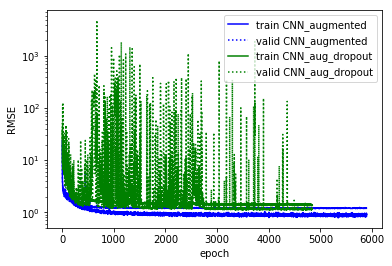

In [27]:
plot_loss([model2_augmented_hist, model3_hist],['CNN_augmented','CNN_aug_dropout'])

switch the BN to be before the dropout .5 and test reducing the level of dropout

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization_22 (Batc (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 46, 46, 64)        8256      
_________________________________________________________________
batch_normalization_23 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 23, 23, 64)        0         
__________

53/53 [==============================] - 3s 52ms/step - loss: 0.0085 - val_loss: 0.0062
Epoch 53/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0105 - val_loss: 0.0045
Epoch 54/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0086 - val_loss: 0.0034
Epoch 55/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0089 - val_loss: 0.0072
Epoch 56/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0094 - val_loss: 0.0047
Epoch 57/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0079 - val_loss: 0.0089
Epoch 58/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0080 - val_loss: 0.0042
Epoch 59/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 60/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0099 - val_loss: 0.0125
Epoch 61/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0089 - va

53/53 [==============================] - 3s 52ms/step - loss: 0.0047 - val_loss: 0.0031
Epoch 132/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 133/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0038 - val_loss: 0.0066
Epoch 134/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0039 - val_loss: 0.0047
Epoch 135/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 136/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 137/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0034 - val_loss: 0.0016
Epoch 138/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 139/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0036 - val_loss: 0.0064
Epoch 140/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.

Epoch 210/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 211/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 212/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0018 - val_loss: 9.9586e-04
Epoch 213/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 214/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 215/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 216/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 217/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 218/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 219/10000
53/53 [==============================] - 3s 

53/53 [==============================] - 3s 52ms/step - loss: 0.0014 - val_loss: 8.0002e-04
Epoch 288/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0014 - val_loss: 8.8393e-04
Epoch 289/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0013 - val_loss: 7.3992e-04
Epoch 290/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0013 - val_loss: 8.3907e-04
Epoch 291/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0012 - val_loss: 7.7766e-04
Epoch 292/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0013 - val_loss: 7.7509e-04
Epoch 293/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0013 - val_loss: 7.7472e-04
Epoch 294/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0013 - val_loss: 7.1943e-04
Epoch 295/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0014 - val_loss: 8.3413e-04
Epoch 296/10000
53/53 [=====================

53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 8.8632e-04
Epoch 364/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0012 - val_loss: 6.7861e-04
Epoch 365/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0012 - val_loss: 6.7399e-04
Epoch 366/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 6.7454e-04
Epoch 367/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 6.4498e-04
Epoch 368/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0012 - val_loss: 6.7524e-04
Epoch 369/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 6.6699e-04
Epoch 370/10000
53/53 [==============================] - 3s 54ms/step - loss: 0.0011 - val_loss: 7.0277e-04
Epoch 371/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0012 - val_loss: 6.4132e-04
Epoch 372/10000
53/53 [=====================

Epoch 439/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.9653e-04 - val_loss: 6.6452e-04
Epoch 440/10000
53/53 [==============================] - 3s 54ms/step - loss: 0.0010 - val_loss: 6.9576e-04
Epoch 441/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0011 - val_loss: 5.8879e-04
Epoch 442/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.8243e-04 - val_loss: 5.9931e-04
Epoch 443/10000
53/53 [==============================] - 3s 54ms/step - loss: 0.0010 - val_loss: 6.1261e-04
Epoch 444/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0010 - val_loss: 6.3671e-04
Epoch 445/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 5.9643e-04
Epoch 446/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 6.7007e-04
Epoch 447/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0010 - val_loss: 5.9348e-04
Epoch 448/10000
53/5

53/53 [==============================] - 3s 52ms/step - loss: 9.8757e-04 - val_loss: 6.4422e-04
Epoch 514/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.5784e-04 - val_loss: 6.7012e-04
Epoch 515/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.2776e-04 - val_loss: 5.7106e-04
Epoch 516/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.8316e-04 - val_loss: 5.9152e-04
Epoch 517/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.7627e-04 - val_loss: 5.7277e-04
Epoch 518/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.8471e-04 - val_loss: 6.1743e-04
Epoch 519/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.2256e-04 - val_loss: 5.9856e-04
Epoch 520/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.6549e-04 - val_loss: 6.2596e-04
Epoch 521/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.2123e-04 - val_loss: 6.1004e-04
Epoch 52

53/53 [==============================] - 3s 51ms/step - loss: 9.3532e-04 - val_loss: 6.3585e-04
Epoch 587/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.2089e-04 - val_loss: 6.0755e-04
Epoch 588/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.6549e-04 - val_loss: 6.4390e-04
Epoch 589/10000
53/53 [==============================] - 3s 50ms/step - loss: 8.9949e-04 - val_loss: 6.0633e-04
Epoch 590/10000
53/53 [==============================] - 3s 55ms/step - loss: 9.1374e-04 - val_loss: 5.8433e-04
Epoch 591/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.0362e-04 - val_loss: 6.0398e-04
Epoch 592/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.2772e-04 - val_loss: 5.6899e-04
Epoch 593/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.4334e-04 - val_loss: 6.3284e-04
Epoch 594/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0010 - val_loss: 6.0710e-04
Epoch 595/10

53/53 [==============================] - 3s 50ms/step - loss: 9.2017e-04 - val_loss: 6.1502e-04
Epoch 660/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.6015e-04 - val_loss: 5.8956e-04
Epoch 661/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.0665e-04 - val_loss: 5.8438e-04
Epoch 662/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.7994e-04 - val_loss: 5.6066e-04
Epoch 663/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.0053e-04 - val_loss: 5.6960e-04
Epoch 664/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.7269e-04 - val_loss: 0.0283
Epoch 665/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.3950e-04 - val_loss: 6.7385e-04
Epoch 666/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.8204e-04 - val_loss: 5.6478e-04
Epoch 667/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0010 - val_loss: 3.7622
Epoch 668/10000
53/5

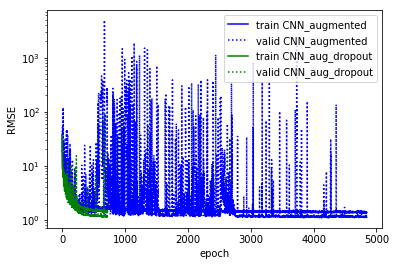

In [28]:
model3_2 = Sequential()
model3_2.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
model3_2.add(BatchNormalization())
model3_2.add(MaxPooling2D(pool_size=(2, 2)))
model3_2.add(Dropout(.1))
model3_2.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
model3_2.add(BatchNormalization())
model3_2.add(MaxPooling2D(pool_size=(2, 2)))
model3_2.add(Dropout(.2))
model3_2.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
model3_2.add(BatchNormalization())
model3_2.add(MaxPooling2D(pool_size=(2, 2)))
model3_2.add(Dropout(.3))
model3_2.add(Flatten())
model3_2.add(Dense(500, activation = "relu"))
model3_2.add(BatchNormalization())
model3_2.add(Dropout(.5))
model3_2.add(Dense(500, activation = "relu"))
model3_2.add(BatchNormalization())
model3_2.add(Dense(30))
print(model3_2.summary())
model3_2_hist, model3_2 = fit_model(model3_2, data,
                                'CNN_aug_dropout_2',datagen,
                                patience=100)
plot_loss([model3_hist, model3_2_hist],['CNN_augmented','CNN_aug_dropout','CNN_aug_dropout2'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization_27 (Batc (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 46, 46, 64)        8256      
_________________________________________________________________
batch_normalization_28 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 23, 23, 64)        0         
__________

Epoch 53/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0087 - val_loss: 0.0122
Epoch 54/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0116 - val_loss: 0.0087
Epoch 55/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0094 - val_loss: 0.0109
Epoch 56/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0104 - val_loss: 0.0162
Epoch 57/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0094 - val_loss: 0.0110
Epoch 58/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0097 - val_loss: 0.0091
Epoch 59/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0087 - val_loss: 0.0116
Epoch 60/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0097 - val_loss: 0.0091
Epoch 61/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0079 - val_loss: 0.0274
Epoch 62/10000
53/53 [==============================] - 3s 50ms/step - lo

53/53 [==============================] - 3s 52ms/step - loss: 0.0035 - val_loss: 0.0134
Epoch 133/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0036 - val_loss: 0.1029
Epoch 134/10000
53/53 [==============================] - 3s 54ms/step - loss: 0.0038 - val_loss: 0.0084
Epoch 135/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 136/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0033 - val_loss: 0.0058
Epoch 137/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0038 - val_loss: 0.0051
Epoch 138/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 139/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 140/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 141/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.

Epoch 211/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 212/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 213/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 214/10000
53/53 [==============================] - 3s 54ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 215/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 216/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 217/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0020 - val_loss: 0.0062
Epoch 218/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 219/10000
53/53 [==============================] - 3s 54ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 220/10000
53/53 [==============================] - 3s 51ms

Epoch 289/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 290/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0013 - val_loss: 8.1429e-04
Epoch 291/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0013 - val_loss: 8.4975e-04
Epoch 292/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0013 - val_loss: 9.0030e-04
Epoch 293/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0015 - val_loss: 0.0629
Epoch 294/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 295/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 296/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0015 - val_loss: 9.1149e-04
Epoch 297/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0013 - val_loss: 8.1662e-04
Epoch 298/10000
53/53 [=====================

53/53 [==============================] - 3s 53ms/step - loss: 0.0010 - val_loss: 6.7237e-04
Epoch 366/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 7.4873e-04
Epoch 367/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0012 - val_loss: 0.0095
Epoch 368/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 7.1377e-04
Epoch 369/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 6.9091e-04
Epoch 370/10000
53/53 [==============================] - 3s 54ms/step - loss: 0.0010 - val_loss: 6.8379e-04
Epoch 371/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 6.3435e-04
Epoch 372/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0011 - val_loss: 8.1302e-04
Epoch 373/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0010 - val_loss: 6.9034e-04
Epoch 374/10000
53/53 [=========================

53/53 [==============================] - 3s 50ms/step - loss: 9.3906e-04 - val_loss: 6.3295e-04
Epoch 440/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.5554e-04 - val_loss: 5.7923e-04
Epoch 441/10000
53/53 [==============================] - 3s 50ms/step - loss: 9.5581e-04 - val_loss: 6.6572e-04
Epoch 442/10000
53/53 [==============================] - 3s 54ms/step - loss: 9.1363e-04 - val_loss: 6.1324e-04
Epoch 443/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.9956e-04 - val_loss: 7.5429e-04
Epoch 444/10000
53/53 [==============================] - 3s 51ms/step - loss: 9.2763e-04 - val_loss: 6.5838e-04
Epoch 445/10000
53/53 [==============================] - 3s 53ms/step - loss: 9.1153e-04 - val_loss: 6.6425e-04
Epoch 446/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.0799e-04 - val_loss: 5.6905e-04
Epoch 447/10000
53/53 [==============================] - 3s 52ms/step - loss: 9.0421e-04 - val_loss: 6.1332e-04
Epoch 44

53/53 [==============================] - 3s 51ms/step - loss: 8.2462e-04 - val_loss: 5.6543e-04
Epoch 513/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.6052e-04 - val_loss: 6.0705e-04
Epoch 514/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.6460e-04 - val_loss: 6.2918e-04
Epoch 515/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.6982e-04 - val_loss: 5.6955e-04
Epoch 516/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.5289e-04 - val_loss: 5.8202e-04
Epoch 517/10000
53/53 [==============================] - 3s 54ms/step - loss: 8.2002e-04 - val_loss: 5.7861e-04
Epoch 518/10000
53/53 [==============================] - 3s 51ms/step - loss: 8.9878e-04 - val_loss: 6.5680e-04
Epoch 519/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.5243e-04 - val_loss: 5.6407e-04
Epoch 520/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.9776e-04 - val_loss: 6.7914e-04
Epoch 52

53/53 [==============================] - 3s 51ms/step - loss: 8.3529e-04 - val_loss: 5.9347e-04
Epoch 586/10000
53/53 [==============================] - 3s 54ms/step - loss: 8.8199e-04 - val_loss: 5.9245e-04
Epoch 587/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.0633e-04 - val_loss: 5.5849e-04
Epoch 588/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.1521e-04 - val_loss: 5.8824e-04
Epoch 589/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.1497e-04 - val_loss: 5.7453e-04
Epoch 590/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.2272e-04 - val_loss: 5.7772e-04
Epoch 591/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.2029e-04 - val_loss: 6.0505e-04
Epoch 592/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.4210e-04 - val_loss: 5.8087e-04
Epoch 593/10000
53/53 [==============================] - 3s 51ms/step - loss: 7.8166e-04 - val_loss: 5.9534e-04
Epoch 59

53/53 [==============================] - 3s 51ms/step - loss: 7.7713e-04 - val_loss: 6.1216e-04
Epoch 659/10000
53/53 [==============================] - 3s 52ms/step - loss: 8.0673e-04 - val_loss: 0.0047
Epoch 660/10000
53/53 [==============================] - 3s 55ms/step - loss: 8.1863e-04 - val_loss: 6.2131e-04
Epoch 661/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.1554e-04 - val_loss: 5.5874e-04
Epoch 662/10000
53/53 [==============================] - 3s 52ms/step - loss: 7.7160e-04 - val_loss: 5.6322e-04
Epoch 663/10000
53/53 [==============================] - 3s 53ms/step - loss: 7.9115e-04 - val_loss: 6.2420e-04
Epoch 664/10000
53/53 [==============================] - 3s 52ms/step - loss: 7.6750e-04 - val_loss: 5.6595e-04
Epoch 665/10000
53/53 [==============================] - 3s 52ms/step - loss: 7.6052e-04 - val_loss: 5.3586e-04
Epoch 666/10000
53/53 [==============================] - 3s 53ms/step - loss: 8.2515e-04 - val_loss: 5.6597e-04
Epoch 667/10

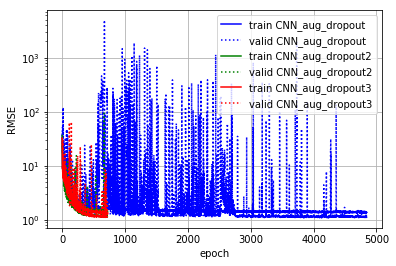

In [29]:
model3_3 = Sequential()
model3_3.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
model3_3.add(BatchNormalization())
model3_3.add(MaxPooling2D(pool_size=(2, 2)))
model3_3.add(Dropout(.1))
model3_3.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
model3_3.add(BatchNormalization())
model3_3.add(MaxPooling2D(pool_size=(2, 2)))
model3_3.add(Dropout(.2))
model3_3.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
model3_3.add(BatchNormalization())
model3_3.add(MaxPooling2D(pool_size=(2, 2)))
model3_3.add(Dropout(.3))
model3_3.add(Flatten())
model3_3.add(Dense(500, activation = "relu"))
model3_3.add(BatchNormalization())
model3_3.add(Dropout(.3))
model3_3.add(Dense(500, activation = "relu"))
model3_3.add(BatchNormalization())
model3_3.add(Dense(30))
print(model3_3.summary())
model3_3_hist, model3_3 = fit_model(model3_3, data,
                                'CNN_aug_dropout_3',datagen,
                                patience=100)
plot_loss([model3_hist, model3_2_hist, model3_3_hist],
          ['CNN_aug_dropout','CNN_aug_dropout2','CNN_aug_dropout3'])

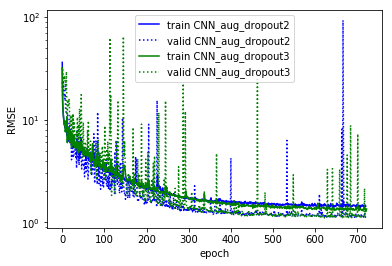

In [30]:
plot_loss([model3_2_hist, model3_3_hist],
          ['CNN_aug_dropout2','CNN_aug_dropout3'])

### Using a model from the zoo

In [ ]:
from keras.applications.inception_v3  import InceptionV3
if len(data) == 4:
            valid_dat = (data[1], data[3])
        else:
            valid_dat = None
            
earlystop = EarlyStopping(monitor='val_loss',
                                 patience=1000,
                                 verbose=1,
                                 mode="auto")
callbacks = [earlystop]

# import model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global average pool and fully connected layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(500, activation='relu')(x)

# add the keypoints predictors
predictions = Dense(30)(x)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False
    
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(loss='mse', optimizer=Nadam())

# train the added layers for a bit
model.fit_generator(datagen,
                    epochs=10000,
                    steps_per_epoch=data[0].shape[0]//32,
                    callbacks=callbacks,
                    validation_data=valid_dat)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
model.compile(loss='mse', optimizer=Nadam())

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(datagen,
                    epochs=10000,
                    steps_per_epoch=data[0].shape[0]//32,
                    callbacks=callbacks,
                    validation_data=valid_dat)


## Create Predictions
### Load the Testing Time Images

In [26]:
out_images, _ , _ = loader(test=True, seed=None, keeplabels=None)

### Create the Preditions

In [27]:
final_model = model2
prediction = final_model.predict(out_images)

### Plot some example predictions

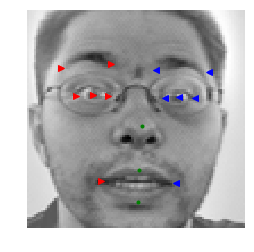

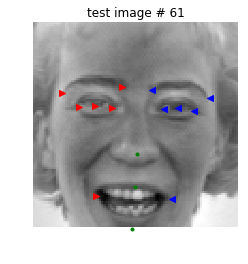

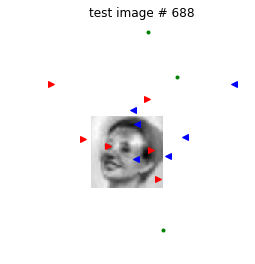

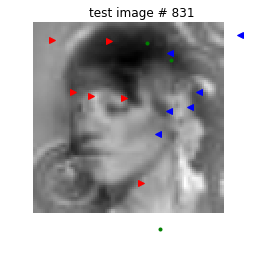

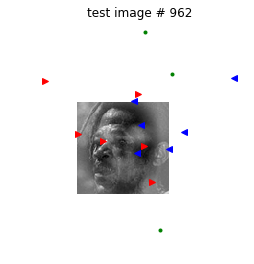

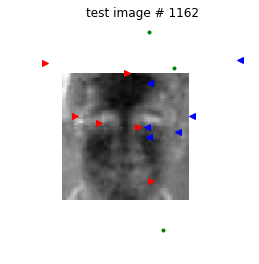

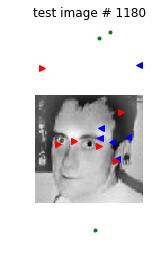

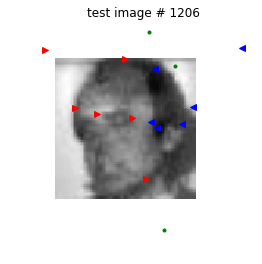

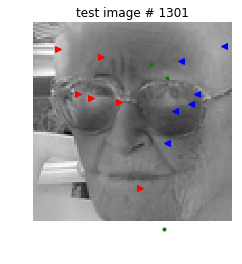

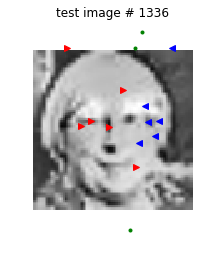

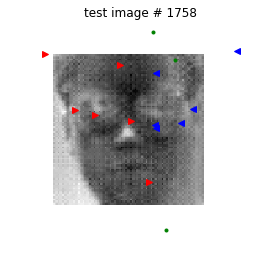

In [28]:
# first image
plot_image(out_images[0], 48*prediction[0]+48, labels)



# images that have labels outside the image
for i in np.where(np.max(np.abs(prediction),axis=1)>1)[0]:
    plot_image(out_images[i],
        48*prediction[i]+48, labels,title='test image # ' + str(i))




### Put the predictions into the submission format

In [29]:
IdLookupTable = read_csv('../data/IdLookupTable.csv')
IdLookupTable.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN


In [30]:
label_locs = {}
for i, label in enumerate(labels):
    label_locs[label]=i

IdLookupTable['test'] = IdLookupTable['FeatureName'].replace(label_locs)
IdLookupTable['Location'] = (48*prediction[IdLookupTable['ImageId']-1,
                                       IdLookupTable['test']]) + 48

IdLookupTable['Location'] = (IdLookupTable['Location'].
                             where(IdLookupTable['Location']<=96, 96).
                             where(IdLookupTable['Location']>=0, 0)
                            )
IdLookupTable.head()

,RowId,ImageId,FeatureName,Location,test
0,1,1,left_eye_center_x,66.801460,0
1,2,1,left_eye_center_y,37.563599,1
2,3,1,right_eye_center_x,28.745617,20
3,4,1,right_eye_center_y,36.957924,21
4,5,1,left_eye_inner_corner_x,60.363380,2


In [31]:
Submission = IdLookupTable[['RowId','Location']]
Submission.head()

,RowId,Location
0,1,66.801460
1,2,37.563599
2,3,28.745617
3,4,36.957924
4,5,60.363380


In [32]:
Submission.to_csv(path_or_buf='./Submissions/CNN_wdatAugment.csv',
                  index=False)

In [33]:
Submission.describe()

,RowId,Location
count,27124.000000,27124.000000
mean,13562.500000,48.609348
std,7830.168687,18.121922
min,1.000000,0.000000
25%,6781.750000,35.262190
50%,13562.500000,45.730776
75%,20343.250000,63.306358
max,27124.000000,96.000000
